In [1]:
"""
Fine-grained classification practice with Flower-17
"""

# Python Packages
import argparse
import os
import time
# 3rd Party Packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import cv2
# User Packages
from start.preprocessing import ImageToTensorPreprocessor, ResizePreprocessor, ColorSpacePreprocessor
from start.loader import ImageDataset
from start.model import MiniVGGNet


In [2]:
# Load Flowers-17 dataset
dataset = ImageDataset(
    preprocessors=[
        ResizePreprocessor(224, 224, aspect_preserving=True),
        ColorSpacePreprocessor(conversion=cv2.COLOR_BGR2GRAY),
        ImageToTensorPreprocessor()
    ]
)
(data, labels) = dataset.load(
    dataset_path=r'/home/share/dataset/flowers17',
    verbosity=80
)

print('data shape: {}'.format(data.shape))
print('labels shape: {}'.format(labels.shape))

classes = set(labels)

# Normalize data
data = data.astype(np.float) / 255.0

[INFO] Processing label: dandelion
[INFO] processed 80 dandelion images
[INFO] Processing label: coltsfoot


[INFO] processed 80 coltsfoot images
[INFO] Processing label: lilyvalley
[INFO] processed 80 lilyvalley images
[INFO] Processing label: cowslip


[INFO] processed 80 cowslip images
[INFO] Processing label: iris
[INFO] processed 80 iris images
[INFO] Processing label: snowdrop


[INFO] processed 80 snowdrop images
[INFO] Processing label: sunflower
[INFO] processed 80 sunflower images
[INFO] Processing label: tigerlily


[INFO] processed 80 tigerlily images
[INFO] Processing label: daisy
[INFO] processed 80 daisy images
[INFO] Processing label: pansy


[INFO] processed 80 pansy images
[INFO] Processing label: crocus
[INFO] processed 80 crocus images
[INFO] Processing label: daffodil


[INFO] processed 80 daffodil images
[INFO] Processing label: fritillary
[INFO] processed 80 fritillary images
[INFO] Processing label: buttercup


[INFO] processed 80 buttercup images
[INFO] Processing label: windflower
[INFO] processed 80 windflower images
[INFO] Processing label: files.txt
[INFO] Processing label: tulip


[INFO] processed 80 tulip images
[INFO] Processing label: bluebell
[INFO] processed 80 bluebell images


data shape: (1360, 224, 224, 1)
labels shape: (1360,)


In [3]:
# Setup data splits
# Partition into train and test splits
(trainX, testX, trainY, testY) = train_test_split(
    data, labels,
    test_size=0.2,
    random_state=int(time.time()),
    stratify=list(labels)
)
(valX, testX, valY, testY) = train_test_split(
    testX, testY,
    test_size=0.4,
    random_state=int(time.time()),
    stratify=list(testY)
)

# Binarize output to one hot vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
valY = lb.fit_transform(valY)
testY = lb.fit_transform(testY)

# Data augmentation
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
# Initialize the optimizer and model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
clear_session()
print('[INFO] compiling model...')
"""
opt = SGD(
    lr=0.05,
    momentum=0.8,
    decay=0,
    nesterov=False
)
"""
opt = Adam(
    lr=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=0.1,
    decay=0.05/100,
    amsgrad=False
)

properties = {
    'width':    224,
    'height':   224,
    'channels': 1,
    'classes':  len(classes)
}
model = MiniVGGNet.build(properties)
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

mnv2 = MobileNetV2(
    input_shape=(224, 224, 1),
    alpha=0.8,
    depth_multiplier=1, 
    include_top=False, 
    weights=None, 
    input_tensor=None, 
    pooling='avg'
)

model = Sequential()
model.add(mnv2)
model.add(Dense(
    units=len(classes),
    activation='softmax',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='glorot_uniform',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None
))
"""
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
#mnv2.summary()
model.summary()

[INFO] compiling model...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
__________

In [11]:
# Initialize TensorBoard
from tensorflow.keras.callbacks import TensorBoard

BATCH_SIZE = 32

timestamp = time.time()

tb_callback = TensorBoard(
    log_dir='./logs/{}'.format(timestamp), 
    histogram_freq=2, 
    batch_size=BATCH_SIZE, 
    write_graph=False, 
    write_grads=False, 
    write_images=False, 
    embeddings_freq=0,
    embeddings_layer_names=None, 
    embeddings_metadata=None, 
    embeddings_data=None
)

In [12]:
# Train the network
print('[INFO] training network...')
N_EPOCHS = 100
print('trainX shape: {}'.format(trainX.shape))
print('trainX dtype: {}'.format(trainX.dtype))
history = model.fit_generator(
    augmenter.flow(trainX, trainY, 
                   batch_size=BATCH_SIZE),
    validation_data=(valX, valY),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=[],
    verbose=1
)

[INFO] training network...
trainX shape: (1088, 224, 224, 1)
trainX dtype: float64


Epoch 1/100


 1/34 [..............................] - ETA: 1:15 - loss: 3.9225 - acc: 0.1250

 2/34 [>.............................] - ETA: 39s - loss: 4.3341 - acc: 0.0781 

 3/34 [=>............................] - ETA: 26s - loss: 4.0637 - acc: 0.1042

 4/34 [==>...........................] - ETA: 20s - loss: 4.0372 - acc: 0.1016

 5/34 [===>..........................] - ETA: 16s - loss: 4.0915 - acc: 0.0813

 6/34 [====>.........................] - ETA: 14s - loss: 4.0218 - acc: 0.0938

 7/34 [=====>........................] - ETA: 12s - loss: 4.0191 - acc: 0.0893

 8/34 [======>.......................] - ETA: 10s - loss: 4.0392 - acc: 0.0820

 9/34 [======>.......................] - ETA: 9s - loss: 4.0893 - acc: 0.0799 

10/34 [=======>......................] - ETA: 8s - loss: 3.9548 - acc: 0.0875

11/34 [========>.....................] - ETA: 7s - loss: 3.9478 - acc: 0.0824

12/34 [=========>....................] - ETA: 7s - loss: 3.9145 - acc: 0.0859

13/34 [==========>...................] - ETA: 6s - loss: 3.9011 - acc: 0.0889

14/34 [===========>..................] - ETA: 5s - loss: 3.8541 - acc: 0.0982

15/34 [============>.................] - ETA: 5s - loss: 3.8164 - acc: 0.1000

16/34 [=============>................] - ETA: 5s - loss: 3.7883 - acc: 0.1035

17/34 [==============>...............] - ETA: 4s - loss: 3.7494 - acc: 0.1066

18/34 [==============>...............] - ETA: 4s - loss: 3.7415 - acc: 0.1042

19/34 [===============>..............] - ETA: 3s - loss: 3.7067 - acc: 0.1102

20/34 [================>.............] - ETA: 3s - loss: 3.6978 - acc: 0.1094

21/34 [=================>............] - ETA: 3s - loss: 3.6974 - acc: 0.1101

22/34 [==================>...........] - ETA: 2s - loss: 3.6563 - acc: 0.1179

23/34 [===================>..........] - ETA: 2s - loss: 3.6429 - acc: 0.1155

24/34 [====================>.........] - ETA: 2s - loss: 3.6274 - acc: 0.1198

25/34 [=====================>........] - ETA: 2s - loss: 3.6105 - acc: 0.1200

26/34 [=====================>........] - ETA: 1s - loss: 3.5862 - acc: 0.1238

27/34 [======================>.......] - ETA: 1s - loss: 3.5594 - acc: 0.1296

28/34 [=======================>......] - ETA: 1s - loss: 3.5380 - acc: 0.1295

29/34 [========================>.....] - ETA: 1s - loss: 3.5041 - acc: 0.1325

30/34 [=========================>....] - ETA: 0s - loss: 3.4926 - acc: 0.1333

31/34 [==========================>...] - ETA: 0s - loss: 3.4539 - acc: 0.1431

32/34 [===========================>..] - ETA: 0s - loss: 3.4543 - acc: 0.1426

33/34 [============================>.] - ETA: 0s - loss: 3.4362 - acc: 0.1468

34/34 [==============================] - 7s 217ms/step - loss: 3.4255 - acc: 0.1489 - val_loss: 3.4563 - val_acc: 0.0552


Epoch 2/100
 1/34 [..............................] - ETA: 4s - loss: 2.1972 - acc: 0.3125

 2/34 [>.............................] - ETA: 4s - loss: 2.4970 - acc: 0.2656

 3/34 [=>............................] - ETA: 4s - loss: 2.5770 - acc: 0.2708

 4/34 [==>...........................] - ETA: 4s - loss: 2.5908 - acc: 0.2500

 5/34 [===>..........................] - ETA: 4s - loss: 2.6320 - acc: 0.2500

 6/34 [====>.........................] - ETA: 3s - loss: 2.7222 - acc: 0.2604

 7/34 [=====>........................] - ETA: 3s - loss: 2.7801 - acc: 0.2455

 8/34 [======>.......................] - ETA: 3s - loss: 2.8668 - acc: 0.2383

 9/34 [======>.......................] - ETA: 3s - loss: 2.8691 - acc: 0.2222

10/34 [=======>......................] - ETA: 3s - loss: 2.8990 - acc: 0.2156

11/34 [========>.....................] - ETA: 3s - loss: 2.8737 - acc: 0.2188

12/34 [=========>....................] - ETA: 3s - loss: 2.8430 - acc: 0.2214

13/34 [==========>...................] - ETA: 2s - loss: 2.8119 - acc: 0.2236

14/34 [===========>..................] - ETA: 2s - loss: 2.8562 - acc: 0.2165

15/34 [============>.................] - ETA: 2s - loss: 2.8358 - acc: 0.2146

16/34 [=============>................] - ETA: 2s - loss: 2.8274 - acc: 0.2148

17/34 [==============>...............] - ETA: 2s - loss: 2.8145 - acc: 0.2132

18/34 [==============>...............] - ETA: 2s - loss: 2.7835 - acc: 0.2188

19/34 [===============>..............] - ETA: 2s - loss: 2.7855 - acc: 0.2188

20/34 [================>.............] - ETA: 2s - loss: 2.7671 - acc: 0.2234

21/34 [=================>............] - ETA: 1s - loss: 2.7956 - acc: 0.2262

22/34 [==================>...........] - ETA: 1s - loss: 2.7859 - acc: 0.2244

23/34 [===================>..........] - ETA: 1s - loss: 2.7847 - acc: 0.2215

24/34 [====================>.........] - ETA: 1s - loss: 2.7734 - acc: 0.2253

25/34 [=====================>........] - ETA: 1s - loss: 2.7659 - acc: 0.2238

26/34 [=====================>........] - ETA: 1s - loss: 2.7825 - acc: 0.2248

27/34 [======================>.......] - ETA: 0s - loss: 2.7814 - acc: 0.2280

28/34 [=======================>......] - ETA: 0s - loss: 2.8063 - acc: 0.2243

29/34 [========================>.....] - ETA: 0s - loss: 2.8145 - acc: 0.2209

30/34 [=========================>....] - ETA: 0s - loss: 2.8137 - acc: 0.2188

31/34 [==========================>...] - ETA: 0s - loss: 2.8133 - acc: 0.2198

32/34 [===========================>..] - ETA: 0s - loss: 2.8044 - acc: 0.2168

33/34 [============================>.] - ETA: 0s - loss: 2.7984 - acc: 0.2169

34/34 [==============================] - 5s 148ms/step - loss: 2.7911 - acc: 0.2169 - val_loss: 5.9636 - val_acc: 0.0613


Epoch 3/100
 1/34 [..............................] - ETA: 4s - loss: 2.2770 - acc: 0.3125

 2/34 [>.............................] - ETA: 4s - loss: 2.2586 - acc: 0.3281

 3/34 [=>............................] - ETA: 4s - loss: 2.3567 - acc: 0.3021

 4/34 [==>...........................] - ETA: 4s - loss: 2.3300 - acc: 0.3203

 5/34 [===>..........................] - ETA: 4s - loss: 2.5116 - acc: 0.2875

 6/34 [====>.........................] - ETA: 3s - loss: 2.5203 - acc: 0.2917

 7/34 [=====>........................] - ETA: 3s - loss: 2.5812 - acc: 0.2946

 8/34 [======>.......................] - ETA: 3s - loss: 2.6048 - acc: 0.2852

 9/34 [======>.......................] - ETA: 3s - loss: 2.5653 - acc: 0.2847

10/34 [=======>......................] - ETA: 3s - loss: 2.5588 - acc: 0.2938

11/34 [========>.....................] - ETA: 3s - loss: 2.5613 - acc: 0.2841

12/34 [=========>....................] - ETA: 3s - loss: 2.5821 - acc: 0.2865

13/34 [==========>...................] - ETA: 3s - loss: 2.5759 - acc: 0.2837

14/34 [===========>..................] - ETA: 2s - loss: 2.5470 - acc: 0.2857

15/34 [============>.................] - ETA: 2s - loss: 2.5342 - acc: 0.2896

16/34 [=============>................] - ETA: 2s - loss: 2.5683 - acc: 0.2871

17/34 [==============>...............] - ETA: 2s - loss: 2.5452 - acc: 0.2941

18/34 [==============>...............] - ETA: 2s - loss: 2.5568 - acc: 0.2951

19/34 [===============>..............] - ETA: 2s - loss: 2.5428 - acc: 0.2977

20/34 [================>.............] - ETA: 2s - loss: 2.5458 - acc: 0.2922

21/34 [=================>............] - ETA: 1s - loss: 2.5246 - acc: 0.2961

22/34 [==================>...........] - ETA: 1s - loss: 2.5169 - acc: 0.2997

23/34 [===================>..........] - ETA: 1s - loss: 2.5223 - acc: 0.2989

24/34 [====================>.........] - ETA: 1s - loss: 2.5307 - acc: 0.3008

25/34 [=====================>........] - ETA: 1s - loss: 2.5419 - acc: 0.2963

26/34 [=====================>........] - ETA: 1s - loss: 2.5536 - acc: 0.2897

27/34 [======================>.......] - ETA: 1s - loss: 2.5298 - acc: 0.2905

28/34 [=======================>......] - ETA: 0s - loss: 2.5278 - acc: 0.2879

29/34 [========================>.....] - ETA: 0s - loss: 2.5295 - acc: 0.2888

30/34 [=========================>....] - ETA: 0s - loss: 2.5510 - acc: 0.2844

31/34 [==========================>...] - ETA: 0s - loss: 2.5745 - acc: 0.2782

32/34 [===========================>..] - ETA: 0s - loss: 2.5754 - acc: 0.2754

33/34 [============================>.] - ETA: 0s - loss: 2.5826 - acc: 0.2737

34/34 [==============================] - 5s 149ms/step - loss: 2.5847 - acc: 0.2767 - val_loss: 8.7829 - val_acc: 0.0613


Epoch 4/100
 1/34 [..............................] - ETA: 4s - loss: 1.9509 - acc: 0.3750

 2/34 [>.............................] - ETA: 4s - loss: 2.0026 - acc: 0.3594

 3/34 [=>............................] - ETA: 4s - loss: 2.1761 - acc: 0.3333

 4/34 [==>...........................] - ETA: 4s - loss: 2.2016 - acc: 0.3125

 5/34 [===>..........................] - ETA: 4s - loss: 2.2155 - acc: 0.2875

 6/34 [====>.........................] - ETA: 4s - loss: 2.2311 - acc: 0.2917

 7/34 [=====>........................] - ETA: 4s - loss: 2.2296 - acc: 0.3080

 8/34 [======>.......................] - ETA: 3s - loss: 2.2759 - acc: 0.3086

 9/34 [======>.......................] - ETA: 3s - loss: 2.2961 - acc: 0.2986

10/34 [=======>......................] - ETA: 3s - loss: 2.2671 - acc: 0.3000

11/34 [========>.....................] - ETA: 3s - loss: 2.3040 - acc: 0.2926

12/34 [=========>....................] - ETA: 3s - loss: 2.2920 - acc: 0.3021

13/34 [==========>...................] - ETA: 3s - loss: 2.2953 - acc: 0.3077

14/34 [===========>..................] - ETA: 2s - loss: 2.3222 - acc: 0.3036

15/34 [============>.................] - ETA: 2s - loss: 2.3180 - acc: 0.3042

16/34 [=============>................] - ETA: 2s - loss: 2.3169 - acc: 0.3027

17/34 [==============>...............] - ETA: 2s - loss: 2.3437 - acc: 0.2960

18/34 [==============>...............] - ETA: 2s - loss: 2.3495 - acc: 0.2882

19/34 [===============>..............] - ETA: 2s - loss: 2.3627 - acc: 0.2911

20/34 [================>.............] - ETA: 2s - loss: 2.3768 - acc: 0.2906

21/34 [=================>............] - ETA: 1s - loss: 2.3865 - acc: 0.2946

22/34 [==================>...........] - ETA: 1s - loss: 2.3666 - acc: 0.2997

23/34 [===================>..........] - ETA: 1s - loss: 2.3697 - acc: 0.3016

24/34 [====================>.........] - ETA: 1s - loss: 2.3672 - acc: 0.3021

25/34 [=====================>........] - ETA: 1s - loss: 2.3714 - acc: 0.3000

26/34 [=====================>........] - ETA: 1s - loss: 2.3832 - acc: 0.3017

27/34 [======================>.......] - ETA: 1s - loss: 2.3738 - acc: 0.3032

28/34 [=======================>......] - ETA: 0s - loss: 2.3931 - acc: 0.3002

29/34 [========================>.....] - ETA: 0s - loss: 2.3793 - acc: 0.3050

30/34 [=========================>....] - ETA: 0s - loss: 2.3871 - acc: 0.3021

31/34 [==========================>...] - ETA: 0s - loss: 2.3863 - acc: 0.3034

32/34 [===========================>..] - ETA: 0s - loss: 2.3846 - acc: 0.3047

33/34 [============================>.] - ETA: 0s - loss: 2.3969 - acc: 0.3021

34/34 [==============================] - 5s 149ms/step - loss: 2.4046 - acc: 0.3024 - val_loss: 11.2255 - val_acc: 0.0675


Epoch 5/100
 1/34 [..............................] - ETA: 5s - loss: 2.7515 - acc: 0.1875

 2/34 [>.............................] - ETA: 5s - loss: 2.4583 - acc: 0.2344

 3/34 [=>............................] - ETA: 4s - loss: 2.5340 - acc: 0.2188

 4/34 [==>...........................] - ETA: 4s - loss: 2.5700 - acc: 0.1953

 5/34 [===>..........................] - ETA: 4s - loss: 2.5219 - acc: 0.2125

 6/34 [====>.........................] - ETA: 4s - loss: 2.5036 - acc: 0.2292

 7/34 [=====>........................] - ETA: 3s - loss: 2.4888 - acc: 0.2500

 8/34 [======>.......................] - ETA: 3s - loss: 2.4380 - acc: 0.2734

 9/34 [======>.......................] - ETA: 3s - loss: 2.4374 - acc: 0.2743

10/34 [=======>......................] - ETA: 3s - loss: 2.4785 - acc: 0.2594

11/34 [========>.....................] - ETA: 3s - loss: 2.4302 - acc: 0.2756

12/34 [=========>....................] - ETA: 3s - loss: 2.4279 - acc: 0.2760

13/34 [==========>...................] - ETA: 3s - loss: 2.4263 - acc: 0.2788

14/34 [===========>..................] - ETA: 2s - loss: 2.4202 - acc: 0.2857

15/34 [============>.................] - ETA: 2s - loss: 2.4195 - acc: 0.2875

16/34 [=============>................] - ETA: 2s - loss: 2.3819 - acc: 0.2969

17/34 [==============>...............] - ETA: 2s - loss: 2.3867 - acc: 0.2996

18/34 [==============>...............] - ETA: 2s - loss: 2.3933 - acc: 0.2934

19/34 [===============>..............] - ETA: 2s - loss: 2.3817 - acc: 0.2928

20/34 [================>.............] - ETA: 2s - loss: 2.3869 - acc: 0.2922

21/34 [=================>............] - ETA: 1s - loss: 2.4100 - acc: 0.2887

22/34 [==================>...........] - ETA: 1s - loss: 2.4095 - acc: 0.2869

23/34 [===================>..........] - ETA: 1s - loss: 2.4166 - acc: 0.2853

24/34 [====================>.........] - ETA: 1s - loss: 2.4457 - acc: 0.2839

25/34 [=====================>........] - ETA: 1s - loss: 2.4674 - acc: 0.2787

26/34 [=====================>........] - ETA: 1s - loss: 2.4608 - acc: 0.2776

27/34 [======================>.......] - ETA: 1s - loss: 2.4677 - acc: 0.2789

28/34 [=======================>......] - ETA: 0s - loss: 2.4636 - acc: 0.2768

29/34 [========================>.....] - ETA: 0s - loss: 2.4494 - acc: 0.2791

30/34 [=========================>....] - ETA: 0s - loss: 2.4466 - acc: 0.2792

31/34 [==========================>...] - ETA: 0s - loss: 2.4396 - acc: 0.2812

32/34 [===========================>..] - ETA: 0s - loss: 2.4245 - acc: 0.2852

33/34 [============================>.] - ETA: 0s - loss: 2.4329 - acc: 0.2869

34/34 [==============================] - 5s 150ms/step - loss: 2.4318 - acc: 0.2877 - val_loss: 6.5026 - val_acc: 0.0491


Epoch 6/100
 1/34 [..............................] - ETA: 4s - loss: 2.2866 - acc: 0.3438

 2/34 [>.............................] - ETA: 4s - loss: 2.1477 - acc: 0.3750

 3/34 [=>............................] - ETA: 4s - loss: 2.2901 - acc: 0.3542

 4/34 [==>...........................] - ETA: 4s - loss: 2.3130 - acc: 0.3281

 5/34 [===>..........................] - ETA: 4s - loss: 2.3843 - acc: 0.3250

 6/34 [====>.........................] - ETA: 3s - loss: 2.3739 - acc: 0.3177

 7/34 [=====>........................] - ETA: 3s - loss: 2.3581 - acc: 0.3259

 8/34 [======>.......................] - ETA: 3s - loss: 2.3364 - acc: 0.3320

 9/34 [======>.......................] - ETA: 3s - loss: 2.3707 - acc: 0.3194

10/34 [=======>......................] - ETA: 3s - loss: 2.3595 - acc: 0.3125

11/34 [========>.....................] - ETA: 3s - loss: 2.3547 - acc: 0.3210

12/34 [=========>....................] - ETA: 3s - loss: 2.3545 - acc: 0.3203

13/34 [==========>...................] - ETA: 3s - loss: 2.3731 - acc: 0.3173

14/34 [===========>..................] - ETA: 2s - loss: 2.3525 - acc: 0.3259

15/34 [============>.................] - ETA: 2s - loss: 2.3452 - acc: 0.3187

16/34 [=============>................] - ETA: 2s - loss: 2.3789 - acc: 0.3145

17/34 [==============>...............] - ETA: 2s - loss: 2.3382 - acc: 0.3235

18/34 [==============>...............] - ETA: 2s - loss: 2.3291 - acc: 0.3281

19/34 [===============>..............] - ETA: 2s - loss: 2.3283 - acc: 0.3273

20/34 [================>.............] - ETA: 2s - loss: 2.3396 - acc: 0.3219

21/34 [=================>............] - ETA: 1s - loss: 2.3346 - acc: 0.3155

22/34 [==================>...........] - ETA: 1s - loss: 2.3289 - acc: 0.3182

23/34 [===================>..........] - ETA: 1s - loss: 2.3128 - acc: 0.3193

24/34 [====================>.........] - ETA: 1s - loss: 2.3216 - acc: 0.3164

25/34 [=====================>........] - ETA: 1s - loss: 2.3193 - acc: 0.3175

26/34 [=====================>........] - ETA: 1s - loss: 2.3226 - acc: 0.3221

27/34 [======================>.......] - ETA: 1s - loss: 2.3280 - acc: 0.3148

28/34 [=======================>......] - ETA: 0s - loss: 2.3381 - acc: 0.3136

29/34 [========================>.....] - ETA: 0s - loss: 2.3415 - acc: 0.3157

30/34 [=========================>....] - ETA: 0s - loss: 2.3289 - acc: 0.3208

31/34 [==========================>...] - ETA: 0s - loss: 2.3324 - acc: 0.3196

32/34 [===========================>..] - ETA: 0s - loss: 2.3573 - acc: 0.3174

33/34 [============================>.] - ETA: 0s - loss: 2.3552 - acc: 0.3134

34/34 [==============================] - 5s 150ms/step - loss: 2.3440 - acc: 0.3143 - val_loss: 11.7076 - val_acc: 0.0798


Epoch 7/100
 1/34 [..............................] - ETA: 4s - loss: 1.9288 - acc: 0.4062

 2/34 [>.............................] - ETA: 4s - loss: 2.2420 - acc: 0.3594

 3/34 [=>............................] - ETA: 4s - loss: 2.1210 - acc: 0.3750

 4/34 [==>...........................] - ETA: 4s - loss: 2.1670 - acc: 0.3828

 5/34 [===>..........................] - ETA: 4s - loss: 2.1753 - acc: 0.3750

 6/34 [====>.........................] - ETA: 3s - loss: 2.2478 - acc: 0.3542

 7/34 [=====>........................] - ETA: 3s - loss: 2.2355 - acc: 0.3571

 8/34 [======>.......................] - ETA: 3s - loss: 2.1747 - acc: 0.3672

 9/34 [======>.......................] - ETA: 3s - loss: 2.1302 - acc: 0.3750

10/34 [=======>......................] - ETA: 3s - loss: 2.1210 - acc: 0.3719

11/34 [========>.....................] - ETA: 3s - loss: 2.1178 - acc: 0.3750

12/34 [=========>....................] - ETA: 3s - loss: 2.1553 - acc: 0.3620

13/34 [==========>...................] - ETA: 3s - loss: 2.1590 - acc: 0.3558

14/34 [===========>..................] - ETA: 2s - loss: 2.1844 - acc: 0.3438

15/34 [============>.................] - ETA: 2s - loss: 2.1914 - acc: 0.3438

16/34 [=============>................] - ETA: 2s - loss: 2.2186 - acc: 0.3398

17/34 [==============>...............] - ETA: 2s - loss: 2.2192 - acc: 0.3401

18/34 [==============>...............] - ETA: 2s - loss: 2.2287 - acc: 0.3385

19/34 [===============>..............] - ETA: 2s - loss: 2.2324 - acc: 0.3388

20/34 [================>.............] - ETA: 2s - loss: 2.2182 - acc: 0.3438

21/34 [=================>............] - ETA: 1s - loss: 2.2048 - acc: 0.3438

22/34 [==================>...........] - ETA: 1s - loss: 2.1933 - acc: 0.3480

23/34 [===================>..........] - ETA: 1s - loss: 2.1951 - acc: 0.3465

24/34 [====================>.........] - ETA: 1s - loss: 2.1941 - acc: 0.3438

25/34 [=====================>........] - ETA: 1s - loss: 2.1960 - acc: 0.3450

26/34 [=====================>........] - ETA: 1s - loss: 2.1848 - acc: 0.3498

27/34 [======================>.......] - ETA: 1s - loss: 2.1762 - acc: 0.3542

28/34 [=======================>......] - ETA: 0s - loss: 2.1832 - acc: 0.3549

29/34 [========================>.....] - ETA: 0s - loss: 2.1771 - acc: 0.3578

30/34 [=========================>....] - ETA: 0s - loss: 2.1790 - acc: 0.3573

31/34 [==========================>...] - ETA: 0s - loss: 2.1781 - acc: 0.3548

32/34 [===========================>..] - ETA: 0s - loss: 2.1692 - acc: 0.3545

33/34 [============================>.] - ETA: 0s - loss: 2.1793 - acc: 0.3551

34/34 [==============================] - 5s 151ms/step - loss: 2.1819 - acc: 0.3529 - val_loss: 12.2864 - val_acc: 0.0798


Epoch 8/100
 1/34 [..............................] - ETA: 4s - loss: 2.3500 - acc: 0.3750

 2/34 [>.............................] - ETA: 4s - loss: 2.0823 - acc: 0.4062

 3/34 [=>............................] - ETA: 4s - loss: 2.0080 - acc: 0.4062

 4/34 [==>...........................] - ETA: 4s - loss: 2.1199 - acc: 0.3984

 5/34 [===>..........................] - ETA: 4s - loss: 2.1370 - acc: 0.3750

 6/34 [====>.........................] - ETA: 4s - loss: 2.1421 - acc: 0.3646

 7/34 [=====>........................] - ETA: 4s - loss: 2.0746 - acc: 0.3795

 8/34 [======>.......................] - ETA: 3s - loss: 2.0440 - acc: 0.3828

 9/34 [======>.......................] - ETA: 3s - loss: 2.0851 - acc: 0.3611

10/34 [=======>......................] - ETA: 3s - loss: 2.0698 - acc: 0.3594

11/34 [========>.....................] - ETA: 3s - loss: 2.0973 - acc: 0.3494

12/34 [=========>....................] - ETA: 3s - loss: 2.1077 - acc: 0.3516

13/34 [==========>...................] - ETA: 3s - loss: 2.1052 - acc: 0.3558

14/34 [===========>..................] - ETA: 2s - loss: 2.1015 - acc: 0.3594

15/34 [============>.................] - ETA: 2s - loss: 2.1065 - acc: 0.3604

16/34 [=============>................] - ETA: 2s - loss: 2.1070 - acc: 0.3535

17/34 [==============>...............] - ETA: 2s - loss: 2.1078 - acc: 0.3474

18/34 [==============>...............] - ETA: 2s - loss: 2.1090 - acc: 0.3472

19/34 [===============>..............] - ETA: 2s - loss: 2.0982 - acc: 0.3503

20/34 [================>.............] - ETA: 2s - loss: 2.0807 - acc: 0.3547

21/34 [=================>............] - ETA: 1s - loss: 2.0773 - acc: 0.3571

22/34 [==================>...........] - ETA: 1s - loss: 2.1259 - acc: 0.3480

23/34 [===================>..........] - ETA: 1s - loss: 2.1339 - acc: 0.3451

24/34 [====================>.........] - ETA: 1s - loss: 2.1122 - acc: 0.3503

25/34 [=====================>........] - ETA: 1s - loss: 2.1314 - acc: 0.3488

26/34 [=====================>........] - ETA: 1s - loss: 2.1424 - acc: 0.3474

27/34 [======================>.......] - ETA: 1s - loss: 2.1472 - acc: 0.3472

28/34 [=======================>......] - ETA: 0s - loss: 2.1488 - acc: 0.3471

29/34 [========================>.....] - ETA: 0s - loss: 2.1406 - acc: 0.3513

30/34 [=========================>....] - ETA: 0s - loss: 2.1431 - acc: 0.3531

31/34 [==========================>...] - ETA: 0s - loss: 2.1403 - acc: 0.3528

32/34 [===========================>..] - ETA: 0s - loss: 2.1377 - acc: 0.3535

33/34 [============================>.] - ETA: 0s - loss: 2.1522 - acc: 0.3532

34/34 [==============================] - 5s 152ms/step - loss: 2.1552 - acc: 0.3529 - val_loss: 10.1774 - val_acc: 0.0552


Epoch 9/100
 1/34 [..............................] - ETA: 4s - loss: 2.0291 - acc: 0.4375

 2/34 [>.............................] - ETA: 4s - loss: 1.7799 - acc: 0.5000

 3/34 [=>............................] - ETA: 4s - loss: 1.9429 - acc: 0.4792

 4/34 [==>...........................] - ETA: 4s - loss: 1.9900 - acc: 0.4609

 5/34 [===>..........................] - ETA: 4s - loss: 2.0327 - acc: 0.4250

 6/34 [====>.........................] - ETA: 4s - loss: 2.0514 - acc: 0.4323

 7/34 [=====>........................] - ETA: 3s - loss: 1.9701 - acc: 0.4375

 8/34 [======>.......................] - ETA: 3s - loss: 2.0323 - acc: 0.4141

 9/34 [======>.......................] - ETA: 3s - loss: 2.0243 - acc: 0.4097

10/34 [=======>......................] - ETA: 3s - loss: 2.0617 - acc: 0.3937

11/34 [========>.....................] - ETA: 3s - loss: 2.1010 - acc: 0.3864

12/34 [=========>....................] - ETA: 3s - loss: 2.0924 - acc: 0.3880

13/34 [==========>...................] - ETA: 3s - loss: 2.0781 - acc: 0.3894

14/34 [===========>..................] - ETA: 2s - loss: 2.0796 - acc: 0.3862

15/34 [============>.................] - ETA: 2s - loss: 2.0730 - acc: 0.3854

16/34 [=============>................] - ETA: 2s - loss: 2.0788 - acc: 0.3828

17/34 [==============>...............] - ETA: 2s - loss: 2.0499 - acc: 0.3934

18/34 [==============>...............] - ETA: 2s - loss: 2.0639 - acc: 0.3906

19/34 [===============>..............] - ETA: 2s - loss: 2.0698 - acc: 0.3882

20/34 [================>.............] - ETA: 2s - loss: 2.1103 - acc: 0.3828

21/34 [=================>............] - ETA: 1s - loss: 2.1317 - acc: 0.3810

22/34 [==================>...........] - ETA: 1s - loss: 2.1457 - acc: 0.3736

23/34 [===================>..........] - ETA: 1s - loss: 2.1525 - acc: 0.3709

24/34 [====================>.........] - ETA: 1s - loss: 2.1403 - acc: 0.3737

25/34 [=====================>........] - ETA: 1s - loss: 2.1341 - acc: 0.3750

26/34 [=====================>........] - ETA: 1s - loss: 2.1525 - acc: 0.3702

27/34 [======================>.......] - ETA: 1s - loss: 2.1384 - acc: 0.3715

28/34 [=======================>......] - ETA: 0s - loss: 2.1406 - acc: 0.3672

29/34 [========================>.....] - ETA: 0s - loss: 2.1270 - acc: 0.3685

30/34 [=========================>....] - ETA: 0s - loss: 2.1297 - acc: 0.3708

31/34 [==========================>...] - ETA: 0s - loss: 2.1306 - acc: 0.3710

32/34 [===========================>..] - ETA: 0s - loss: 2.1397 - acc: 0.3691

33/34 [============================>.] - ETA: 0s - loss: 2.1364 - acc: 0.3684

34/34 [==============================] - 5s 150ms/step - loss: 2.1204 - acc: 0.3695 - val_loss: 12.5286 - val_acc: 0.0798


Epoch 10/100
 1/34 [..............................] - ETA: 4s - loss: 2.0050 - acc: 0.3750

 2/34 [>.............................] - ETA: 4s - loss: 2.2108 - acc: 0.3906

 3/34 [=>............................] - ETA: 4s - loss: 2.1725 - acc: 0.3646

 4/34 [==>...........................] - ETA: 4s - loss: 2.1640 - acc: 0.3906

 5/34 [===>..........................] - ETA: 4s - loss: 2.0891 - acc: 0.4062

 6/34 [====>.........................] - ETA: 4s - loss: 2.0136 - acc: 0.4323

 7/34 [=====>........................] - ETA: 3s - loss: 2.0665 - acc: 0.4107

 8/34 [======>.......................] - ETA: 3s - loss: 2.1247 - acc: 0.4023

 9/34 [======>.......................] - ETA: 3s - loss: 2.1128 - acc: 0.3924

10/34 [=======>......................] - ETA: 3s - loss: 2.1135 - acc: 0.3875

11/34 [========>.....................] - ETA: 3s - loss: 2.0916 - acc: 0.3864

12/34 [=========>....................] - ETA: 3s - loss: 2.1196 - acc: 0.3828

13/34 [==========>...................] - ETA: 3s - loss: 2.0887 - acc: 0.3846

14/34 [===========>..................] - ETA: 2s - loss: 2.0649 - acc: 0.3929

15/34 [============>.................] - ETA: 2s - loss: 2.0441 - acc: 0.3979

16/34 [=============>................] - ETA: 2s - loss: 2.0384 - acc: 0.4082

17/34 [==============>...............] - ETA: 2s - loss: 2.0226 - acc: 0.4007

18/34 [==============>...............] - ETA: 2s - loss: 2.0159 - acc: 0.4062

19/34 [===============>..............] - ETA: 2s - loss: 2.0127 - acc: 0.4079

20/34 [================>.............] - ETA: 2s - loss: 1.9875 - acc: 0.4141

21/34 [=================>............] - ETA: 1s - loss: 2.0041 - acc: 0.4152

22/34 [==================>...........] - ETA: 1s - loss: 2.0082 - acc: 0.4148

23/34 [===================>..........] - ETA: 1s - loss: 2.0097 - acc: 0.4130

24/34 [====================>.........] - ETA: 1s - loss: 2.0285 - acc: 0.4128

25/34 [=====================>........] - ETA: 1s - loss: 2.0172 - acc: 0.4088

26/34 [=====================>........] - ETA: 1s - loss: 2.0219 - acc: 0.4099

27/34 [======================>.......] - ETA: 1s - loss: 2.0240 - acc: 0.4097

28/34 [=======================>......] - ETA: 0s - loss: 2.0274 - acc: 0.4085

29/34 [========================>.....] - ETA: 0s - loss: 2.0241 - acc: 0.4052

30/34 [=========================>....] - ETA: 0s - loss: 2.0222 - acc: 0.4083

31/34 [==========================>...] - ETA: 0s - loss: 2.0148 - acc: 0.4113

32/34 [===========================>..] - ETA: 0s - loss: 2.0180 - acc: 0.4111

33/34 [============================>.] - ETA: 0s - loss: 2.0291 - acc: 0.4081

34/34 [==============================] - 5s 151ms/step - loss: 2.0353 - acc: 0.4053 - val_loss: 6.8510 - val_acc: 0.0798


Epoch 11/100
 1/34 [..............................] - ETA: 4s - loss: 1.9532 - acc: 0.4688

 2/34 [>.............................] - ETA: 4s - loss: 2.0828 - acc: 0.3438

 3/34 [=>............................] - ETA: 4s - loss: 2.0700 - acc: 0.3646

 4/34 [==>...........................] - ETA: 4s - loss: 2.0847 - acc: 0.3594

 5/34 [===>..........................] - ETA: 4s - loss: 2.0185 - acc: 0.3937

 6/34 [====>.........................] - ETA: 4s - loss: 1.9642 - acc: 0.4010

 7/34 [=====>........................] - ETA: 4s - loss: 1.9552 - acc: 0.3973

 8/34 [======>.......................] - ETA: 3s - loss: 1.9515 - acc: 0.4023

 9/34 [======>.......................] - ETA: 3s - loss: 1.9416 - acc: 0.4062

10/34 [=======>......................] - ETA: 3s - loss: 1.9165 - acc: 0.4156

11/34 [========>.....................] - ETA: 3s - loss: 1.9222 - acc: 0.4148

12/34 [=========>....................] - ETA: 3s - loss: 1.9106 - acc: 0.4141

13/34 [==========>...................] - ETA: 3s - loss: 1.9156 - acc: 0.4159

14/34 [===========>..................] - ETA: 3s - loss: 1.9153 - acc: 0.4129

15/34 [============>.................] - ETA: 2s - loss: 1.9250 - acc: 0.4125

16/34 [=============>................] - ETA: 2s - loss: 1.9257 - acc: 0.4199

17/34 [==============>...............] - ETA: 2s - loss: 1.9624 - acc: 0.4118

18/34 [==============>...............] - ETA: 2s - loss: 1.9619 - acc: 0.4045

19/34 [===============>..............] - ETA: 2s - loss: 1.9691 - acc: 0.4046

20/34 [================>.............] - ETA: 2s - loss: 1.9745 - acc: 0.4062

21/34 [=================>............] - ETA: 1s - loss: 1.9908 - acc: 0.4062

22/34 [==================>...........] - ETA: 1s - loss: 1.9870 - acc: 0.4062

23/34 [===================>..........] - ETA: 1s - loss: 1.9773 - acc: 0.4117

24/34 [====================>.........] - ETA: 1s - loss: 1.9761 - acc: 0.4115

25/34 [=====================>........] - ETA: 1s - loss: 1.9852 - acc: 0.4062

26/34 [=====================>........] - ETA: 1s - loss: 1.9944 - acc: 0.4026

27/34 [======================>.......] - ETA: 1s - loss: 1.9884 - acc: 0.4028

28/34 [=======================>......] - ETA: 0s - loss: 1.9770 - acc: 0.4040

29/34 [========================>.....] - ETA: 0s - loss: 1.9784 - acc: 0.4062

30/34 [=========================>....] - ETA: 0s - loss: 1.9730 - acc: 0.4094

31/34 [==========================>...] - ETA: 0s - loss: 1.9672 - acc: 0.4093

32/34 [===========================>..] - ETA: 0s - loss: 1.9631 - acc: 0.4062

33/34 [============================>.] - ETA: 0s - loss: 1.9545 - acc: 0.4100

34/34 [==============================] - 5s 156ms/step - loss: 1.9420 - acc: 0.4145 - val_loss: 6.2732 - val_acc: 0.0920


Epoch 12/100
 1/34 [..............................] - ETA: 5s - loss: 1.7412 - acc: 0.4062

 2/34 [>.............................] - ETA: 5s - loss: 2.0307 - acc: 0.3594

 3/34 [=>............................] - ETA: 4s - loss: 1.9672 - acc: 0.3854

 4/34 [==>...........................] - ETA: 4s - loss: 1.9614 - acc: 0.3906

 5/34 [===>..........................] - ETA: 4s - loss: 1.8795 - acc: 0.4000

 6/34 [====>.........................] - ETA: 4s - loss: 1.8333 - acc: 0.4219

 7/34 [=====>........................] - ETA: 4s - loss: 1.8345 - acc: 0.4330

 8/34 [======>.......................] - ETA: 3s - loss: 1.8284 - acc: 0.4375

 9/34 [======>.......................] - ETA: 3s - loss: 1.8488 - acc: 0.4306

10/34 [=======>......................] - ETA: 3s - loss: 1.8920 - acc: 0.4219

11/34 [========>.....................] - ETA: 3s - loss: 1.9037 - acc: 0.4205

12/34 [=========>....................] - ETA: 3s - loss: 1.8865 - acc: 0.4245

13/34 [==========>...................] - ETA: 3s - loss: 1.8810 - acc: 0.4279

14/34 [===========>..................] - ETA: 2s - loss: 1.8838 - acc: 0.4263

15/34 [============>.................] - ETA: 2s - loss: 1.8943 - acc: 0.4292

16/34 [=============>................] - ETA: 2s - loss: 1.8979 - acc: 0.4336

17/34 [==============>...............] - ETA: 2s - loss: 1.9142 - acc: 0.4301

18/34 [==============>...............] - ETA: 2s - loss: 1.9243 - acc: 0.4236

19/34 [===============>..............] - ETA: 2s - loss: 1.9183 - acc: 0.4211

20/34 [================>.............] - ETA: 2s - loss: 1.9157 - acc: 0.4234

21/34 [=================>............] - ETA: 1s - loss: 1.9178 - acc: 0.4196

22/34 [==================>...........] - ETA: 1s - loss: 1.9336 - acc: 0.4205

23/34 [===================>..........] - ETA: 1s - loss: 1.9602 - acc: 0.4144

24/34 [====================>.........] - ETA: 1s - loss: 1.9706 - acc: 0.4128

25/34 [=====================>........] - ETA: 1s - loss: 1.9519 - acc: 0.4225

26/34 [=====================>........] - ETA: 1s - loss: 1.9430 - acc: 0.4279

27/34 [======================>.......] - ETA: 1s - loss: 1.9431 - acc: 0.4282

28/34 [=======================>......] - ETA: 0s - loss: 1.9249 - acc: 0.4308

29/34 [========================>.....] - ETA: 0s - loss: 1.9116 - acc: 0.4353

30/34 [=========================>....] - ETA: 0s - loss: 1.9262 - acc: 0.4323

31/34 [==========================>...] - ETA: 0s - loss: 1.9354 - acc: 0.4294

32/34 [===========================>..] - ETA: 0s - loss: 1.9383 - acc: 0.4287

33/34 [============================>.] - ETA: 0s - loss: 1.9459 - acc: 0.4261

34/34 [==============================] - 5s 154ms/step - loss: 1.9303 - acc: 0.4301 - val_loss: 4.0045 - val_acc: 0.2025


Epoch 13/100
 1/34 [..............................] - ETA: 4s - loss: 1.5188 - acc: 0.6562

 2/34 [>.............................] - ETA: 4s - loss: 1.8734 - acc: 0.4844

 3/34 [=>............................] - ETA: 4s - loss: 1.9779 - acc: 0.4479

 4/34 [==>...........................] - ETA: 4s - loss: 1.9219 - acc: 0.4531

 5/34 [===>..........................] - ETA: 4s - loss: 1.8525 - acc: 0.4562

 6/34 [====>.........................] - ETA: 4s - loss: 1.9597 - acc: 0.4375

 7/34 [=====>........................] - ETA: 3s - loss: 1.9527 - acc: 0.4241

 8/34 [======>.......................] - ETA: 3s - loss: 2.0031 - acc: 0.4141

 9/34 [======>.......................] - ETA: 3s - loss: 1.9880 - acc: 0.4132

10/34 [=======>......................] - ETA: 3s - loss: 1.9996 - acc: 0.4125

11/34 [========>.....................] - ETA: 3s - loss: 2.0163 - acc: 0.4062

12/34 [=========>....................] - ETA: 3s - loss: 1.9600 - acc: 0.4089

13/34 [==========>...................] - ETA: 3s - loss: 1.9909 - acc: 0.4038

14/34 [===========>..................] - ETA: 2s - loss: 1.9925 - acc: 0.3929

15/34 [============>.................] - ETA: 2s - loss: 2.0146 - acc: 0.3875

16/34 [=============>................] - ETA: 2s - loss: 2.0071 - acc: 0.3926

17/34 [==============>...............] - ETA: 2s - loss: 1.9977 - acc: 0.3952

18/34 [==============>...............] - ETA: 2s - loss: 2.0009 - acc: 0.3941

19/34 [===============>..............] - ETA: 2s - loss: 2.0012 - acc: 0.3964

20/34 [================>.............] - ETA: 2s - loss: 2.0226 - acc: 0.3953

21/34 [=================>............] - ETA: 1s - loss: 2.0268 - acc: 0.3914

22/34 [==================>...........] - ETA: 1s - loss: 2.0252 - acc: 0.3906

23/34 [===================>..........] - ETA: 1s - loss: 2.0319 - acc: 0.3954

24/34 [====================>.........] - ETA: 1s - loss: 2.0322 - acc: 0.3958

25/34 [=====================>........] - ETA: 1s - loss: 2.0279 - acc: 0.3962

26/34 [=====================>........] - ETA: 1s - loss: 2.0107 - acc: 0.3990

27/34 [======================>.......] - ETA: 1s - loss: 2.0185 - acc: 0.3970

28/34 [=======================>......] - ETA: 0s - loss: 2.0166 - acc: 0.3962

29/34 [========================>.....] - ETA: 0s - loss: 2.0357 - acc: 0.3933

30/34 [=========================>....] - ETA: 0s - loss: 2.0408 - acc: 0.3875

31/34 [==========================>...] - ETA: 0s - loss: 2.0388 - acc: 0.3911

32/34 [===========================>..] - ETA: 0s - loss: 2.0439 - acc: 0.3887

33/34 [============================>.] - ETA: 0s - loss: 2.0355 - acc: 0.3911

34/34 [==============================] - 5s 154ms/step - loss: 2.0321 - acc: 0.3906 - val_loss: 4.0524 - val_acc: 0.1656


Epoch 14/100
 1/34 [..............................] - ETA: 4s - loss: 1.7545 - acc: 0.5000

 2/34 [>.............................] - ETA: 4s - loss: 2.0118 - acc: 0.4375

 3/34 [=>............................] - ETA: 4s - loss: 2.0294 - acc: 0.3958

 4/34 [==>...........................] - ETA: 4s - loss: 2.0709 - acc: 0.3906

 5/34 [===>..........................] - ETA: 4s - loss: 2.0217 - acc: 0.3812

 6/34 [====>.........................] - ETA: 4s - loss: 1.9985 - acc: 0.3750

 7/34 [=====>........................] - ETA: 4s - loss: 2.0703 - acc: 0.3616

 8/34 [======>.......................] - ETA: 3s - loss: 2.0427 - acc: 0.3555

 9/34 [======>.......................] - ETA: 3s - loss: 2.0311 - acc: 0.3507

10/34 [=======>......................] - ETA: 3s - loss: 2.0958 - acc: 0.3406

11/34 [========>.....................] - ETA: 3s - loss: 2.0562 - acc: 0.3523

12/34 [=========>....................] - ETA: 3s - loss: 2.0729 - acc: 0.3516

13/34 [==========>...................] - ETA: 3s - loss: 2.0693 - acc: 0.3558

14/34 [===========>..................] - ETA: 2s - loss: 2.0803 - acc: 0.3594

15/34 [============>.................] - ETA: 2s - loss: 2.0919 - acc: 0.3521

16/34 [=============>................] - ETA: 2s - loss: 2.1110 - acc: 0.3535

17/34 [==============>...............] - ETA: 2s - loss: 2.0981 - acc: 0.3603

18/34 [==============>...............] - ETA: 2s - loss: 2.0661 - acc: 0.3663

19/34 [===============>..............] - ETA: 2s - loss: 2.0594 - acc: 0.3651

20/34 [================>.............] - ETA: 2s - loss: 2.0478 - acc: 0.3734

21/34 [=================>............] - ETA: 1s - loss: 2.0532 - acc: 0.3690

22/34 [==================>...........] - ETA: 1s - loss: 2.0431 - acc: 0.3722

23/34 [===================>..........] - ETA: 1s - loss: 2.0303 - acc: 0.3736

24/34 [====================>.........] - ETA: 1s - loss: 2.0085 - acc: 0.3789

25/34 [=====================>........] - ETA: 1s - loss: 2.0050 - acc: 0.3787

26/34 [=====================>........] - ETA: 1s - loss: 1.9906 - acc: 0.3846

27/34 [======================>.......] - ETA: 1s - loss: 1.9978 - acc: 0.3843

28/34 [=======================>......] - ETA: 0s - loss: 2.0192 - acc: 0.3795

29/34 [========================>.....] - ETA: 0s - loss: 1.9971 - acc: 0.3858

30/34 [=========================>....] - ETA: 0s - loss: 2.0101 - acc: 0.3833

31/34 [==========================>...] - ETA: 0s - loss: 2.0172 - acc: 0.3841

32/34 [===========================>..] - ETA: 0s - loss: 2.0190 - acc: 0.3848

33/34 [============================>.] - ETA: 0s - loss: 2.0109 - acc: 0.3873

34/34 [==============================] - 5s 154ms/step - loss: 2.0243 - acc: 0.3814 - val_loss: 2.9934 - val_acc: 0.3313


Epoch 15/100
 1/34 [..............................] - ETA: 5s - loss: 1.8455 - acc: 0.3750

 2/34 [>.............................] - ETA: 5s - loss: 1.9455 - acc: 0.4219

 3/34 [=>............................] - ETA: 4s - loss: 2.1509 - acc: 0.3958

 4/34 [==>...........................] - ETA: 4s - loss: 2.1241 - acc: 0.3906

 5/34 [===>..........................] - ETA: 4s - loss: 2.2060 - acc: 0.4000

 6/34 [====>.........................] - ETA: 4s - loss: 2.1197 - acc: 0.4062

 7/34 [=====>........................] - ETA: 3s - loss: 2.0720 - acc: 0.4152

 8/34 [======>.......................] - ETA: 3s - loss: 2.0937 - acc: 0.4062

 9/34 [======>.......................] - ETA: 3s - loss: 2.0510 - acc: 0.4062

10/34 [=======>......................] - ETA: 3s - loss: 2.0276 - acc: 0.4125

11/34 [========>.....................] - ETA: 3s - loss: 2.0727 - acc: 0.4062

12/34 [=========>....................] - ETA: 3s - loss: 2.0620 - acc: 0.4089

13/34 [==========>...................] - ETA: 3s - loss: 2.0362 - acc: 0.4135

14/34 [===========>..................] - ETA: 2s - loss: 2.0440 - acc: 0.4129

15/34 [============>.................] - ETA: 2s - loss: 2.0047 - acc: 0.4146

16/34 [=============>................] - ETA: 2s - loss: 1.9880 - acc: 0.4180

17/34 [==============>...............] - ETA: 2s - loss: 1.9531 - acc: 0.4246

18/34 [==============>...............] - ETA: 2s - loss: 1.9483 - acc: 0.4236

19/34 [===============>..............] - ETA: 2s - loss: 1.9579 - acc: 0.4178

20/34 [================>.............] - ETA: 2s - loss: 1.9506 - acc: 0.4203

21/34 [=================>............] - ETA: 1s - loss: 1.9281 - acc: 0.4301

22/34 [==================>...........] - ETA: 1s - loss: 1.9289 - acc: 0.4304

23/34 [===================>..........] - ETA: 1s - loss: 1.9383 - acc: 0.4280

24/34 [====================>.........] - ETA: 1s - loss: 1.9390 - acc: 0.4336

25/34 [=====================>........] - ETA: 1s - loss: 1.9427 - acc: 0.4338

26/34 [=====================>........] - ETA: 1s - loss: 1.9460 - acc: 0.4279

27/34 [======================>.......] - ETA: 1s - loss: 1.9252 - acc: 0.4329

28/34 [=======================>......] - ETA: 0s - loss: 1.9195 - acc: 0.4353

29/34 [========================>.....] - ETA: 0s - loss: 1.9228 - acc: 0.4310

30/34 [=========================>....] - ETA: 0s - loss: 1.9376 - acc: 0.4281

31/34 [==========================>...] - ETA: 0s - loss: 1.9255 - acc: 0.4325

32/34 [===========================>..] - ETA: 0s - loss: 1.9413 - acc: 0.4268

33/34 [============================>.] - ETA: 0s - loss: 1.9371 - acc: 0.4261

34/34 [==============================] - 5s 153ms/step - loss: 1.9431 - acc: 0.4256 - val_loss: 5.9824 - val_acc: 0.1963


Epoch 16/100
 1/34 [..............................] - ETA: 4s - loss: 1.7827 - acc: 0.4375

 2/34 [>.............................] - ETA: 4s - loss: 1.7136 - acc: 0.4219

 3/34 [=>............................] - ETA: 4s - loss: 1.7300 - acc: 0.4688

 4/34 [==>...........................] - ETA: 4s - loss: 1.6129 - acc: 0.4922

 5/34 [===>..........................] - ETA: 4s - loss: 1.7545 - acc: 0.4813

 6/34 [====>.........................] - ETA: 4s - loss: 1.7450 - acc: 0.5000

 7/34 [=====>........................] - ETA: 3s - loss: 1.7180 - acc: 0.5045

 8/34 [======>.......................] - ETA: 3s - loss: 1.7012 - acc: 0.5039

 9/34 [======>.......................] - ETA: 3s - loss: 1.6958 - acc: 0.5069

10/34 [=======>......................] - ETA: 3s - loss: 1.7163 - acc: 0.4938

11/34 [========>.....................] - ETA: 3s - loss: 1.7950 - acc: 0.4773

12/34 [=========>....................] - ETA: 3s - loss: 1.7917 - acc: 0.4844

13/34 [==========>...................] - ETA: 3s - loss: 1.8040 - acc: 0.4736

14/34 [===========>..................] - ETA: 2s - loss: 1.8235 - acc: 0.4688

15/34 [============>.................] - ETA: 2s - loss: 1.8533 - acc: 0.4604

16/34 [=============>................] - ETA: 2s - loss: 1.8483 - acc: 0.4570

17/34 [==============>...............] - ETA: 2s - loss: 1.8832 - acc: 0.4504

18/34 [==============>...............] - ETA: 2s - loss: 1.9068 - acc: 0.4410

19/34 [===============>..............] - ETA: 2s - loss: 1.9016 - acc: 0.4424

20/34 [================>.............] - ETA: 2s - loss: 1.9247 - acc: 0.4359

21/34 [=================>............] - ETA: 1s - loss: 1.9130 - acc: 0.4330

22/34 [==================>...........] - ETA: 1s - loss: 1.8928 - acc: 0.4361

23/34 [===================>..........] - ETA: 1s - loss: 1.8876 - acc: 0.4348

24/34 [====================>.........] - ETA: 1s - loss: 1.8974 - acc: 0.4336

25/34 [=====================>........] - ETA: 1s - loss: 1.8796 - acc: 0.4350

26/34 [=====================>........] - ETA: 1s - loss: 1.8749 - acc: 0.4315

27/34 [======================>.......] - ETA: 1s - loss: 1.8719 - acc: 0.4329

28/34 [=======================>......] - ETA: 0s - loss: 1.8748 - acc: 0.4342

29/34 [========================>.....] - ETA: 0s - loss: 1.8809 - acc: 0.4321

30/34 [=========================>....] - ETA: 0s - loss: 1.8879 - acc: 0.4323

31/34 [==========================>...] - ETA: 0s - loss: 1.8703 - acc: 0.4355

32/34 [===========================>..] - ETA: 0s - loss: 1.8735 - acc: 0.4287

33/34 [============================>.] - ETA: 0s - loss: 1.8806 - acc: 0.4280

34/34 [==============================] - 5s 152ms/step - loss: 1.8648 - acc: 0.4329 - val_loss: 2.4387 - val_acc: 0.3620


Epoch 17/100
 1/34 [..............................] - ETA: 4s - loss: 1.4907 - acc: 0.5312

 2/34 [>.............................] - ETA: 4s - loss: 1.7019 - acc: 0.4844

 3/34 [=>............................] - ETA: 4s - loss: 1.6606 - acc: 0.5000

 4/34 [==>...........................] - ETA: 4s - loss: 1.6722 - acc: 0.4922

 5/34 [===>..........................] - ETA: 4s - loss: 1.6723 - acc: 0.4750

 6/34 [====>.........................] - ETA: 4s - loss: 1.6530 - acc: 0.4740

 7/34 [=====>........................] - ETA: 4s - loss: 1.7080 - acc: 0.4643

 8/34 [======>.......................] - ETA: 3s - loss: 1.7439 - acc: 0.4531

 9/34 [======>.......................] - ETA: 3s - loss: 1.7795 - acc: 0.4444

10/34 [=======>......................] - ETA: 3s - loss: 1.7863 - acc: 0.4344

11/34 [========>.....................] - ETA: 3s - loss: 1.7436 - acc: 0.4489

12/34 [=========>....................] - ETA: 3s - loss: 1.7772 - acc: 0.4401

13/34 [==========>...................] - ETA: 3s - loss: 1.7543 - acc: 0.4495

14/34 [===========>..................] - ETA: 2s - loss: 1.7707 - acc: 0.4531

15/34 [============>.................] - ETA: 2s - loss: 1.7637 - acc: 0.4542

16/34 [=============>................] - ETA: 2s - loss: 1.7885 - acc: 0.4473

17/34 [==============>...............] - ETA: 2s - loss: 1.7964 - acc: 0.4393

18/34 [==============>...............] - ETA: 2s - loss: 1.8285 - acc: 0.4340

19/34 [===============>..............] - ETA: 2s - loss: 1.8382 - acc: 0.4326

20/34 [================>.............] - ETA: 2s - loss: 1.8531 - acc: 0.4313

21/34 [=================>............] - ETA: 1s - loss: 1.8520 - acc: 0.4315

22/34 [==================>...........] - ETA: 1s - loss: 1.8445 - acc: 0.4332

23/34 [===================>..........] - ETA: 1s - loss: 1.8467 - acc: 0.4280

24/34 [====================>.........] - ETA: 1s - loss: 1.8343 - acc: 0.4284

25/34 [=====================>........] - ETA: 1s - loss: 1.8488 - acc: 0.4250

26/34 [=====================>........] - ETA: 1s - loss: 1.8609 - acc: 0.4267

27/34 [======================>.......] - ETA: 1s - loss: 1.8675 - acc: 0.4282

28/34 [=======================>......] - ETA: 0s - loss: 1.8633 - acc: 0.4286

29/34 [========================>.....] - ETA: 0s - loss: 1.8646 - acc: 0.4278

30/34 [=========================>....] - ETA: 0s - loss: 1.8585 - acc: 0.4302

31/34 [==========================>...] - ETA: 0s - loss: 1.8435 - acc: 0.4335

32/34 [===========================>..] - ETA: 0s - loss: 1.8280 - acc: 0.4385

33/34 [============================>.] - ETA: 0s - loss: 1.8183 - acc: 0.4394

34/34 [==============================] - 5s 153ms/step - loss: 1.8263 - acc: 0.4366 - val_loss: 2.0256 - val_acc: 0.3865


Epoch 18/100
 1/34 [..............................] - ETA: 5s - loss: 1.7290 - acc: 0.5625

 2/34 [>.............................] - ETA: 5s - loss: 1.8664 - acc: 0.4375

 3/34 [=>............................] - ETA: 4s - loss: 1.8016 - acc: 0.4896

 4/34 [==>...........................] - ETA: 4s - loss: 1.7283 - acc: 0.5156

 5/34 [===>..........................] - ETA: 4s - loss: 1.7472 - acc: 0.5062

 6/34 [====>.........................] - ETA: 4s - loss: 1.8223 - acc: 0.4844

 7/34 [=====>........................] - ETA: 4s - loss: 1.8041 - acc: 0.4688

 8/34 [======>.......................] - ETA: 3s - loss: 1.7556 - acc: 0.4883

 9/34 [======>.......................] - ETA: 3s - loss: 1.6592 - acc: 0.5035

10/34 [=======>......................] - ETA: 3s - loss: 1.6958 - acc: 0.4875

11/34 [========>.....................] - ETA: 3s - loss: 1.7286 - acc: 0.4801

12/34 [=========>....................] - ETA: 3s - loss: 1.7318 - acc: 0.4792

13/34 [==========>...................] - ETA: 3s - loss: 1.7016 - acc: 0.4856

14/34 [===========>..................] - ETA: 2s - loss: 1.7450 - acc: 0.4710

15/34 [============>.................] - ETA: 2s - loss: 1.7185 - acc: 0.4833

16/34 [=============>................] - ETA: 2s - loss: 1.7577 - acc: 0.4668

17/34 [==============>...............] - ETA: 2s - loss: 1.7266 - acc: 0.4761

18/34 [==============>...............] - ETA: 2s - loss: 1.7328 - acc: 0.4792

19/34 [===============>..............] - ETA: 2s - loss: 1.7109 - acc: 0.4852

20/34 [================>.............] - ETA: 2s - loss: 1.6908 - acc: 0.4875

21/34 [=================>............] - ETA: 1s - loss: 1.6873 - acc: 0.4851

22/34 [==================>...........] - ETA: 1s - loss: 1.6893 - acc: 0.4844

23/34 [===================>..........] - ETA: 1s - loss: 1.6868 - acc: 0.4837

24/34 [====================>.........] - ETA: 1s - loss: 1.6993 - acc: 0.4805

25/34 [=====================>........] - ETA: 1s - loss: 1.7043 - acc: 0.4750

26/34 [=====================>........] - ETA: 1s - loss: 1.6997 - acc: 0.4724

27/34 [======================>.......] - ETA: 1s - loss: 1.6954 - acc: 0.4757

28/34 [=======================>......] - ETA: 0s - loss: 1.6903 - acc: 0.4754

29/34 [========================>.....] - ETA: 0s - loss: 1.6733 - acc: 0.4784

30/34 [=========================>....] - ETA: 0s - loss: 1.6762 - acc: 0.4813

31/34 [==========================>...] - ETA: 0s - loss: 1.6723 - acc: 0.4808

32/34 [===========================>..] - ETA: 0s - loss: 1.6741 - acc: 0.4775

33/34 [============================>.] - ETA: 0s - loss: 1.6797 - acc: 0.4773

34/34 [==============================] - 5s 154ms/step - loss: 1.6839 - acc: 0.4761 - val_loss: 1.8915 - val_acc: 0.4233


Epoch 19/100
 1/34 [..............................] - ETA: 4s - loss: 1.2504 - acc: 0.5625

 2/34 [>.............................] - ETA: 4s - loss: 1.4622 - acc: 0.5312

 3/34 [=>............................] - ETA: 4s - loss: 1.4173 - acc: 0.5312

 4/34 [==>...........................] - ETA: 4s - loss: 1.5222 - acc: 0.5000

 5/34 [===>..........................] - ETA: 4s - loss: 1.5273 - acc: 0.5062

 6/34 [====>.........................] - ETA: 4s - loss: 1.5962 - acc: 0.4948

 7/34 [=====>........................] - ETA: 3s - loss: 1.6168 - acc: 0.4866

 8/34 [======>.......................] - ETA: 3s - loss: 1.6236 - acc: 0.4883

 9/34 [======>.......................] - ETA: 3s - loss: 1.6430 - acc: 0.4931

10/34 [=======>......................] - ETA: 3s - loss: 1.6384 - acc: 0.4875

11/34 [========>.....................] - ETA: 3s - loss: 1.6277 - acc: 0.4886

12/34 [=========>....................] - ETA: 3s - loss: 1.6009 - acc: 0.4922

13/34 [==========>...................] - ETA: 3s - loss: 1.5876 - acc: 0.4952

14/34 [===========>..................] - ETA: 2s - loss: 1.6035 - acc: 0.4888

15/34 [============>.................] - ETA: 2s - loss: 1.5622 - acc: 0.5021

16/34 [=============>................] - ETA: 2s - loss: 1.5469 - acc: 0.5098

17/34 [==============>...............] - ETA: 2s - loss: 1.5492 - acc: 0.5129

18/34 [==============>...............] - ETA: 2s - loss: 1.5730 - acc: 0.5087

19/34 [===============>..............] - ETA: 2s - loss: 1.5669 - acc: 0.5049

20/34 [================>.............] - ETA: 2s - loss: 1.5721 - acc: 0.5047

21/34 [=================>............] - ETA: 1s - loss: 1.5782 - acc: 0.5030

22/34 [==================>...........] - ETA: 1s - loss: 1.5884 - acc: 0.5000

23/34 [===================>..........] - ETA: 1s - loss: 1.5974 - acc: 0.5014

24/34 [====================>.........] - ETA: 1s - loss: 1.6007 - acc: 0.5052

25/34 [=====================>........] - ETA: 1s - loss: 1.6073 - acc: 0.5012

26/34 [=====================>........] - ETA: 1s - loss: 1.6182 - acc: 0.4952

27/34 [======================>.......] - ETA: 1s - loss: 1.6253 - acc: 0.4919

28/34 [=======================>......] - ETA: 0s - loss: 1.6304 - acc: 0.4922

29/34 [========================>.....] - ETA: 0s - loss: 1.6317 - acc: 0.4892

30/34 [=========================>....] - ETA: 0s - loss: 1.6258 - acc: 0.4885

31/34 [==========================>...] - ETA: 0s - loss: 1.6266 - acc: 0.4889

32/34 [===========================>..] - ETA: 0s - loss: 1.6196 - acc: 0.4922

33/34 [============================>.] - ETA: 0s - loss: 1.6220 - acc: 0.4943

34/34 [==============================] - 5s 153ms/step - loss: 1.6370 - acc: 0.4936 - val_loss: 2.1256 - val_acc: 0.4294


Epoch 20/100
 1/34 [..............................] - ETA: 4s - loss: 1.5554 - acc: 0.5625

 2/34 [>.............................] - ETA: 4s - loss: 1.5917 - acc: 0.5781

 3/34 [=>............................] - ETA: 4s - loss: 1.7714 - acc: 0.5208

 4/34 [==>...........................] - ETA: 4s - loss: 1.6447 - acc: 0.5234

 5/34 [===>..........................] - ETA: 4s - loss: 1.5227 - acc: 0.5500

 6/34 [====>.........................] - ETA: 4s - loss: 1.4890 - acc: 0.5417

 7/34 [=====>........................] - ETA: 4s - loss: 1.5471 - acc: 0.5312

 8/34 [======>.......................] - ETA: 3s - loss: 1.5019 - acc: 0.5430

 9/34 [======>.......................] - ETA: 3s - loss: 1.5741 - acc: 0.5208

10/34 [=======>......................] - ETA: 3s - loss: 1.5379 - acc: 0.5250

11/34 [========>.....................] - ETA: 3s - loss: 1.5530 - acc: 0.5227

12/34 [=========>....................] - ETA: 3s - loss: 1.5748 - acc: 0.5182

13/34 [==========>...................] - ETA: 3s - loss: 1.6089 - acc: 0.5096

14/34 [===========>..................] - ETA: 2s - loss: 1.6332 - acc: 0.5045

15/34 [============>.................] - ETA: 2s - loss: 1.6303 - acc: 0.5042

16/34 [=============>................] - ETA: 2s - loss: 1.6142 - acc: 0.5078

17/34 [==============>...............] - ETA: 2s - loss: 1.6015 - acc: 0.5074

18/34 [==============>...............] - ETA: 2s - loss: 1.5924 - acc: 0.5122

19/34 [===============>..............] - ETA: 2s - loss: 1.5906 - acc: 0.5082

20/34 [================>.............] - ETA: 2s - loss: 1.5719 - acc: 0.5125

21/34 [=================>............] - ETA: 1s - loss: 1.5707 - acc: 0.5074

22/34 [==================>...........] - ETA: 1s - loss: 1.5712 - acc: 0.5043

23/34 [===================>..........] - ETA: 1s - loss: 1.5630 - acc: 0.5068

24/34 [====================>.........] - ETA: 1s - loss: 1.5506 - acc: 0.5143

25/34 [=====================>........] - ETA: 1s - loss: 1.5493 - acc: 0.5125

26/34 [=====================>........] - ETA: 1s - loss: 1.5513 - acc: 0.5072

27/34 [======================>.......] - ETA: 1s - loss: 1.5726 - acc: 0.5012

28/34 [=======================>......] - ETA: 0s - loss: 1.5712 - acc: 0.5022

29/34 [========================>.....] - ETA: 0s - loss: 1.5649 - acc: 0.5086

30/34 [=========================>....] - ETA: 0s - loss: 1.5763 - acc: 0.5010

31/34 [==========================>...] - ETA: 0s - loss: 1.5732 - acc: 0.5040

32/34 [===========================>..] - ETA: 0s - loss: 1.5665 - acc: 0.5049

33/34 [============================>.] - ETA: 0s - loss: 1.5744 - acc: 0.5028

34/34 [==============================] - 5s 152ms/step - loss: 1.5686 - acc: 0.5046 - val_loss: 1.7473 - val_acc: 0.4356


Epoch 21/100
 1/34 [..............................] - ETA: 5s - loss: 1.3219 - acc: 0.5938

 2/34 [>.............................] - ETA: 5s - loss: 1.6568 - acc: 0.5781

 3/34 [=>............................] - ETA: 4s - loss: 1.8638 - acc: 0.5104

 4/34 [==>...........................] - ETA: 4s - loss: 1.6430 - acc: 0.5547

 5/34 [===>..........................] - ETA: 4s - loss: 1.6479 - acc: 0.5375

 6/34 [====>.........................] - ETA: 4s - loss: 1.5745 - acc: 0.5365

 7/34 [=====>........................] - ETA: 4s - loss: 1.5675 - acc: 0.5402

 8/34 [======>.......................] - ETA: 3s - loss: 1.5430 - acc: 0.5430

 9/34 [======>.......................] - ETA: 3s - loss: 1.5709 - acc: 0.5243

10/34 [=======>......................] - ETA: 3s - loss: 1.5591 - acc: 0.5219

11/34 [========>.....................] - ETA: 3s - loss: 1.5305 - acc: 0.5256

12/34 [=========>....................] - ETA: 3s - loss: 1.5497 - acc: 0.5156

13/34 [==========>...................] - ETA: 3s - loss: 1.5369 - acc: 0.5240

14/34 [===========>..................] - ETA: 2s - loss: 1.5454 - acc: 0.5179

15/34 [============>.................] - ETA: 2s - loss: 1.5528 - acc: 0.5208

16/34 [=============>................] - ETA: 2s - loss: 1.5767 - acc: 0.5137

17/34 [==============>...............] - ETA: 2s - loss: 1.5775 - acc: 0.5129

18/34 [==============>...............] - ETA: 2s - loss: 1.5773 - acc: 0.5156

19/34 [===============>..............] - ETA: 2s - loss: 1.5751 - acc: 0.5115

20/34 [================>.............] - ETA: 2s - loss: 1.5752 - acc: 0.5094

21/34 [=================>............] - ETA: 1s - loss: 1.5540 - acc: 0.5149

22/34 [==================>...........] - ETA: 1s - loss: 1.5424 - acc: 0.5114

23/34 [===================>..........] - ETA: 1s - loss: 1.5525 - acc: 0.5068

24/34 [====================>.........] - ETA: 1s - loss: 1.5540 - acc: 0.5078

25/34 [=====================>........] - ETA: 1s - loss: 1.5570 - acc: 0.5088

26/34 [=====================>........] - ETA: 1s - loss: 1.5705 - acc: 0.5072

27/34 [======================>.......] - ETA: 1s - loss: 1.5604 - acc: 0.5104

28/34 [=======================>......] - ETA: 0s - loss: 1.5600 - acc: 0.5100

29/34 [========================>.....] - ETA: 0s - loss: 1.5622 - acc: 0.5065

30/34 [=========================>....] - ETA: 0s - loss: 1.5753 - acc: 0.5052

31/34 [==========================>...] - ETA: 0s - loss: 1.5759 - acc: 0.5050

32/34 [===========================>..] - ETA: 0s - loss: 1.5719 - acc: 0.5029

33/34 [============================>.] - ETA: 0s - loss: 1.5663 - acc: 0.5028

34/34 [==============================] - 5s 154ms/step - loss: 1.5671 - acc: 0.5046 - val_loss: 4.0123 - val_acc: 0.1718


Epoch 22/100
 1/34 [..............................] - ETA: 4s - loss: 1.5538 - acc: 0.4062

 2/34 [>.............................] - ETA: 4s - loss: 1.7726 - acc: 0.3750

 3/34 [=>............................] - ETA: 4s - loss: 1.8479 - acc: 0.4271

 4/34 [==>...........................] - ETA: 4s - loss: 1.9510 - acc: 0.4062

 5/34 [===>..........................] - ETA: 4s - loss: 1.8709 - acc: 0.4313

 6/34 [====>.........................] - ETA: 4s - loss: 1.8476 - acc: 0.4531

 7/34 [=====>........................] - ETA: 3s - loss: 1.8288 - acc: 0.4509

 8/34 [======>.......................] - ETA: 3s - loss: 1.8088 - acc: 0.4531

 9/34 [======>.......................] - ETA: 3s - loss: 1.7814 - acc: 0.4514

10/34 [=======>......................] - ETA: 3s - loss: 1.7710 - acc: 0.4562

11/34 [========>.....................] - ETA: 3s - loss: 1.7711 - acc: 0.4489

12/34 [=========>....................] - ETA: 3s - loss: 1.7422 - acc: 0.4583

13/34 [==========>...................] - ETA: 3s - loss: 1.7390 - acc: 0.4639

14/34 [===========>..................] - ETA: 2s - loss: 1.7383 - acc: 0.4643

15/34 [============>.................] - ETA: 2s - loss: 1.7556 - acc: 0.4604

16/34 [=============>................] - ETA: 2s - loss: 1.7493 - acc: 0.4590

17/34 [==============>...............] - ETA: 2s - loss: 1.7407 - acc: 0.4614

18/34 [==============>...............] - ETA: 2s - loss: 1.7485 - acc: 0.4549

19/34 [===============>..............] - ETA: 2s - loss: 1.7306 - acc: 0.4556

20/34 [================>.............] - ETA: 2s - loss: 1.7161 - acc: 0.4578

21/34 [=================>............] - ETA: 1s - loss: 1.6952 - acc: 0.4673

22/34 [==================>...........] - ETA: 1s - loss: 1.6709 - acc: 0.4730

23/34 [===================>..........] - ETA: 1s - loss: 1.6488 - acc: 0.4796

24/34 [====================>.........] - ETA: 1s - loss: 1.6392 - acc: 0.4818

25/34 [=====================>........] - ETA: 1s - loss: 1.6252 - acc: 0.4825

26/34 [=====================>........] - ETA: 1s - loss: 1.6388 - acc: 0.4808

27/34 [======================>.......] - ETA: 1s - loss: 1.6420 - acc: 0.4803

28/34 [=======================>......] - ETA: 0s - loss: 1.6388 - acc: 0.4799

29/34 [========================>.....] - ETA: 0s - loss: 1.6376 - acc: 0.4784

30/34 [=========================>....] - ETA: 0s - loss: 1.6326 - acc: 0.4792

31/34 [==========================>...] - ETA: 0s - loss: 1.6351 - acc: 0.4798

32/34 [===========================>..] - ETA: 0s - loss: 1.6425 - acc: 0.4746

33/34 [============================>.] - ETA: 0s - loss: 1.6471 - acc: 0.4744

34/34 [==============================] - 5s 152ms/step - loss: 1.6497 - acc: 0.4706 - val_loss: 4.2322 - val_acc: 0.2331


Epoch 23/100
 1/34 [..............................] - ETA: 4s - loss: 1.7020 - acc: 0.5000

 2/34 [>.............................] - ETA: 4s - loss: 1.7906 - acc: 0.4844

 3/34 [=>............................] - ETA: 4s - loss: 1.6724 - acc: 0.4896

 4/34 [==>...........................] - ETA: 4s - loss: 1.6804 - acc: 0.4688

 5/34 [===>..........................] - ETA: 4s - loss: 1.6355 - acc: 0.4813

 6/34 [====>.........................] - ETA: 4s - loss: 1.6531 - acc: 0.4740

 7/34 [=====>........................] - ETA: 4s - loss: 1.6001 - acc: 0.4821

 8/34 [======>.......................] - ETA: 3s - loss: 1.5507 - acc: 0.5000

 9/34 [======>.......................] - ETA: 3s - loss: 1.5006 - acc: 0.5174

10/34 [=======>......................] - ETA: 3s - loss: 1.4706 - acc: 0.5250

11/34 [========>.....................] - ETA: 3s - loss: 1.4792 - acc: 0.5227

12/34 [=========>....................] - ETA: 3s - loss: 1.4874 - acc: 0.5156

13/34 [==========>...................] - ETA: 3s - loss: 1.5146 - acc: 0.5048

14/34 [===========>..................] - ETA: 2s - loss: 1.5459 - acc: 0.4978

15/34 [============>.................] - ETA: 2s - loss: 1.5346 - acc: 0.5000

16/34 [=============>................] - ETA: 2s - loss: 1.5584 - acc: 0.4902

17/34 [==============>...............] - ETA: 2s - loss: 1.5313 - acc: 0.4963

18/34 [==============>...............] - ETA: 2s - loss: 1.5374 - acc: 0.4948

19/34 [===============>..............] - ETA: 2s - loss: 1.5628 - acc: 0.4868

20/34 [================>.............] - ETA: 2s - loss: 1.5334 - acc: 0.5000

21/34 [=================>............] - ETA: 1s - loss: 1.5398 - acc: 0.4985

22/34 [==================>...........] - ETA: 1s - loss: 1.5452 - acc: 0.4957

23/34 [===================>..........] - ETA: 1s - loss: 1.5250 - acc: 0.5068

24/34 [====================>.........] - ETA: 1s - loss: 1.5318 - acc: 0.5039

25/34 [=====================>........] - ETA: 1s - loss: 1.5233 - acc: 0.5038

26/34 [=====================>........] - ETA: 1s - loss: 1.5133 - acc: 0.5060

27/34 [======================>.......] - ETA: 1s - loss: 1.4992 - acc: 0.5093

28/34 [=======================>......] - ETA: 0s - loss: 1.5135 - acc: 0.5056

29/34 [========================>.....] - ETA: 0s - loss: 1.5138 - acc: 0.5075

30/34 [=========================>....] - ETA: 0s - loss: 1.5016 - acc: 0.5115

31/34 [==========================>...] - ETA: 0s - loss: 1.4980 - acc: 0.5111

32/34 [===========================>..] - ETA: 0s - loss: 1.5132 - acc: 0.5078

33/34 [============================>.] - ETA: 0s - loss: 1.5106 - acc: 0.5095

34/34 [==============================] - 5s 153ms/step - loss: 1.4968 - acc: 0.5156 - val_loss: 3.0594 - val_acc: 0.3067


Epoch 24/100
 1/34 [..............................] - ETA: 5s - loss: 1.3183 - acc: 0.5000

 2/34 [>.............................] - ETA: 5s - loss: 1.5308 - acc: 0.4531

 3/34 [=>............................] - ETA: 4s - loss: 1.6340 - acc: 0.4583

 4/34 [==>...........................] - ETA: 4s - loss: 1.6917 - acc: 0.4609

 5/34 [===>..........................] - ETA: 4s - loss: 1.5642 - acc: 0.4750

 6/34 [====>.........................] - ETA: 4s - loss: 1.5275 - acc: 0.4896

 7/34 [=====>........................] - ETA: 4s - loss: 1.5004 - acc: 0.4955

 8/34 [======>.......................] - ETA: 3s - loss: 1.5279 - acc: 0.5000

 9/34 [======>.......................] - ETA: 3s - loss: 1.5223 - acc: 0.4931

10/34 [=======>......................] - ETA: 3s - loss: 1.4845 - acc: 0.5031

11/34 [========>.....................] - ETA: 3s - loss: 1.4819 - acc: 0.5028

12/34 [=========>....................] - ETA: 3s - loss: 1.4718 - acc: 0.5078

13/34 [==========>...................] - ETA: 3s - loss: 1.4267 - acc: 0.5240

14/34 [===========>..................] - ETA: 2s - loss: 1.4320 - acc: 0.5223

15/34 [============>.................] - ETA: 2s - loss: 1.4194 - acc: 0.5229

16/34 [=============>................] - ETA: 2s - loss: 1.3966 - acc: 0.5254

17/34 [==============>...............] - ETA: 2s - loss: 1.3950 - acc: 0.5312

18/34 [==============>...............] - ETA: 2s - loss: 1.4163 - acc: 0.5295

19/34 [===============>..............] - ETA: 2s - loss: 1.4201 - acc: 0.5312

20/34 [================>.............] - ETA: 2s - loss: 1.4268 - acc: 0.5281

21/34 [=================>............] - ETA: 1s - loss: 1.4327 - acc: 0.5268

22/34 [==================>...........] - ETA: 1s - loss: 1.4239 - acc: 0.5327

23/34 [===================>..........] - ETA: 1s - loss: 1.4440 - acc: 0.5312

24/34 [====================>.........] - ETA: 1s - loss: 1.4382 - acc: 0.5326

25/34 [=====================>........] - ETA: 1s - loss: 1.4469 - acc: 0.5312

26/34 [=====================>........] - ETA: 1s - loss: 1.4661 - acc: 0.5288

27/34 [======================>.......] - ETA: 1s - loss: 1.4777 - acc: 0.5278

28/34 [=======================>......] - ETA: 0s - loss: 1.4834 - acc: 0.5223

29/34 [========================>.....] - ETA: 0s - loss: 1.4787 - acc: 0.5259

30/34 [=========================>....] - ETA: 0s - loss: 1.4712 - acc: 0.5271

31/34 [==========================>...] - ETA: 0s - loss: 1.4622 - acc: 0.5312

32/34 [===========================>..] - ETA: 0s - loss: 1.4692 - acc: 0.5254

33/34 [============================>.] - ETA: 0s - loss: 1.4711 - acc: 0.5237

34/34 [==============================] - 5s 154ms/step - loss: 1.4807 - acc: 0.5239 - val_loss: 3.0484 - val_acc: 0.3190


Epoch 25/100
 1/34 [..............................] - ETA: 4s - loss: 1.2741 - acc: 0.5625

 2/34 [>.............................] - ETA: 4s - loss: 1.3628 - acc: 0.5000

 3/34 [=>............................] - ETA: 4s - loss: 1.3487 - acc: 0.5208

 4/34 [==>...........................] - ETA: 4s - loss: 1.4141 - acc: 0.5234

 5/34 [===>..........................] - ETA: 4s - loss: 1.4487 - acc: 0.5312

 6/34 [====>.........................] - ETA: 4s - loss: 1.4445 - acc: 0.5260

 7/34 [=====>........................] - ETA: 3s - loss: 1.4416 - acc: 0.5223

 8/34 [======>.......................] - ETA: 3s - loss: 1.3591 - acc: 0.5430

 9/34 [======>.......................] - ETA: 3s - loss: 1.3850 - acc: 0.5417

10/34 [=======>......................] - ETA: 3s - loss: 1.4073 - acc: 0.5344

11/34 [========>.....................] - ETA: 3s - loss: 1.4264 - acc: 0.5341

12/34 [=========>....................] - ETA: 3s - loss: 1.4470 - acc: 0.5260

13/34 [==========>...................] - ETA: 3s - loss: 1.4484 - acc: 0.5288

14/34 [===========>..................] - ETA: 2s - loss: 1.4667 - acc: 0.5246

15/34 [============>.................] - ETA: 2s - loss: 1.4824 - acc: 0.5250

16/34 [=============>................] - ETA: 2s - loss: 1.5004 - acc: 0.5215

17/34 [==============>...............] - ETA: 2s - loss: 1.5005 - acc: 0.5221

18/34 [==============>...............] - ETA: 2s - loss: 1.4913 - acc: 0.5226

19/34 [===============>..............] - ETA: 2s - loss: 1.4760 - acc: 0.5230

20/34 [================>.............] - ETA: 2s - loss: 1.4682 - acc: 0.5281

21/34 [=================>............] - ETA: 1s - loss: 1.4729 - acc: 0.5268

22/34 [==================>...........] - ETA: 1s - loss: 1.4917 - acc: 0.5227

23/34 [===================>..........] - ETA: 1s - loss: 1.4883 - acc: 0.5231

24/34 [====================>.........] - ETA: 1s - loss: 1.5031 - acc: 0.5195

25/34 [=====================>........] - ETA: 1s - loss: 1.5060 - acc: 0.5188

26/34 [=====================>........] - ETA: 1s - loss: 1.5134 - acc: 0.5156

27/34 [======================>.......] - ETA: 1s - loss: 1.5137 - acc: 0.5127

28/34 [=======================>......] - ETA: 0s - loss: 1.5209 - acc: 0.5100

29/34 [========================>.....] - ETA: 0s - loss: 1.5216 - acc: 0.5129

30/34 [=========================>....] - ETA: 0s - loss: 1.5308 - acc: 0.5094

31/34 [==========================>...] - ETA: 0s - loss: 1.5314 - acc: 0.5091

32/34 [===========================>..] - ETA: 0s - loss: 1.5367 - acc: 0.5088

33/34 [============================>.] - ETA: 0s - loss: 1.5260 - acc: 0.5142

34/34 [==============================] - 5s 152ms/step - loss: 1.5359 - acc: 0.5129 - val_loss: 2.1533 - val_acc: 0.4049


Epoch 26/100
 1/34 [..............................] - ETA: 4s - loss: 1.0354 - acc: 0.7500

 2/34 [>.............................] - ETA: 4s - loss: 1.2475 - acc: 0.6875

 3/34 [=>............................] - ETA: 4s - loss: 1.1497 - acc: 0.7083

 4/34 [==>...........................] - ETA: 4s - loss: 1.2286 - acc: 0.6484

 5/34 [===>..........................] - ETA: 4s - loss: 1.2822 - acc: 0.6188

 6/34 [====>.........................] - ETA: 4s - loss: 1.2315 - acc: 0.6302

 7/34 [=====>........................] - ETA: 3s - loss: 1.2314 - acc: 0.6250

 8/34 [======>.......................] - ETA: 3s - loss: 1.2645 - acc: 0.6094

 9/34 [======>.......................] - ETA: 3s - loss: 1.2971 - acc: 0.6042

10/34 [=======>......................] - ETA: 3s - loss: 1.2670 - acc: 0.6156

11/34 [========>.....................] - ETA: 3s - loss: 1.2886 - acc: 0.6051

12/34 [=========>....................] - ETA: 3s - loss: 1.3008 - acc: 0.5911

13/34 [==========>...................] - ETA: 3s - loss: 1.3187 - acc: 0.5817

14/34 [===========>..................] - ETA: 2s - loss: 1.3180 - acc: 0.5848

15/34 [============>.................] - ETA: 2s - loss: 1.3466 - acc: 0.5750

16/34 [=============>................] - ETA: 2s - loss: 1.3550 - acc: 0.5684

17/34 [==============>...............] - ETA: 2s - loss: 1.3682 - acc: 0.5643

18/34 [==============>...............] - ETA: 2s - loss: 1.3718 - acc: 0.5608

19/34 [===============>..............] - ETA: 2s - loss: 1.3745 - acc: 0.5609

20/34 [================>.............] - ETA: 2s - loss: 1.3791 - acc: 0.5625

21/34 [=================>............] - ETA: 1s - loss: 1.3874 - acc: 0.5640

22/34 [==================>...........] - ETA: 1s - loss: 1.3720 - acc: 0.5696

23/34 [===================>..........] - ETA: 1s - loss: 1.3579 - acc: 0.5679

24/34 [====================>.........] - ETA: 1s - loss: 1.3802 - acc: 0.5612

25/34 [=====================>........] - ETA: 1s - loss: 1.3895 - acc: 0.5637

26/34 [=====================>........] - ETA: 1s - loss: 1.3956 - acc: 0.5601

27/34 [======================>.......] - ETA: 1s - loss: 1.3936 - acc: 0.5602

28/34 [=======================>......] - ETA: 0s - loss: 1.3878 - acc: 0.5614

29/34 [========================>.....] - ETA: 0s - loss: 1.3946 - acc: 0.5614

30/34 [=========================>....] - ETA: 0s - loss: 1.3946 - acc: 0.5615

31/34 [==========================>...] - ETA: 0s - loss: 1.3938 - acc: 0.5625

32/34 [===========================>..] - ETA: 0s - loss: 1.4002 - acc: 0.5576

33/34 [============================>.] - ETA: 0s - loss: 1.4059 - acc: 0.5568

34/34 [==============================] - 5s 152ms/step - loss: 1.4089 - acc: 0.5570 - val_loss: 2.2863 - val_acc: 0.3926


Epoch 27/100
 1/34 [..............................] - ETA: 4s - loss: 1.1939 - acc: 0.6875

 2/34 [>.............................] - ETA: 4s - loss: 1.2298 - acc: 0.6250

 3/34 [=>............................] - ETA: 4s - loss: 1.1278 - acc: 0.6354

 4/34 [==>...........................] - ETA: 4s - loss: 1.2395 - acc: 0.6094

 5/34 [===>..........................] - ETA: 4s - loss: 1.2994 - acc: 0.6000

 6/34 [====>.........................] - ETA: 4s - loss: 1.2981 - acc: 0.5938

 7/34 [=====>........................] - ETA: 4s - loss: 1.3015 - acc: 0.5893

 8/34 [======>.......................] - ETA: 3s - loss: 1.2572 - acc: 0.6055

 9/34 [======>.......................] - ETA: 3s - loss: 1.3406 - acc: 0.5799

10/34 [=======>......................] - ETA: 3s - loss: 1.3282 - acc: 0.5969

11/34 [========>.....................] - ETA: 3s - loss: 1.3292 - acc: 0.5881

12/34 [=========>....................] - ETA: 3s - loss: 1.3195 - acc: 0.5859

13/34 [==========>...................] - ETA: 3s - loss: 1.3207 - acc: 0.5793

14/34 [===========>..................] - ETA: 2s - loss: 1.3352 - acc: 0.5848

15/34 [============>.................] - ETA: 2s - loss: 1.3248 - acc: 0.5854

16/34 [=============>................] - ETA: 2s - loss: 1.3653 - acc: 0.5762

17/34 [==============>...............] - ETA: 2s - loss: 1.3779 - acc: 0.5735

18/34 [==============>...............] - ETA: 2s - loss: 1.3797 - acc: 0.5660

19/34 [===============>..............] - ETA: 2s - loss: 1.3700 - acc: 0.5658

20/34 [================>.............] - ETA: 2s - loss: 1.3719 - acc: 0.5703

21/34 [=================>............] - ETA: 1s - loss: 1.3887 - acc: 0.5655

22/34 [==================>...........] - ETA: 1s - loss: 1.3849 - acc: 0.5682

23/34 [===================>..........] - ETA: 1s - loss: 1.3755 - acc: 0.5693

24/34 [====================>.........] - ETA: 1s - loss: 1.3589 - acc: 0.5703

25/34 [=====================>........] - ETA: 1s - loss: 1.3614 - acc: 0.5700

26/34 [=====================>........] - ETA: 1s - loss: 1.3635 - acc: 0.5709

27/34 [======================>.......] - ETA: 1s - loss: 1.3790 - acc: 0.5694

28/34 [=======================>......] - ETA: 0s - loss: 1.3751 - acc: 0.5703

29/34 [========================>.....] - ETA: 0s - loss: 1.3757 - acc: 0.5690

30/34 [=========================>....] - ETA: 0s - loss: 1.3681 - acc: 0.5719

31/34 [==========================>...] - ETA: 0s - loss: 1.3596 - acc: 0.5726

32/34 [===========================>..] - ETA: 0s - loss: 1.3783 - acc: 0.5703

33/34 [============================>.] - ETA: 0s - loss: 1.3916 - acc: 0.5644

34/34 [==============================] - 5s 152ms/step - loss: 1.3966 - acc: 0.5653 - val_loss: 2.8025 - val_acc: 0.2577


Epoch 28/100
 1/34 [..............................] - ETA: 5s - loss: 1.4531 - acc: 0.5312

 2/34 [>.............................] - ETA: 4s - loss: 1.3304 - acc: 0.5781

 3/34 [=>............................] - ETA: 4s - loss: 1.2492 - acc: 0.6042

 4/34 [==>...........................] - ETA: 4s - loss: 1.2080 - acc: 0.6016

 5/34 [===>..........................] - ETA: 4s - loss: 1.2406 - acc: 0.5813

 6/34 [====>.........................] - ETA: 4s - loss: 1.2962 - acc: 0.5677

 7/34 [=====>........................] - ETA: 3s - loss: 1.3395 - acc: 0.5580

 8/34 [======>.......................] - ETA: 3s - loss: 1.3094 - acc: 0.5664

 9/34 [======>.......................] - ETA: 3s - loss: 1.2998 - acc: 0.5660

10/34 [=======>......................] - ETA: 3s - loss: 1.3071 - acc: 0.5625

11/34 [========>.....................] - ETA: 3s - loss: 1.2873 - acc: 0.5739

12/34 [=========>....................] - ETA: 3s - loss: 1.3231 - acc: 0.5625

13/34 [==========>...................] - ETA: 3s - loss: 1.3355 - acc: 0.5529

14/34 [===========>..................] - ETA: 2s - loss: 1.3464 - acc: 0.5558

15/34 [============>.................] - ETA: 2s - loss: 1.3440 - acc: 0.5542

16/34 [=============>................] - ETA: 2s - loss: 1.3442 - acc: 0.5508

17/34 [==============>...............] - ETA: 2s - loss: 1.3703 - acc: 0.5515

18/34 [==============>...............] - ETA: 2s - loss: 1.3918 - acc: 0.5417

19/34 [===============>..............] - ETA: 2s - loss: 1.4165 - acc: 0.5362

20/34 [================>.............] - ETA: 2s - loss: 1.4178 - acc: 0.5375

21/34 [=================>............] - ETA: 1s - loss: 1.4308 - acc: 0.5327

22/34 [==================>...........] - ETA: 1s - loss: 1.4476 - acc: 0.5298

23/34 [===================>..........] - ETA: 1s - loss: 1.4345 - acc: 0.5353

24/34 [====================>.........] - ETA: 1s - loss: 1.4377 - acc: 0.5365

25/34 [=====================>........] - ETA: 1s - loss: 1.4446 - acc: 0.5400

26/34 [=====================>........] - ETA: 1s - loss: 1.4426 - acc: 0.5421

27/34 [======================>.......] - ETA: 1s - loss: 1.4340 - acc: 0.5451

28/34 [=======================>......] - ETA: 0s - loss: 1.4418 - acc: 0.5379

29/34 [========================>.....] - ETA: 0s - loss: 1.4430 - acc: 0.5399

30/34 [=========================>....] - ETA: 0s - loss: 1.4461 - acc: 0.5365

31/34 [==========================>...] - ETA: 0s - loss: 1.4430 - acc: 0.5403

32/34 [===========================>..] - ETA: 0s - loss: 1.4545 - acc: 0.5371

33/34 [============================>.] - ETA: 0s - loss: 1.4603 - acc: 0.5379

34/34 [==============================] - 5s 153ms/step - loss: 1.4681 - acc: 0.5358 - val_loss: 1.7348 - val_acc: 0.5153


Epoch 29/100
 1/34 [..............................] - ETA: 5s - loss: 1.3703 - acc: 0.5938

 2/34 [>.............................] - ETA: 4s - loss: 1.1143 - acc: 0.6562

 3/34 [=>............................] - ETA: 4s - loss: 1.2312 - acc: 0.6146

 4/34 [==>...........................] - ETA: 4s - loss: 1.2866 - acc: 0.5859

 5/34 [===>..........................] - ETA: 4s - loss: 1.3308 - acc: 0.5750

 6/34 [====>.........................] - ETA: 4s - loss: 1.2887 - acc: 0.5729

 7/34 [=====>........................] - ETA: 3s - loss: 1.2631 - acc: 0.5714

 8/34 [======>.......................] - ETA: 3s - loss: 1.2396 - acc: 0.5859

 9/34 [======>.......................] - ETA: 3s - loss: 1.3304 - acc: 0.5590

10/34 [=======>......................] - ETA: 3s - loss: 1.3726 - acc: 0.5531

11/34 [========>.....................] - ETA: 3s - loss: 1.3580 - acc: 0.5568

12/34 [=========>....................] - ETA: 3s - loss: 1.3443 - acc: 0.5599

13/34 [==========>...................] - ETA: 3s - loss: 1.3671 - acc: 0.5625

14/34 [===========>..................] - ETA: 2s - loss: 1.3422 - acc: 0.5737

15/34 [============>.................] - ETA: 2s - loss: 1.3697 - acc: 0.5604

16/34 [=============>................] - ETA: 2s - loss: 1.3625 - acc: 0.5586

17/34 [==============>...............] - ETA: 2s - loss: 1.3562 - acc: 0.5625

18/34 [==============>...............] - ETA: 2s - loss: 1.3689 - acc: 0.5573

19/34 [===============>..............] - ETA: 2s - loss: 1.3695 - acc: 0.5576

20/34 [================>.............] - ETA: 2s - loss: 1.3373 - acc: 0.5672

21/34 [=================>............] - ETA: 1s - loss: 1.3356 - acc: 0.5714

22/34 [==================>...........] - ETA: 1s - loss: 1.3368 - acc: 0.5724

23/34 [===================>..........] - ETA: 1s - loss: 1.3169 - acc: 0.5788

24/34 [====================>.........] - ETA: 1s - loss: 1.3421 - acc: 0.5755

25/34 [=====================>........] - ETA: 1s - loss: 1.3748 - acc: 0.5663

26/34 [=====================>........] - ETA: 1s - loss: 1.3805 - acc: 0.5649

27/34 [======================>.......] - ETA: 1s - loss: 1.3608 - acc: 0.5694

28/34 [=======================>......] - ETA: 0s - loss: 1.3597 - acc: 0.5692

29/34 [========================>.....] - ETA: 0s - loss: 1.3360 - acc: 0.5787

30/34 [=========================>....] - ETA: 0s - loss: 1.3353 - acc: 0.5813

31/34 [==========================>...] - ETA: 0s - loss: 1.3379 - acc: 0.5796

32/34 [===========================>..] - ETA: 0s - loss: 1.3349 - acc: 0.5801

33/34 [============================>.] - ETA: 0s - loss: 1.3441 - acc: 0.5758

34/34 [==============================] - 5s 153ms/step - loss: 1.3462 - acc: 0.5735 - val_loss: 1.6835 - val_acc: 0.4969


Epoch 30/100
 1/34 [..............................] - ETA: 4s - loss: 1.3374 - acc: 0.6250

 2/34 [>.............................] - ETA: 4s - loss: 1.2180 - acc: 0.6094

 3/34 [=>............................] - ETA: 4s - loss: 1.2917 - acc: 0.5938

 4/34 [==>...........................] - ETA: 4s - loss: 1.3543 - acc: 0.5703

 5/34 [===>..........................] - ETA: 4s - loss: 1.3658 - acc: 0.5750

 6/34 [====>.........................] - ETA: 4s - loss: 1.3439 - acc: 0.5781

 7/34 [=====>........................] - ETA: 4s - loss: 1.3389 - acc: 0.5848

 8/34 [======>.......................] - ETA: 3s - loss: 1.3055 - acc: 0.5859

 9/34 [======>.......................] - ETA: 3s - loss: 1.3005 - acc: 0.5903

10/34 [=======>......................] - ETA: 3s - loss: 1.2925 - acc: 0.5781

11/34 [========>.....................] - ETA: 3s - loss: 1.2894 - acc: 0.5739

12/34 [=========>....................] - ETA: 3s - loss: 1.2799 - acc: 0.5781

13/34 [==========>...................] - ETA: 3s - loss: 1.2647 - acc: 0.5817

14/34 [===========>..................] - ETA: 2s - loss: 1.2680 - acc: 0.5848

15/34 [============>.................] - ETA: 2s - loss: 1.2657 - acc: 0.5917

16/34 [=============>................] - ETA: 2s - loss: 1.2547 - acc: 0.5957

17/34 [==============>...............] - ETA: 2s - loss: 1.2687 - acc: 0.5938

18/34 [==============>...............] - ETA: 2s - loss: 1.2967 - acc: 0.5885

19/34 [===============>..............] - ETA: 2s - loss: 1.2946 - acc: 0.5872

20/34 [================>.............] - ETA: 2s - loss: 1.2860 - acc: 0.5938

21/34 [=================>............] - ETA: 1s - loss: 1.2738 - acc: 0.5938

22/34 [==================>...........] - ETA: 1s - loss: 1.2796 - acc: 0.5938

23/34 [===================>..........] - ETA: 1s - loss: 1.2832 - acc: 0.5897

24/34 [====================>.........] - ETA: 1s - loss: 1.2810 - acc: 0.5898

25/34 [=====================>........] - ETA: 1s - loss: 1.2892 - acc: 0.5825

26/34 [=====================>........] - ETA: 1s - loss: 1.2734 - acc: 0.5889

27/34 [======================>.......] - ETA: 1s - loss: 1.2699 - acc: 0.5926

28/34 [=======================>......] - ETA: 0s - loss: 1.2688 - acc: 0.5915

29/34 [========================>.....] - ETA: 0s - loss: 1.2645 - acc: 0.5905

30/34 [=========================>....] - ETA: 0s - loss: 1.2631 - acc: 0.5917

31/34 [==========================>...] - ETA: 0s - loss: 1.2584 - acc: 0.5907

32/34 [===========================>..] - ETA: 0s - loss: 1.2746 - acc: 0.5908

33/34 [============================>.] - ETA: 0s - loss: 1.2785 - acc: 0.5900

34/34 [==============================] - 5s 153ms/step - loss: 1.2753 - acc: 0.5910 - val_loss: 1.7534 - val_acc: 0.4417


Epoch 31/100
 1/34 [..............................] - ETA: 5s - loss: 1.0181 - acc: 0.6250

 2/34 [>.............................] - ETA: 5s - loss: 0.9093 - acc: 0.7031

 3/34 [=>............................] - ETA: 4s - loss: 0.9333 - acc: 0.6667

 4/34 [==>...........................] - ETA: 4s - loss: 1.0762 - acc: 0.6250

 5/34 [===>..........................] - ETA: 4s - loss: 1.1372 - acc: 0.6062

 6/34 [====>.........................] - ETA: 4s - loss: 1.1209 - acc: 0.6146

 7/34 [=====>........................] - ETA: 4s - loss: 1.1705 - acc: 0.5938

 8/34 [======>.......................] - ETA: 3s - loss: 1.1577 - acc: 0.6055

 9/34 [======>.......................] - ETA: 3s - loss: 1.1464 - acc: 0.6111

10/34 [=======>......................] - ETA: 3s - loss: 1.1972 - acc: 0.5969

11/34 [========>.....................] - ETA: 3s - loss: 1.2354 - acc: 0.5824

12/34 [=========>....................] - ETA: 3s - loss: 1.2112 - acc: 0.5885

13/34 [==========>...................] - ETA: 3s - loss: 1.2252 - acc: 0.5865

14/34 [===========>..................] - ETA: 2s - loss: 1.2120 - acc: 0.5871

15/34 [============>.................] - ETA: 2s - loss: 1.2374 - acc: 0.5792

16/34 [=============>................] - ETA: 2s - loss: 1.2728 - acc: 0.5703

17/34 [==============>...............] - ETA: 2s - loss: 1.2505 - acc: 0.5790

18/34 [==============>...............] - ETA: 2s - loss: 1.2578 - acc: 0.5729

19/34 [===============>..............] - ETA: 2s - loss: 1.2496 - acc: 0.5822

20/34 [================>.............] - ETA: 2s - loss: 1.2348 - acc: 0.5875

21/34 [=================>............] - ETA: 1s - loss: 1.2167 - acc: 0.5923

22/34 [==================>...........] - ETA: 1s - loss: 1.2124 - acc: 0.5923

23/34 [===================>..........] - ETA: 1s - loss: 1.2253 - acc: 0.5924

24/34 [====================>.........] - ETA: 1s - loss: 1.2408 - acc: 0.5872

25/34 [=====================>........] - ETA: 1s - loss: 1.2470 - acc: 0.5837

26/34 [=====================>........] - ETA: 1s - loss: 1.2529 - acc: 0.5817

27/34 [======================>.......] - ETA: 1s - loss: 1.2523 - acc: 0.5833

28/34 [=======================>......] - ETA: 0s - loss: 1.2555 - acc: 0.5837

29/34 [========================>.....] - ETA: 0s - loss: 1.2686 - acc: 0.5830

30/34 [=========================>....] - ETA: 0s - loss: 1.2720 - acc: 0.5854

31/34 [==========================>...] - ETA: 0s - loss: 1.2763 - acc: 0.5857

32/34 [===========================>..] - ETA: 0s - loss: 1.2963 - acc: 0.5791

33/34 [============================>.] - ETA: 0s - loss: 1.2847 - acc: 0.5814

34/34 [==============================] - 5s 154ms/step - loss: 1.2954 - acc: 0.5809 - val_loss: 2.6407 - val_acc: 0.3742


Epoch 32/100
 1/34 [..............................] - ETA: 4s - loss: 1.8154 - acc: 0.5000

 2/34 [>.............................] - ETA: 4s - loss: 1.5793 - acc: 0.5312

 3/34 [=>............................] - ETA: 4s - loss: 1.5944 - acc: 0.5000

 4/34 [==>...........................] - ETA: 4s - loss: 1.4527 - acc: 0.5625

 5/34 [===>..........................] - ETA: 4s - loss: 1.4004 - acc: 0.5563

 6/34 [====>.........................] - ETA: 4s - loss: 1.4172 - acc: 0.5677

 7/34 [=====>........................] - ETA: 3s - loss: 1.4138 - acc: 0.5580

 8/34 [======>.......................] - ETA: 3s - loss: 1.3680 - acc: 0.5547

 9/34 [======>.......................] - ETA: 3s - loss: 1.4270 - acc: 0.5382

10/34 [=======>......................] - ETA: 3s - loss: 1.4150 - acc: 0.5437

11/34 [========>.....................] - ETA: 3s - loss: 1.3927 - acc: 0.5540

12/34 [=========>....................] - ETA: 3s - loss: 1.3358 - acc: 0.5729

13/34 [==========>...................] - ETA: 3s - loss: 1.3179 - acc: 0.5769

14/34 [===========>..................] - ETA: 2s - loss: 1.3146 - acc: 0.5670

15/34 [============>.................] - ETA: 2s - loss: 1.3069 - acc: 0.5646

16/34 [=============>................] - ETA: 2s - loss: 1.2895 - acc: 0.5723

17/34 [==============>...............] - ETA: 2s - loss: 1.2835 - acc: 0.5735

18/34 [==============>...............] - ETA: 2s - loss: 1.2913 - acc: 0.5660

19/34 [===============>..............] - ETA: 2s - loss: 1.3143 - acc: 0.5592

20/34 [================>.............] - ETA: 2s - loss: 1.3240 - acc: 0.5578

21/34 [=================>............] - ETA: 1s - loss: 1.3129 - acc: 0.5640

22/34 [==================>...........] - ETA: 1s - loss: 1.3052 - acc: 0.5668

23/34 [===================>..........] - ETA: 1s - loss: 1.3199 - acc: 0.5598

24/34 [====================>.........] - ETA: 1s - loss: 1.3346 - acc: 0.5560

25/34 [=====================>........] - ETA: 1s - loss: 1.3511 - acc: 0.5537

26/34 [=====================>........] - ETA: 1s - loss: 1.3478 - acc: 0.5505

27/34 [======================>.......] - ETA: 1s - loss: 1.3555 - acc: 0.5486

28/34 [=======================>......] - ETA: 0s - loss: 1.3601 - acc: 0.5458

29/34 [========================>.....] - ETA: 0s - loss: 1.3543 - acc: 0.5485

30/34 [=========================>....] - ETA: 0s - loss: 1.3532 - acc: 0.5521

31/34 [==========================>...] - ETA: 0s - loss: 1.3587 - acc: 0.5524

32/34 [===========================>..] - ETA: 0s - loss: 1.3534 - acc: 0.5547

33/34 [============================>.] - ETA: 0s - loss: 1.3413 - acc: 0.5587

34/34 [==============================] - 5s 153ms/step - loss: 1.3467 - acc: 0.5588 - val_loss: 2.1655 - val_acc: 0.4663


Epoch 33/100
 1/34 [..............................] - ETA: 4s - loss: 1.2453 - acc: 0.5938

 2/34 [>.............................] - ETA: 4s - loss: 1.2762 - acc: 0.5469

 3/34 [=>............................] - ETA: 4s - loss: 1.4059 - acc: 0.5208

 4/34 [==>...........................] - ETA: 4s - loss: 1.3594 - acc: 0.5703

 5/34 [===>..........................] - ETA: 4s - loss: 1.3630 - acc: 0.5813

 6/34 [====>.........................] - ETA: 4s - loss: 1.3749 - acc: 0.5938

 7/34 [=====>........................] - ETA: 4s - loss: 1.3586 - acc: 0.5848

 8/34 [======>.......................] - ETA: 3s - loss: 1.3744 - acc: 0.5664

 9/34 [======>.......................] - ETA: 3s - loss: 1.3511 - acc: 0.5729

10/34 [=======>......................] - ETA: 3s - loss: 1.3202 - acc: 0.5844

11/34 [========>.....................] - ETA: 3s - loss: 1.3118 - acc: 0.5909

12/34 [=========>....................] - ETA: 3s - loss: 1.3023 - acc: 0.5911

13/34 [==========>...................] - ETA: 3s - loss: 1.3375 - acc: 0.5769

14/34 [===========>..................] - ETA: 2s - loss: 1.3222 - acc: 0.5826

15/34 [============>.................] - ETA: 2s - loss: 1.3466 - acc: 0.5750

16/34 [=============>................] - ETA: 2s - loss: 1.3139 - acc: 0.5820

17/34 [==============>...............] - ETA: 2s - loss: 1.3129 - acc: 0.5790

18/34 [==============>...............] - ETA: 2s - loss: 1.3128 - acc: 0.5816

19/34 [===============>..............] - ETA: 2s - loss: 1.2803 - acc: 0.5938

20/34 [================>.............] - ETA: 2s - loss: 1.2661 - acc: 0.6000

21/34 [=================>............] - ETA: 1s - loss: 1.2714 - acc: 0.5952

22/34 [==================>...........] - ETA: 1s - loss: 1.2711 - acc: 0.5966

23/34 [===================>..........] - ETA: 1s - loss: 1.2767 - acc: 0.5965

24/34 [====================>.........] - ETA: 1s - loss: 1.2864 - acc: 0.5924

25/34 [=====================>........] - ETA: 1s - loss: 1.2805 - acc: 0.5938

26/34 [=====================>........] - ETA: 1s - loss: 1.2999 - acc: 0.5889

27/34 [======================>.......] - ETA: 1s - loss: 1.3030 - acc: 0.5868

28/34 [=======================>......] - ETA: 0s - loss: 1.3093 - acc: 0.5848

29/34 [========================>.....] - ETA: 0s - loss: 1.3060 - acc: 0.5851

30/34 [=========================>....] - ETA: 0s - loss: 1.3042 - acc: 0.5854

31/34 [==========================>...] - ETA: 0s - loss: 1.3000 - acc: 0.5847

32/34 [===========================>..] - ETA: 0s - loss: 1.3195 - acc: 0.5801

33/34 [============================>.] - ETA: 0s - loss: 1.3156 - acc: 0.5795

34/34 [==============================] - 5s 153ms/step - loss: 1.3098 - acc: 0.5800 - val_loss: 2.3136 - val_acc: 0.3988


Epoch 34/100
 1/34 [..............................] - ETA: 5s - loss: 1.0979 - acc: 0.6250

 2/34 [>.............................] - ETA: 5s - loss: 1.0422 - acc: 0.6562

 3/34 [=>............................] - ETA: 4s - loss: 1.1389 - acc: 0.5938

 4/34 [==>...........................] - ETA: 4s - loss: 1.1189 - acc: 0.6172

 5/34 [===>..........................] - ETA: 4s - loss: 1.1996 - acc: 0.6000

 6/34 [====>.........................] - ETA: 4s - loss: 1.2403 - acc: 0.5938

 7/34 [=====>........................] - ETA: 4s - loss: 1.1749 - acc: 0.6027

 8/34 [======>.......................] - ETA: 3s - loss: 1.2098 - acc: 0.5898

 9/34 [======>.......................] - ETA: 3s - loss: 1.2473 - acc: 0.5764

10/34 [=======>......................] - ETA: 3s - loss: 1.2480 - acc: 0.5875

11/34 [========>.....................] - ETA: 3s - loss: 1.2770 - acc: 0.5795

12/34 [=========>....................] - ETA: 3s - loss: 1.2992 - acc: 0.5729

13/34 [==========>...................] - ETA: 3s - loss: 1.3125 - acc: 0.5697

14/34 [===========>..................] - ETA: 2s - loss: 1.3520 - acc: 0.5647

15/34 [============>.................] - ETA: 2s - loss: 1.3735 - acc: 0.5583

16/34 [=============>................] - ETA: 2s - loss: 1.3587 - acc: 0.5625

17/34 [==============>...............] - ETA: 2s - loss: 1.3873 - acc: 0.5588

18/34 [==============>...............] - ETA: 2s - loss: 1.4072 - acc: 0.5503

19/34 [===============>..............] - ETA: 2s - loss: 1.4181 - acc: 0.5444

20/34 [================>.............] - ETA: 2s - loss: 1.4304 - acc: 0.5406

21/34 [=================>............] - ETA: 1s - loss: 1.4092 - acc: 0.5491

22/34 [==================>...........] - ETA: 1s - loss: 1.4001 - acc: 0.5511

23/34 [===================>..........] - ETA: 1s - loss: 1.3919 - acc: 0.5516

24/34 [====================>.........] - ETA: 1s - loss: 1.3885 - acc: 0.5482

25/34 [=====================>........] - ETA: 1s - loss: 1.3912 - acc: 0.5475

26/34 [=====================>........] - ETA: 1s - loss: 1.3876 - acc: 0.5469

27/34 [======================>.......] - ETA: 1s - loss: 1.4035 - acc: 0.5405

28/34 [=======================>......] - ETA: 0s - loss: 1.3855 - acc: 0.5458

29/34 [========================>.....] - ETA: 0s - loss: 1.3765 - acc: 0.5506

30/34 [=========================>....] - ETA: 0s - loss: 1.3873 - acc: 0.5458

31/34 [==========================>...] - ETA: 0s - loss: 1.3800 - acc: 0.5514

32/34 [===========================>..] - ETA: 0s - loss: 1.3780 - acc: 0.5518

33/34 [============================>.] - ETA: 0s - loss: 1.3799 - acc: 0.5530

34/34 [==============================] - 5s 153ms/step - loss: 1.3760 - acc: 0.5542 - val_loss: 5.9314 - val_acc: 0.1963


Epoch 35/100
 1/34 [..............................] - ETA: 4s - loss: 1.1039 - acc: 0.6562

 2/34 [>.............................] - ETA: 4s - loss: 1.2942 - acc: 0.5781

 3/34 [=>............................] - ETA: 4s - loss: 1.1667 - acc: 0.6146

 4/34 [==>...........................] - ETA: 4s - loss: 1.1285 - acc: 0.6250

 5/34 [===>..........................] - ETA: 4s - loss: 1.1271 - acc: 0.6125

 6/34 [====>.........................] - ETA: 4s - loss: 1.1096 - acc: 0.6302

 7/34 [=====>........................] - ETA: 3s - loss: 1.1605 - acc: 0.6339

 8/34 [======>.......................] - ETA: 3s - loss: 1.1571 - acc: 0.6328

 9/34 [======>.......................] - ETA: 3s - loss: 1.1418 - acc: 0.6354

10/34 [=======>......................] - ETA: 3s - loss: 1.1483 - acc: 0.6344

11/34 [========>.....................] - ETA: 3s - loss: 1.1592 - acc: 0.6250

12/34 [=========>....................] - ETA: 3s - loss: 1.1836 - acc: 0.6172

13/34 [==========>...................] - ETA: 3s - loss: 1.1848 - acc: 0.6154

14/34 [===========>..................] - ETA: 2s - loss: 1.1899 - acc: 0.6116

15/34 [============>.................] - ETA: 2s - loss: 1.2006 - acc: 0.6125

16/34 [=============>................] - ETA: 2s - loss: 1.2089 - acc: 0.6055

17/34 [==============>...............] - ETA: 2s - loss: 1.2081 - acc: 0.5993

18/34 [==============>...............] - ETA: 2s - loss: 1.2133 - acc: 0.5955

19/34 [===============>..............] - ETA: 2s - loss: 1.2141 - acc: 0.5987

20/34 [================>.............] - ETA: 2s - loss: 1.2260 - acc: 0.5969

21/34 [=================>............] - ETA: 1s - loss: 1.2455 - acc: 0.5923

22/34 [==================>...........] - ETA: 1s - loss: 1.2549 - acc: 0.5909

23/34 [===================>..........] - ETA: 1s - loss: 1.2616 - acc: 0.5924

24/34 [====================>.........] - ETA: 1s - loss: 1.2526 - acc: 0.5964

25/34 [=====================>........] - ETA: 1s - loss: 1.2336 - acc: 0.6012

26/34 [=====================>........] - ETA: 1s - loss: 1.2405 - acc: 0.6046

27/34 [======================>.......] - ETA: 1s - loss: 1.2409 - acc: 0.6065

28/34 [=======================>......] - ETA: 0s - loss: 1.2402 - acc: 0.6038

29/34 [========================>.....] - ETA: 0s - loss: 1.2484 - acc: 0.6034

30/34 [=========================>....] - ETA: 0s - loss: 1.2450 - acc: 0.6042

31/34 [==========================>...] - ETA: 0s - loss: 1.2534 - acc: 0.6028

32/34 [===========================>..] - ETA: 0s - loss: 1.2532 - acc: 0.6016

33/34 [============================>.] - ETA: 0s - loss: 1.2539 - acc: 0.6004

34/34 [==============================] - 5s 152ms/step - loss: 1.2560 - acc: 0.6002 - val_loss: 1.7318 - val_acc: 0.5031


Epoch 36/100
 1/34 [..............................] - ETA: 4s - loss: 1.0591 - acc: 0.6562

 2/34 [>.............................] - ETA: 4s - loss: 0.9592 - acc: 0.6562

 3/34 [=>............................] - ETA: 4s - loss: 0.9865 - acc: 0.6458

 4/34 [==>...........................] - ETA: 4s - loss: 1.0239 - acc: 0.6484

 5/34 [===>..........................] - ETA: 4s - loss: 1.0119 - acc: 0.6562

 6/34 [====>.........................] - ETA: 4s - loss: 1.0440 - acc: 0.6510

 7/34 [=====>........................] - ETA: 4s - loss: 1.1482 - acc: 0.6205

 8/34 [======>.......................] - ETA: 3s - loss: 1.1289 - acc: 0.6289

 9/34 [======>.......................] - ETA: 3s - loss: 1.1152 - acc: 0.6285

10/34 [=======>......................] - ETA: 3s - loss: 1.1296 - acc: 0.6312

11/34 [========>.....................] - ETA: 3s - loss: 1.1645 - acc: 0.6193

12/34 [=========>....................] - ETA: 3s - loss: 1.1694 - acc: 0.6172

13/34 [==========>...................] - ETA: 3s - loss: 1.1746 - acc: 0.6130

14/34 [===========>..................] - ETA: 2s - loss: 1.1977 - acc: 0.6027

15/34 [============>.................] - ETA: 2s - loss: 1.1769 - acc: 0.6125

16/34 [=============>................] - ETA: 2s - loss: 1.1877 - acc: 0.6133

17/34 [==============>...............] - ETA: 2s - loss: 1.1906 - acc: 0.6085

18/34 [==============>...............] - ETA: 2s - loss: 1.1991 - acc: 0.6076

19/34 [===============>..............] - ETA: 2s - loss: 1.2257 - acc: 0.6003

20/34 [================>.............] - ETA: 2s - loss: 1.2290 - acc: 0.6031

21/34 [=================>............] - ETA: 1s - loss: 1.2250 - acc: 0.6071

22/34 [==================>...........] - ETA: 1s - loss: 1.2187 - acc: 0.6122

23/34 [===================>..........] - ETA: 1s - loss: 1.2136 - acc: 0.6087

24/34 [====================>.........] - ETA: 1s - loss: 1.2300 - acc: 0.6029

25/34 [=====================>........] - ETA: 1s - loss: 1.2426 - acc: 0.5988

26/34 [=====================>........] - ETA: 1s - loss: 1.2586 - acc: 0.5974

27/34 [======================>.......] - ETA: 1s - loss: 1.2496 - acc: 0.6007

28/34 [=======================>......] - ETA: 0s - loss: 1.2480 - acc: 0.6038

29/34 [========================>.....] - ETA: 0s - loss: 1.2456 - acc: 0.6056

30/34 [=========================>....] - ETA: 0s - loss: 1.2461 - acc: 0.6052

31/34 [==========================>...] - ETA: 0s - loss: 1.2391 - acc: 0.6069

32/34 [===========================>..] - ETA: 0s - loss: 1.2509 - acc: 0.6045

33/34 [============================>.] - ETA: 0s - loss: 1.2487 - acc: 0.6004

34/34 [==============================] - 5s 152ms/step - loss: 1.2476 - acc: 0.5993 - val_loss: 1.4649 - val_acc: 0.6012


Epoch 37/100
 1/34 [..............................] - ETA: 5s - loss: 0.9821 - acc: 0.6562

 2/34 [>.............................] - ETA: 5s - loss: 1.1702 - acc: 0.5469

 3/34 [=>............................] - ETA: 4s - loss: 1.0742 - acc: 0.5938

 4/34 [==>...........................] - ETA: 4s - loss: 1.0868 - acc: 0.6250

 5/34 [===>..........................] - ETA: 4s - loss: 1.1391 - acc: 0.6188

 6/34 [====>.........................] - ETA: 4s - loss: 1.0690 - acc: 0.6458

 7/34 [=====>........................] - ETA: 4s - loss: 1.1109 - acc: 0.6429

 8/34 [======>.......................] - ETA: 3s - loss: 1.0887 - acc: 0.6406

 9/34 [======>.......................] - ETA: 3s - loss: 1.0815 - acc: 0.6458

10/34 [=======>......................] - ETA: 3s - loss: 1.0710 - acc: 0.6469

11/34 [========>.....................] - ETA: 3s - loss: 1.1029 - acc: 0.6420

12/34 [=========>....................] - ETA: 3s - loss: 1.1391 - acc: 0.6276

13/34 [==========>...................] - ETA: 3s - loss: 1.1441 - acc: 0.6298

14/34 [===========>..................] - ETA: 2s - loss: 1.1671 - acc: 0.6250

15/34 [============>.................] - ETA: 2s - loss: 1.1694 - acc: 0.6292

16/34 [=============>................] - ETA: 2s - loss: 1.1618 - acc: 0.6289

17/34 [==============>...............] - ETA: 2s - loss: 1.1449 - acc: 0.6342

18/34 [==============>...............] - ETA: 2s - loss: 1.1361 - acc: 0.6337

19/34 [===============>..............] - ETA: 2s - loss: 1.1435 - acc: 0.6299

20/34 [================>.............] - ETA: 2s - loss: 1.1526 - acc: 0.6312

21/34 [=================>............] - ETA: 1s - loss: 1.1568 - acc: 0.6310

22/34 [==================>...........] - ETA: 1s - loss: 1.1445 - acc: 0.6364

23/34 [===================>..........] - ETA: 1s - loss: 1.1741 - acc: 0.6304

24/34 [====================>.........] - ETA: 1s - loss: 1.1788 - acc: 0.6250

25/34 [=====================>........] - ETA: 1s - loss: 1.1925 - acc: 0.6225

26/34 [=====================>........] - ETA: 1s - loss: 1.2047 - acc: 0.6214

27/34 [======================>.......] - ETA: 1s - loss: 1.2036 - acc: 0.6227

28/34 [=======================>......] - ETA: 0s - loss: 1.2136 - acc: 0.6228

29/34 [========================>.....] - ETA: 0s - loss: 1.2070 - acc: 0.6228

30/34 [=========================>....] - ETA: 0s - loss: 1.2120 - acc: 0.6219

31/34 [==========================>...] - ETA: 0s - loss: 1.2176 - acc: 0.6210

32/34 [===========================>..] - ETA: 0s - loss: 1.2219 - acc: 0.6182

33/34 [============================>.] - ETA: 0s - loss: 1.2250 - acc: 0.6155

34/34 [==============================] - 5s 153ms/step - loss: 1.2128 - acc: 0.6186 - val_loss: 2.2028 - val_acc: 0.4356


Epoch 38/100
 1/34 [..............................] - ETA: 4s - loss: 1.3882 - acc: 0.5312

 2/34 [>.............................] - ETA: 4s - loss: 1.4267 - acc: 0.5000

 3/34 [=>............................] - ETA: 4s - loss: 1.3925 - acc: 0.5312

 4/34 [==>...........................] - ETA: 4s - loss: 1.3127 - acc: 0.5703

 5/34 [===>..........................] - ETA: 4s - loss: 1.2042 - acc: 0.6125

 6/34 [====>.........................] - ETA: 4s - loss: 1.1724 - acc: 0.6198

 7/34 [=====>........................] - ETA: 3s - loss: 1.1621 - acc: 0.6161

 8/34 [======>.......................] - ETA: 3s - loss: 1.1826 - acc: 0.6094

 9/34 [======>.......................] - ETA: 3s - loss: 1.1757 - acc: 0.6111

10/34 [=======>......................] - ETA: 3s - loss: 1.1624 - acc: 0.6156

11/34 [========>.....................] - ETA: 3s - loss: 1.1258 - acc: 0.6193

12/34 [=========>....................] - ETA: 3s - loss: 1.1436 - acc: 0.6224

13/34 [==========>...................] - ETA: 3s - loss: 1.1618 - acc: 0.6154

14/34 [===========>..................] - ETA: 2s - loss: 1.1745 - acc: 0.6161

15/34 [============>.................] - ETA: 2s - loss: 1.2032 - acc: 0.6042

16/34 [=============>................] - ETA: 2s - loss: 1.2275 - acc: 0.6016

17/34 [==============>...............] - ETA: 2s - loss: 1.2194 - acc: 0.6029

18/34 [==============>...............] - ETA: 2s - loss: 1.2037 - acc: 0.6059

19/34 [===============>..............] - ETA: 2s - loss: 1.2212 - acc: 0.5970

20/34 [================>.............] - ETA: 2s - loss: 1.2206 - acc: 0.5984

21/34 [=================>............] - ETA: 1s - loss: 1.2096 - acc: 0.6057

22/34 [==================>...........] - ETA: 1s - loss: 1.1982 - acc: 0.6094

23/34 [===================>..........] - ETA: 1s - loss: 1.2190 - acc: 0.6033

24/34 [====================>.........] - ETA: 1s - loss: 1.2257 - acc: 0.6003

25/34 [=====================>........] - ETA: 1s - loss: 1.2207 - acc: 0.6062

26/34 [=====================>........] - ETA: 1s - loss: 1.2256 - acc: 0.6034

27/34 [======================>.......] - ETA: 1s - loss: 1.2223 - acc: 0.6065

28/34 [=======================>......] - ETA: 0s - loss: 1.2110 - acc: 0.6105

29/34 [========================>.....] - ETA: 0s - loss: 1.2160 - acc: 0.6078

30/34 [=========================>....] - ETA: 0s - loss: 1.2140 - acc: 0.6062

31/34 [==========================>...] - ETA: 0s - loss: 1.2072 - acc: 0.6058

32/34 [===========================>..] - ETA: 0s - loss: 1.2063 - acc: 0.6074

33/34 [============================>.] - ETA: 0s - loss: 1.2176 - acc: 0.6051

34/34 [==============================] - 5s 152ms/step - loss: 1.2144 - acc: 0.6066 - val_loss: 1.5718 - val_acc: 0.5153


Epoch 39/100
 1/34 [..............................] - ETA: 4s - loss: 1.1440 - acc: 0.5938

 2/34 [>.............................] - ETA: 4s - loss: 0.9278 - acc: 0.7031

 3/34 [=>............................] - ETA: 4s - loss: 0.9687 - acc: 0.6667

 4/34 [==>...........................] - ETA: 4s - loss: 0.9429 - acc: 0.6797

 5/34 [===>..........................] - ETA: 4s - loss: 0.9178 - acc: 0.6875

 6/34 [====>.........................] - ETA: 4s - loss: 1.0386 - acc: 0.6562

 7/34 [=====>........................] - ETA: 3s - loss: 0.9749 - acc: 0.6696

 8/34 [======>.......................] - ETA: 3s - loss: 0.9813 - acc: 0.6641

 9/34 [======>.......................] - ETA: 3s - loss: 1.0140 - acc: 0.6562

10/34 [=======>......................] - ETA: 3s - loss: 0.9849 - acc: 0.6687

11/34 [========>.....................] - ETA: 3s - loss: 1.0238 - acc: 0.6591

12/34 [=========>....................] - ETA: 3s - loss: 1.0529 - acc: 0.6536

13/34 [==========>...................] - ETA: 3s - loss: 1.0709 - acc: 0.6442

14/34 [===========>..................] - ETA: 2s - loss: 1.0845 - acc: 0.6451

15/34 [============>.................] - ETA: 2s - loss: 1.0838 - acc: 0.6438

16/34 [=============>................] - ETA: 2s - loss: 1.0981 - acc: 0.6406

17/34 [==============>...............] - ETA: 2s - loss: 1.1048 - acc: 0.6379

18/34 [==============>...............] - ETA: 2s - loss: 1.0827 - acc: 0.6458

19/34 [===============>..............] - ETA: 2s - loss: 1.0792 - acc: 0.6447

20/34 [================>.............] - ETA: 2s - loss: 1.1037 - acc: 0.6375

21/34 [=================>............] - ETA: 1s - loss: 1.1246 - acc: 0.6324

22/34 [==================>...........] - ETA: 1s - loss: 1.1385 - acc: 0.6278

23/34 [===================>..........] - ETA: 1s - loss: 1.1592 - acc: 0.6223

24/34 [====================>.........] - ETA: 1s - loss: 1.1698 - acc: 0.6159

25/34 [=====================>........] - ETA: 1s - loss: 1.1750 - acc: 0.6075

26/34 [=====================>........] - ETA: 1s - loss: 1.1715 - acc: 0.6094

27/34 [======================>.......] - ETA: 1s - loss: 1.1897 - acc: 0.6053

28/34 [=======================>......] - ETA: 0s - loss: 1.1786 - acc: 0.6105

29/34 [========================>.....] - ETA: 0s - loss: 1.1919 - acc: 0.6056

30/34 [=========================>....] - ETA: 0s - loss: 1.1960 - acc: 0.6062

31/34 [==========================>...] - ETA: 0s - loss: 1.1944 - acc: 0.6069

32/34 [===========================>..] - ETA: 0s - loss: 1.1988 - acc: 0.6074

33/34 [============================>.] - ETA: 0s - loss: 1.1929 - acc: 0.6080

34/34 [==============================] - 5s 152ms/step - loss: 1.2039 - acc: 0.6029 - val_loss: 2.2288 - val_acc: 0.4540


Epoch 40/100
 1/34 [..............................] - ETA: 4s - loss: 1.4704 - acc: 0.5938

 2/34 [>.............................] - ETA: 5s - loss: 1.4172 - acc: 0.5781

 3/34 [=>............................] - ETA: 4s - loss: 1.3908 - acc: 0.5625

 4/34 [==>...........................] - ETA: 4s - loss: 1.3370 - acc: 0.5938

 5/34 [===>..........................] - ETA: 4s - loss: 1.3391 - acc: 0.5750

 6/34 [====>.........................] - ETA: 4s - loss: 1.3137 - acc: 0.5833

 7/34 [=====>........................] - ETA: 4s - loss: 1.2580 - acc: 0.6116

 8/34 [======>.......................] - ETA: 3s - loss: 1.1983 - acc: 0.6172

 9/34 [======>.......................] - ETA: 3s - loss: 1.2237 - acc: 0.6076

10/34 [=======>......................] - ETA: 3s - loss: 1.2403 - acc: 0.5969

11/34 [========>.....................] - ETA: 3s - loss: 1.2611 - acc: 0.5909

12/34 [=========>....................] - ETA: 3s - loss: 1.2465 - acc: 0.5990

13/34 [==========>...................] - ETA: 3s - loss: 1.2360 - acc: 0.6082

14/34 [===========>..................] - ETA: 2s - loss: 1.2094 - acc: 0.6116

15/34 [============>.................] - ETA: 2s - loss: 1.2363 - acc: 0.6021

16/34 [=============>................] - ETA: 2s - loss: 1.2543 - acc: 0.5996

17/34 [==============>...............] - ETA: 2s - loss: 1.2214 - acc: 0.6066

18/34 [==============>...............] - ETA: 2s - loss: 1.2099 - acc: 0.6094

19/34 [===============>..............] - ETA: 2s - loss: 1.1836 - acc: 0.6151

20/34 [================>.............] - ETA: 2s - loss: 1.1932 - acc: 0.6125

21/34 [=================>............] - ETA: 1s - loss: 1.1944 - acc: 0.6146

22/34 [==================>...........] - ETA: 1s - loss: 1.1824 - acc: 0.6179

23/34 [===================>..........] - ETA: 1s - loss: 1.1952 - acc: 0.6141

24/34 [====================>.........] - ETA: 1s - loss: 1.1873 - acc: 0.6185

25/34 [=====================>........] - ETA: 1s - loss: 1.1981 - acc: 0.6162

26/34 [=====================>........] - ETA: 1s - loss: 1.1948 - acc: 0.6166

27/34 [======================>.......] - ETA: 1s - loss: 1.1949 - acc: 0.6169

28/34 [=======================>......] - ETA: 0s - loss: 1.1953 - acc: 0.6161

29/34 [========================>.....] - ETA: 0s - loss: 1.2026 - acc: 0.6131

30/34 [=========================>....] - ETA: 0s - loss: 1.2017 - acc: 0.6177

31/34 [==========================>...] - ETA: 0s - loss: 1.1986 - acc: 0.6159

32/34 [===========================>..] - ETA: 0s - loss: 1.1983 - acc: 0.6191

33/34 [============================>.] - ETA: 0s - loss: 1.2117 - acc: 0.6155

34/34 [==============================] - 5s 154ms/step - loss: 1.2169 - acc: 0.6167 - val_loss: 1.7208 - val_acc: 0.4969


Epoch 41/100
 1/34 [..............................] - ETA: 5s - loss: 1.2750 - acc: 0.7188

 2/34 [>.............................] - ETA: 4s - loss: 1.2660 - acc: 0.6562

 3/34 [=>............................] - ETA: 4s - loss: 1.2565 - acc: 0.6250

 4/34 [==>...........................] - ETA: 4s - loss: 1.2453 - acc: 0.6016

 5/34 [===>..........................] - ETA: 4s - loss: 1.2153 - acc: 0.5813

 6/34 [====>.........................] - ETA: 4s - loss: 1.2273 - acc: 0.5833

 7/34 [=====>........................] - ETA: 3s - loss: 1.2091 - acc: 0.5893

 8/34 [======>.......................] - ETA: 3s - loss: 1.2020 - acc: 0.5977

 9/34 [======>.......................] - ETA: 3s - loss: 1.2154 - acc: 0.5938

10/34 [=======>......................] - ETA: 3s - loss: 1.2174 - acc: 0.5906

11/34 [========>.....................] - ETA: 3s - loss: 1.2084 - acc: 0.5938

12/34 [=========>....................] - ETA: 3s - loss: 1.2059 - acc: 0.6016

13/34 [==========>...................] - ETA: 3s - loss: 1.2085 - acc: 0.6034

14/34 [===========>..................] - ETA: 2s - loss: 1.2035 - acc: 0.6094

15/34 [============>.................] - ETA: 2s - loss: 1.1784 - acc: 0.6188

16/34 [=============>................] - ETA: 2s - loss: 1.1752 - acc: 0.6172

17/34 [==============>...............] - ETA: 2s - loss: 1.1499 - acc: 0.6250

18/34 [==============>...............] - ETA: 2s - loss: 1.1827 - acc: 0.6128

19/34 [===============>..............] - ETA: 2s - loss: 1.1843 - acc: 0.6118

20/34 [================>.............] - ETA: 2s - loss: 1.1777 - acc: 0.6125

21/34 [=================>............] - ETA: 1s - loss: 1.1796 - acc: 0.6116

22/34 [==================>...........] - ETA: 1s - loss: 1.2016 - acc: 0.6051

23/34 [===================>..........] - ETA: 1s - loss: 1.2038 - acc: 0.6046

24/34 [====================>.........] - ETA: 1s - loss: 1.2056 - acc: 0.6029

25/34 [=====================>........] - ETA: 1s - loss: 1.2089 - acc: 0.6038

26/34 [=====================>........] - ETA: 1s - loss: 1.1986 - acc: 0.6070

27/34 [======================>.......] - ETA: 1s - loss: 1.2043 - acc: 0.6053

28/34 [=======================>......] - ETA: 0s - loss: 1.2065 - acc: 0.6027

29/34 [========================>.....] - ETA: 0s - loss: 1.2131 - acc: 0.6045

30/34 [=========================>....] - ETA: 0s - loss: 1.2082 - acc: 0.6062

31/34 [==========================>...] - ETA: 0s - loss: 1.2116 - acc: 0.6028

32/34 [===========================>..] - ETA: 0s - loss: 1.2139 - acc: 0.6035

33/34 [============================>.] - ETA: 0s - loss: 1.2128 - acc: 0.6051

34/34 [==============================] - 5s 153ms/step - loss: 1.2108 - acc: 0.6066 - val_loss: 2.2296 - val_acc: 0.4233


Epoch 42/100
 1/34 [..............................] - ETA: 4s - loss: 1.0973 - acc: 0.5938

 2/34 [>.............................] - ETA: 4s - loss: 0.9451 - acc: 0.7031

 3/34 [=>............................] - ETA: 4s - loss: 1.0422 - acc: 0.6771

 4/34 [==>...........................] - ETA: 4s - loss: 1.0652 - acc: 0.6719

 5/34 [===>..........................] - ETA: 4s - loss: 1.0379 - acc: 0.6875

 6/34 [====>.........................] - ETA: 4s - loss: 1.0116 - acc: 0.7031

 7/34 [=====>........................] - ETA: 3s - loss: 1.0651 - acc: 0.6920

 8/34 [======>.......................] - ETA: 3s - loss: 1.0322 - acc: 0.6992

 9/34 [======>.......................] - ETA: 3s - loss: 1.0314 - acc: 0.6979

10/34 [=======>......................] - ETA: 3s - loss: 1.0482 - acc: 0.6875

11/34 [========>.....................] - ETA: 3s - loss: 1.0563 - acc: 0.6790

12/34 [=========>....................] - ETA: 3s - loss: 1.0539 - acc: 0.6745

13/34 [==========>...................] - ETA: 3s - loss: 1.0638 - acc: 0.6611

14/34 [===========>..................] - ETA: 2s - loss: 1.0613 - acc: 0.6607

15/34 [============>.................] - ETA: 2s - loss: 1.0807 - acc: 0.6562

16/34 [=============>................] - ETA: 2s - loss: 1.0697 - acc: 0.6582

17/34 [==============>...............] - ETA: 2s - loss: 1.0590 - acc: 0.6618

18/34 [==============>...............] - ETA: 2s - loss: 1.0900 - acc: 0.6528

19/34 [===============>..............] - ETA: 2s - loss: 1.0820 - acc: 0.6513

20/34 [================>.............] - ETA: 2s - loss: 1.0705 - acc: 0.6516

21/34 [=================>............] - ETA: 1s - loss: 1.0610 - acc: 0.6562

22/34 [==================>...........] - ETA: 1s - loss: 1.0657 - acc: 0.6506

23/34 [===================>..........] - ETA: 1s - loss: 1.0833 - acc: 0.6454

24/34 [====================>.........] - ETA: 1s - loss: 1.0872 - acc: 0.6458

25/34 [=====================>........] - ETA: 1s - loss: 1.0970 - acc: 0.6438

26/34 [=====================>........] - ETA: 1s - loss: 1.0989 - acc: 0.6382

27/34 [======================>.......] - ETA: 1s - loss: 1.1068 - acc: 0.6366

28/34 [=======================>......] - ETA: 0s - loss: 1.1082 - acc: 0.6384

29/34 [========================>.....] - ETA: 0s - loss: 1.1196 - acc: 0.6336

30/34 [=========================>....] - ETA: 0s - loss: 1.1366 - acc: 0.6281

31/34 [==========================>...] - ETA: 0s - loss: 1.1351 - acc: 0.6310

32/34 [===========================>..] - ETA: 0s - loss: 1.1424 - acc: 0.6289

33/34 [============================>.] - ETA: 0s - loss: 1.1319 - acc: 0.6297

34/34 [==============================] - 5s 153ms/step - loss: 1.1317 - acc: 0.6278 - val_loss: 1.6765 - val_acc: 0.4908


Epoch 43/100
 1/34 [..............................] - ETA: 4s - loss: 1.1313 - acc: 0.6875

 2/34 [>.............................] - ETA: 4s - loss: 1.3053 - acc: 0.6250

 3/34 [=>............................] - ETA: 4s - loss: 1.2467 - acc: 0.6354

 4/34 [==>...........................] - ETA: 4s - loss: 1.1936 - acc: 0.6406

 5/34 [===>..........................] - ETA: 4s - loss: 1.1291 - acc: 0.6562

 6/34 [====>.........................] - ETA: 4s - loss: 1.1507 - acc: 0.6458

 7/34 [=====>........................] - ETA: 4s - loss: 1.1507 - acc: 0.6429

 8/34 [======>.......................] - ETA: 3s - loss: 1.1096 - acc: 0.6562

 9/34 [======>.......................] - ETA: 3s - loss: 1.0718 - acc: 0.6667

10/34 [=======>......................] - ETA: 3s - loss: 1.0553 - acc: 0.6656

11/34 [========>.....................] - ETA: 3s - loss: 1.0247 - acc: 0.6818

12/34 [=========>....................] - ETA: 3s - loss: 1.0669 - acc: 0.6693

13/34 [==========>...................] - ETA: 3s - loss: 1.0732 - acc: 0.6707

14/34 [===========>..................] - ETA: 2s - loss: 1.0801 - acc: 0.6607

15/34 [============>.................] - ETA: 2s - loss: 1.0866 - acc: 0.6521

16/34 [=============>................] - ETA: 2s - loss: 1.1261 - acc: 0.6445

17/34 [==============>...............] - ETA: 2s - loss: 1.1207 - acc: 0.6434

18/34 [==============>...............] - ETA: 2s - loss: 1.1202 - acc: 0.6406

19/34 [===============>..............] - ETA: 2s - loss: 1.1231 - acc: 0.6398

20/34 [================>.............] - ETA: 2s - loss: 1.1178 - acc: 0.6391

21/34 [=================>............] - ETA: 1s - loss: 1.1175 - acc: 0.6399

22/34 [==================>...........] - ETA: 1s - loss: 1.1367 - acc: 0.6349

23/34 [===================>..........] - ETA: 1s - loss: 1.1410 - acc: 0.6359

24/34 [====================>.........] - ETA: 1s - loss: 1.1419 - acc: 0.6380

25/34 [=====================>........] - ETA: 1s - loss: 1.1549 - acc: 0.6362

26/34 [=====================>........] - ETA: 1s - loss: 1.1448 - acc: 0.6370

27/34 [======================>.......] - ETA: 1s - loss: 1.1387 - acc: 0.6400

28/34 [=======================>......] - ETA: 0s - loss: 1.1381 - acc: 0.6384

29/34 [========================>.....] - ETA: 0s - loss: 1.1419 - acc: 0.6369

30/34 [=========================>....] - ETA: 0s - loss: 1.1443 - acc: 0.6354

31/34 [==========================>...] - ETA: 0s - loss: 1.1405 - acc: 0.6371

32/34 [===========================>..] - ETA: 0s - loss: 1.1297 - acc: 0.6406

33/34 [============================>.] - ETA: 0s - loss: 1.1456 - acc: 0.6364

34/34 [==============================] - 5s 153ms/step - loss: 1.1433 - acc: 0.6360 - val_loss: 1.5372 - val_acc: 0.5521


Epoch 44/100
 1/34 [..............................] - ETA: 5s - loss: 0.8102 - acc: 0.6875

 2/34 [>.............................] - ETA: 4s - loss: 0.9378 - acc: 0.6406

 3/34 [=>............................] - ETA: 4s - loss: 1.0455 - acc: 0.6458

 4/34 [==>...........................] - ETA: 4s - loss: 1.0388 - acc: 0.6484

 5/34 [===>..........................] - ETA: 4s - loss: 1.0760 - acc: 0.6438

 6/34 [====>.........................] - ETA: 4s - loss: 1.0367 - acc: 0.6562

 7/34 [=====>........................] - ETA: 3s - loss: 1.0177 - acc: 0.6518

 8/34 [======>.......................] - ETA: 3s - loss: 0.9945 - acc: 0.6602

 9/34 [======>.......................] - ETA: 3s - loss: 1.0367 - acc: 0.6493

10/34 [=======>......................] - ETA: 3s - loss: 1.0419 - acc: 0.6469

11/34 [========>.....................] - ETA: 3s - loss: 1.0446 - acc: 0.6534

12/34 [=========>....................] - ETA: 3s - loss: 1.0618 - acc: 0.6484

13/34 [==========>...................] - ETA: 3s - loss: 1.0648 - acc: 0.6490

14/34 [===========>..................] - ETA: 2s - loss: 1.0711 - acc: 0.6518

15/34 [============>.................] - ETA: 2s - loss: 1.0761 - acc: 0.6500

16/34 [=============>................] - ETA: 2s - loss: 1.0542 - acc: 0.6582

17/34 [==============>...............] - ETA: 2s - loss: 1.0565 - acc: 0.6581

18/34 [==============>...............] - ETA: 2s - loss: 1.0639 - acc: 0.6510

19/34 [===============>..............] - ETA: 2s - loss: 1.0666 - acc: 0.6497

20/34 [================>.............] - ETA: 2s - loss: 1.0693 - acc: 0.6469

21/34 [=================>............] - ETA: 1s - loss: 1.0663 - acc: 0.6503

22/34 [==================>...........] - ETA: 1s - loss: 1.0824 - acc: 0.6477

23/34 [===================>..........] - ETA: 1s - loss: 1.0804 - acc: 0.6495

24/34 [====================>.........] - ETA: 1s - loss: 1.0723 - acc: 0.6536

25/34 [=====================>........] - ETA: 1s - loss: 1.0727 - acc: 0.6500

26/34 [=====================>........] - ETA: 1s - loss: 1.0739 - acc: 0.6502

27/34 [======================>.......] - ETA: 1s - loss: 1.0728 - acc: 0.6505

28/34 [=======================>......] - ETA: 0s - loss: 1.0728 - acc: 0.6529

29/34 [========================>.....] - ETA: 0s - loss: 1.0665 - acc: 0.6552

30/34 [=========================>....] - ETA: 0s - loss: 1.0686 - acc: 0.6542

31/34 [==========================>...] - ETA: 0s - loss: 1.0721 - acc: 0.6522

32/34 [===========================>..] - ETA: 0s - loss: 1.0704 - acc: 0.6523

33/34 [============================>.] - ETA: 0s - loss: 1.0652 - acc: 0.6525

34/34 [==============================] - 5s 152ms/step - loss: 1.0662 - acc: 0.6535 - val_loss: 1.4729 - val_acc: 0.5644


Epoch 45/100
 1/34 [..............................] - ETA: 4s - loss: 1.0566 - acc: 0.5312

 2/34 [>.............................] - ETA: 4s - loss: 1.0868 - acc: 0.5625

 3/34 [=>............................] - ETA: 4s - loss: 1.0043 - acc: 0.6250

 4/34 [==>...........................] - ETA: 4s - loss: 1.0112 - acc: 0.6172

 5/34 [===>..........................] - ETA: 4s - loss: 0.9604 - acc: 0.6438

 6/34 [====>.........................] - ETA: 4s - loss: 0.9981 - acc: 0.6458

 7/34 [=====>........................] - ETA: 3s - loss: 1.0446 - acc: 0.6429

 8/34 [======>.......................] - ETA: 3s - loss: 1.0646 - acc: 0.6445

 9/34 [======>.......................] - ETA: 3s - loss: 1.0430 - acc: 0.6493

10/34 [=======>......................] - ETA: 3s - loss: 1.0378 - acc: 0.6531

11/34 [========>.....................] - ETA: 3s - loss: 1.0645 - acc: 0.6420

12/34 [=========>....................] - ETA: 3s - loss: 1.0256 - acc: 0.6536

13/34 [==========>...................] - ETA: 3s - loss: 1.0317 - acc: 0.6514

14/34 [===========>..................] - ETA: 2s - loss: 1.0306 - acc: 0.6562

15/34 [============>.................] - ETA: 2s - loss: 1.0503 - acc: 0.6542

16/34 [=============>................] - ETA: 2s - loss: 1.0448 - acc: 0.6543

17/34 [==============>...............] - ETA: 2s - loss: 1.0459 - acc: 0.6507

18/34 [==============>...............] - ETA: 2s - loss: 1.0364 - acc: 0.6528

19/34 [===============>..............] - ETA: 2s - loss: 1.0519 - acc: 0.6530

20/34 [================>.............] - ETA: 2s - loss: 1.0518 - acc: 0.6500

21/34 [=================>............] - ETA: 1s - loss: 1.0650 - acc: 0.6473

22/34 [==================>...........] - ETA: 1s - loss: 1.0686 - acc: 0.6506

23/34 [===================>..........] - ETA: 1s - loss: 1.0928 - acc: 0.6508

24/34 [====================>.........] - ETA: 1s - loss: 1.0881 - acc: 0.6536

25/34 [=====================>........] - ETA: 1s - loss: 1.0734 - acc: 0.6587

26/34 [=====================>........] - ETA: 1s - loss: 1.0761 - acc: 0.6575

27/34 [======================>.......] - ETA: 1s - loss: 1.0668 - acc: 0.6574

28/34 [=======================>......] - ETA: 0s - loss: 1.0759 - acc: 0.6518

29/34 [========================>.....] - ETA: 0s - loss: 1.0919 - acc: 0.6455

30/34 [=========================>....] - ETA: 0s - loss: 1.0880 - acc: 0.6469

31/34 [==========================>...] - ETA: 0s - loss: 1.0751 - acc: 0.6522

32/34 [===========================>..] - ETA: 0s - loss: 1.0712 - acc: 0.6523

33/34 [============================>.] - ETA: 0s - loss: 1.0747 - acc: 0.6496

34/34 [==============================] - 5s 152ms/step - loss: 1.0751 - acc: 0.6517 - val_loss: 2.4189 - val_acc: 0.4356


Epoch 46/100
 1/34 [..............................] - ETA: 4s - loss: 1.1380 - acc: 0.5312

 2/34 [>.............................] - ETA: 4s - loss: 0.9369 - acc: 0.5938

 3/34 [=>............................] - ETA: 4s - loss: 0.8756 - acc: 0.6146

 4/34 [==>...........................] - ETA: 4s - loss: 0.9607 - acc: 0.6016

 5/34 [===>..........................] - ETA: 4s - loss: 0.9858 - acc: 0.6125

 6/34 [====>.........................] - ETA: 4s - loss: 0.9447 - acc: 0.6406

 7/34 [=====>........................] - ETA: 4s - loss: 0.9550 - acc: 0.6429

 8/34 [======>.......................] - ETA: 3s - loss: 0.9338 - acc: 0.6445

 9/34 [======>.......................] - ETA: 3s - loss: 1.0167 - acc: 0.6181

10/34 [=======>......................] - ETA: 3s - loss: 0.9976 - acc: 0.6219

11/34 [========>.....................] - ETA: 3s - loss: 1.0167 - acc: 0.6193

12/34 [=========>....................] - ETA: 3s - loss: 1.0183 - acc: 0.6276

13/34 [==========>...................] - ETA: 3s - loss: 1.0259 - acc: 0.6202

14/34 [===========>..................] - ETA: 2s - loss: 1.0307 - acc: 0.6250

15/34 [============>.................] - ETA: 2s - loss: 1.0134 - acc: 0.6292

16/34 [=============>................] - ETA: 2s - loss: 1.0148 - acc: 0.6309

17/34 [==============>...............] - ETA: 2s - loss: 1.0299 - acc: 0.6305

18/34 [==============>...............] - ETA: 2s - loss: 1.0366 - acc: 0.6285

19/34 [===============>..............] - ETA: 2s - loss: 1.0453 - acc: 0.6299

20/34 [================>.............] - ETA: 2s - loss: 1.0560 - acc: 0.6281

21/34 [=================>............] - ETA: 1s - loss: 1.0351 - acc: 0.6339

22/34 [==================>...........] - ETA: 1s - loss: 1.0296 - acc: 0.6349

23/34 [===================>..........] - ETA: 1s - loss: 1.0109 - acc: 0.6440

24/34 [====================>.........] - ETA: 1s - loss: 1.0130 - acc: 0.6458

25/34 [=====================>........] - ETA: 1s - loss: 1.0154 - acc: 0.6438

26/34 [=====================>........] - ETA: 1s - loss: 1.0235 - acc: 0.6382

27/34 [======================>.......] - ETA: 1s - loss: 1.0257 - acc: 0.6412

28/34 [=======================>......] - ETA: 0s - loss: 1.0282 - acc: 0.6429

29/34 [========================>.....] - ETA: 0s - loss: 1.0248 - acc: 0.6422

30/34 [=========================>....] - ETA: 0s - loss: 1.0337 - acc: 0.6406

31/34 [==========================>...] - ETA: 0s - loss: 1.0483 - acc: 0.6371

32/34 [===========================>..] - ETA: 0s - loss: 1.0501 - acc: 0.6377

33/34 [============================>.] - ETA: 0s - loss: 1.0494 - acc: 0.6392

34/34 [==============================] - 5s 152ms/step - loss: 1.0582 - acc: 0.6397 - val_loss: 1.7322 - val_acc: 0.4847


Epoch 47/100
 1/34 [..............................] - ETA: 5s - loss: 0.7261 - acc: 0.7500

 2/34 [>.............................] - ETA: 5s - loss: 1.0839 - acc: 0.6094

 3/34 [=>............................] - ETA: 4s - loss: 0.9585 - acc: 0.6562

 4/34 [==>...........................] - ETA: 4s - loss: 0.9511 - acc: 0.6719

 5/34 [===>..........................] - ETA: 4s - loss: 1.0395 - acc: 0.6375

 6/34 [====>.........................] - ETA: 4s - loss: 0.9927 - acc: 0.6562

 7/34 [=====>........................] - ETA: 4s - loss: 1.0142 - acc: 0.6607

 8/34 [======>.......................] - ETA: 3s - loss: 1.0230 - acc: 0.6484

 9/34 [======>.......................] - ETA: 3s - loss: 0.9979 - acc: 0.6562

10/34 [=======>......................] - ETA: 3s - loss: 1.0239 - acc: 0.6500

11/34 [========>.....................] - ETA: 3s - loss: 1.0216 - acc: 0.6534

12/34 [=========>....................] - ETA: 3s - loss: 1.0341 - acc: 0.6484

13/34 [==========>...................] - ETA: 3s - loss: 1.0099 - acc: 0.6562

14/34 [===========>..................] - ETA: 2s - loss: 1.0181 - acc: 0.6562

15/34 [============>.................] - ETA: 2s - loss: 1.0510 - acc: 0.6417

16/34 [=============>................] - ETA: 2s - loss: 1.0750 - acc: 0.6367

17/34 [==============>...............] - ETA: 2s - loss: 1.0505 - acc: 0.6471

18/34 [==============>...............] - ETA: 2s - loss: 1.0370 - acc: 0.6528

19/34 [===============>..............] - ETA: 2s - loss: 1.0361 - acc: 0.6530

20/34 [================>.............] - ETA: 2s - loss: 1.0199 - acc: 0.6594

21/34 [=================>............] - ETA: 1s - loss: 1.0083 - acc: 0.6652

22/34 [==================>...........] - ETA: 1s - loss: 0.9994 - acc: 0.6676

23/34 [===================>..........] - ETA: 1s - loss: 0.9936 - acc: 0.6698

24/34 [====================>.........] - ETA: 1s - loss: 0.9925 - acc: 0.6745

25/34 [=====================>........] - ETA: 1s - loss: 1.0094 - acc: 0.6713

26/34 [=====================>........] - ETA: 1s - loss: 1.0177 - acc: 0.6671

27/34 [======================>.......] - ETA: 1s - loss: 1.0180 - acc: 0.6655

28/34 [=======================>......] - ETA: 0s - loss: 1.0151 - acc: 0.6652

29/34 [========================>.....] - ETA: 0s - loss: 1.0290 - acc: 0.6649

30/34 [=========================>....] - ETA: 0s - loss: 1.0414 - acc: 0.6594

31/34 [==========================>...] - ETA: 0s - loss: 1.0404 - acc: 0.6573

32/34 [===========================>..] - ETA: 0s - loss: 1.0528 - acc: 0.6572

33/34 [============================>.] - ETA: 0s - loss: 1.0516 - acc: 0.6581

34/34 [==============================] - 5s 153ms/step - loss: 1.0436 - acc: 0.6608 - val_loss: 1.3655 - val_acc: 0.6196


Epoch 48/100
 1/34 [..............................] - ETA: 5s - loss: 0.8791 - acc: 0.7188

 2/34 [>.............................] - ETA: 4s - loss: 0.8954 - acc: 0.7188

 3/34 [=>............................] - ETA: 4s - loss: 0.8754 - acc: 0.7188

 4/34 [==>...........................] - ETA: 4s - loss: 0.9067 - acc: 0.7344

 5/34 [===>..........................] - ETA: 4s - loss: 0.9662 - acc: 0.7125

 6/34 [====>.........................] - ETA: 4s - loss: 0.9413 - acc: 0.7240

 7/34 [=====>........................] - ETA: 3s - loss: 0.9979 - acc: 0.6920

 8/34 [======>.......................] - ETA: 3s - loss: 0.9833 - acc: 0.6992

 9/34 [======>.......................] - ETA: 3s - loss: 1.0142 - acc: 0.7049

10/34 [=======>......................] - ETA: 3s - loss: 1.0059 - acc: 0.7031

11/34 [========>.....................] - ETA: 3s - loss: 1.0185 - acc: 0.7017

12/34 [=========>....................] - ETA: 3s - loss: 1.0138 - acc: 0.7005

13/34 [==========>...................] - ETA: 3s - loss: 1.0034 - acc: 0.6995

14/34 [===========>..................] - ETA: 2s - loss: 1.0141 - acc: 0.7009

15/34 [============>.................] - ETA: 2s - loss: 1.0026 - acc: 0.7042

16/34 [=============>................] - ETA: 2s - loss: 1.0000 - acc: 0.7109

17/34 [==============>...............] - ETA: 2s - loss: 0.9984 - acc: 0.7096

18/34 [==============>...............] - ETA: 2s - loss: 0.9976 - acc: 0.7135

19/34 [===============>..............] - ETA: 2s - loss: 1.0089 - acc: 0.7089

20/34 [================>.............] - ETA: 2s - loss: 1.0129 - acc: 0.7094

21/34 [=================>............] - ETA: 1s - loss: 1.0055 - acc: 0.7143

22/34 [==================>...........] - ETA: 1s - loss: 1.0076 - acc: 0.7102

23/34 [===================>..........] - ETA: 1s - loss: 1.0076 - acc: 0.7106

24/34 [====================>.........] - ETA: 1s - loss: 0.9901 - acc: 0.7122

25/34 [=====================>........] - ETA: 1s - loss: 0.9876 - acc: 0.7113

26/34 [=====================>........] - ETA: 1s - loss: 0.9888 - acc: 0.7091

27/34 [======================>.......] - ETA: 1s - loss: 0.9827 - acc: 0.7095

28/34 [=======================>......] - ETA: 0s - loss: 0.9948 - acc: 0.7054

29/34 [========================>.....] - ETA: 0s - loss: 1.0029 - acc: 0.7026

30/34 [=========================>....] - ETA: 0s - loss: 1.0098 - acc: 0.7021

31/34 [==========================>...] - ETA: 0s - loss: 1.0169 - acc: 0.6946

32/34 [===========================>..] - ETA: 0s - loss: 1.0112 - acc: 0.6943

33/34 [============================>.] - ETA: 0s - loss: 1.0113 - acc: 0.6903

34/34 [==============================] - 5s 152ms/step - loss: 1.0123 - acc: 0.6893 - val_loss: 2.0091 - val_acc: 0.4663


Epoch 49/100
 1/34 [..............................] - ETA: 4s - loss: 0.7500 - acc: 0.6875

 2/34 [>.............................] - ETA: 4s - loss: 0.6874 - acc: 0.7656

 3/34 [=>............................] - ETA: 4s - loss: 0.7101 - acc: 0.7396

 4/34 [==>...........................] - ETA: 4s - loss: 0.8128 - acc: 0.7031

 5/34 [===>..........................] - ETA: 4s - loss: 0.8582 - acc: 0.7125

 6/34 [====>.........................] - ETA: 4s - loss: 0.9460 - acc: 0.6979

 7/34 [=====>........................] - ETA: 4s - loss: 0.9724 - acc: 0.6786

 8/34 [======>.......................] - ETA: 3s - loss: 0.9950 - acc: 0.6758

 9/34 [======>.......................] - ETA: 3s - loss: 1.0328 - acc: 0.6632

10/34 [=======>......................] - ETA: 3s - loss: 1.0413 - acc: 0.6562

11/34 [========>.....................] - ETA: 3s - loss: 1.0762 - acc: 0.6534

12/34 [=========>....................] - ETA: 3s - loss: 1.0657 - acc: 0.6562

13/34 [==========>...................] - ETA: 3s - loss: 1.0567 - acc: 0.6587

14/34 [===========>..................] - ETA: 2s - loss: 1.0398 - acc: 0.6585

15/34 [============>.................] - ETA: 2s - loss: 1.0285 - acc: 0.6625

16/34 [=============>................] - ETA: 2s - loss: 1.0079 - acc: 0.6641

17/34 [==============>...............] - ETA: 2s - loss: 0.9972 - acc: 0.6654

18/34 [==============>...............] - ETA: 2s - loss: 1.0033 - acc: 0.6615

19/34 [===============>..............] - ETA: 2s - loss: 1.0003 - acc: 0.6645

20/34 [================>.............] - ETA: 2s - loss: 0.9905 - acc: 0.6687

21/34 [=================>............] - ETA: 1s - loss: 0.9727 - acc: 0.6741

22/34 [==================>...........] - ETA: 1s - loss: 0.9789 - acc: 0.6719

23/34 [===================>..........] - ETA: 1s - loss: 0.9700 - acc: 0.6780

24/34 [====================>.........] - ETA: 1s - loss: 0.9755 - acc: 0.6758

25/34 [=====================>........] - ETA: 1s - loss: 0.9698 - acc: 0.6763

26/34 [=====================>........] - ETA: 1s - loss: 0.9854 - acc: 0.6671

27/34 [======================>.......] - ETA: 1s - loss: 0.9932 - acc: 0.6655

28/34 [=======================>......] - ETA: 0s - loss: 0.9779 - acc: 0.6719

29/34 [========================>.....] - ETA: 0s - loss: 0.9898 - acc: 0.6703

30/34 [=========================>....] - ETA: 0s - loss: 1.0022 - acc: 0.6656

31/34 [==========================>...] - ETA: 0s - loss: 0.9993 - acc: 0.6663

32/34 [===========================>..] - ETA: 0s - loss: 1.0037 - acc: 0.6660

33/34 [============================>.] - ETA: 0s - loss: 0.9986 - acc: 0.6648

34/34 [==============================] - 5s 152ms/step - loss: 0.9924 - acc: 0.6673 - val_loss: 1.2038 - val_acc: 0.6380


Epoch 50/100
 1/34 [..............................] - ETA: 5s - loss: 0.8024 - acc: 0.6875

 2/34 [>.............................] - ETA: 5s - loss: 0.8355 - acc: 0.7188

 3/34 [=>............................] - ETA: 4s - loss: 0.9714 - acc: 0.6562

 4/34 [==>...........................] - ETA: 4s - loss: 0.9421 - acc: 0.6719

 5/34 [===>..........................] - ETA: 4s - loss: 0.9635 - acc: 0.6813

 6/34 [====>.........................] - ETA: 4s - loss: 0.9628 - acc: 0.6823

 7/34 [=====>........................] - ETA: 4s - loss: 0.9418 - acc: 0.6964

 8/34 [======>.......................] - ETA: 3s - loss: 0.9472 - acc: 0.6914

 9/34 [======>.......................] - ETA: 3s - loss: 0.9186 - acc: 0.7083

10/34 [=======>......................] - ETA: 3s - loss: 0.9179 - acc: 0.7031

11/34 [========>.....................] - ETA: 3s - loss: 0.9221 - acc: 0.7074

12/34 [=========>....................] - ETA: 3s - loss: 0.9427 - acc: 0.7057

13/34 [==========>...................] - ETA: 3s - loss: 0.9173 - acc: 0.7091

14/34 [===========>..................] - ETA: 2s - loss: 0.9120 - acc: 0.7054

15/34 [============>.................] - ETA: 2s - loss: 0.9452 - acc: 0.6958

16/34 [=============>................] - ETA: 2s - loss: 0.9542 - acc: 0.6953

17/34 [==============>...............] - ETA: 2s - loss: 0.9693 - acc: 0.6875

18/34 [==============>...............] - ETA: 2s - loss: 0.9527 - acc: 0.6910

19/34 [===============>..............] - ETA: 2s - loss: 0.9468 - acc: 0.6924

20/34 [================>.............] - ETA: 2s - loss: 0.9538 - acc: 0.6906

21/34 [=================>............] - ETA: 1s - loss: 0.9521 - acc: 0.6935

22/34 [==================>...........] - ETA: 1s - loss: 0.9330 - acc: 0.7003

23/34 [===================>..........] - ETA: 1s - loss: 0.9532 - acc: 0.6929

24/34 [====================>.........] - ETA: 1s - loss: 0.9442 - acc: 0.6966

25/34 [=====================>........] - ETA: 1s - loss: 0.9307 - acc: 0.6987

26/34 [=====================>........] - ETA: 1s - loss: 0.9341 - acc: 0.7007

27/34 [======================>.......] - ETA: 1s - loss: 0.9353 - acc: 0.7014

28/34 [=======================>......] - ETA: 0s - loss: 0.9520 - acc: 0.6964

29/34 [========================>.....] - ETA: 0s - loss: 0.9616 - acc: 0.6918

30/34 [=========================>....] - ETA: 0s - loss: 0.9639 - acc: 0.6885

31/34 [==========================>...] - ETA: 0s - loss: 0.9553 - acc: 0.6925

32/34 [===========================>..] - ETA: 0s - loss: 0.9557 - acc: 0.6914

33/34 [============================>.] - ETA: 0s - loss: 0.9511 - acc: 0.6941

34/34 [==============================] - 5s 152ms/step - loss: 0.9571 - acc: 0.6903 - val_loss: 1.3619 - val_acc: 0.5583


Epoch 51/100
 1/34 [..............................] - ETA: 4s - loss: 0.8501 - acc: 0.7812

 2/34 [>.............................] - ETA: 4s - loss: 1.0456 - acc: 0.6875

 3/34 [=>............................] - ETA: 4s - loss: 0.8408 - acc: 0.7396

 4/34 [==>...........................] - ETA: 4s - loss: 0.7442 - acc: 0.7500

 5/34 [===>..........................] - ETA: 4s - loss: 0.8753 - acc: 0.7063

 6/34 [====>.........................] - ETA: 4s - loss: 0.8859 - acc: 0.6979

 7/34 [=====>........................] - ETA: 3s - loss: 0.8721 - acc: 0.6920

 8/34 [======>.......................] - ETA: 3s - loss: 0.8782 - acc: 0.6992

 9/34 [======>.......................] - ETA: 3s - loss: 0.8330 - acc: 0.7153

10/34 [=======>......................] - ETA: 3s - loss: 0.8309 - acc: 0.7094

11/34 [========>.....................] - ETA: 3s - loss: 0.8332 - acc: 0.7102

12/34 [=========>....................] - ETA: 3s - loss: 0.8488 - acc: 0.7031

13/34 [==========>...................] - ETA: 3s - loss: 0.8507 - acc: 0.7091

14/34 [===========>..................] - ETA: 2s - loss: 0.8660 - acc: 0.6987

15/34 [============>.................] - ETA: 2s - loss: 0.8686 - acc: 0.6937

16/34 [=============>................] - ETA: 2s - loss: 0.8809 - acc: 0.6855

17/34 [==============>...............] - ETA: 2s - loss: 0.8747 - acc: 0.6930

18/34 [==============>...............] - ETA: 2s - loss: 0.8746 - acc: 0.6875

19/34 [===============>..............] - ETA: 2s - loss: 0.8804 - acc: 0.6859

20/34 [================>.............] - ETA: 2s - loss: 0.8901 - acc: 0.6797

21/34 [=================>............] - ETA: 1s - loss: 0.8916 - acc: 0.6801

22/34 [==================>...........] - ETA: 1s - loss: 0.8945 - acc: 0.6790

23/34 [===================>..........] - ETA: 1s - loss: 0.8977 - acc: 0.6793

24/34 [====================>.........] - ETA: 1s - loss: 0.9045 - acc: 0.6771

25/34 [=====================>........] - ETA: 1s - loss: 0.9081 - acc: 0.6787

26/34 [=====================>........] - ETA: 1s - loss: 0.9100 - acc: 0.6779

27/34 [======================>.......] - ETA: 1s - loss: 0.9006 - acc: 0.6817

28/34 [=======================>......] - ETA: 0s - loss: 0.9110 - acc: 0.6786

29/34 [========================>.....] - ETA: 0s - loss: 0.9072 - acc: 0.6810

30/34 [=========================>....] - ETA: 0s - loss: 0.9061 - acc: 0.6844

31/34 [==========================>...] - ETA: 0s - loss: 0.9180 - acc: 0.6784

32/34 [===========================>..] - ETA: 0s - loss: 0.9251 - acc: 0.6777

33/34 [============================>.] - ETA: 0s - loss: 0.9316 - acc: 0.6771

34/34 [==============================] - 5s 152ms/step - loss: 0.9237 - acc: 0.6801 - val_loss: 1.8258 - val_acc: 0.4479


Epoch 52/100
 1/34 [..............................] - ETA: 4s - loss: 0.7946 - acc: 0.7812

 2/34 [>.............................] - ETA: 4s - loss: 0.9678 - acc: 0.7344

 3/34 [=>............................] - ETA: 4s - loss: 0.9131 - acc: 0.7188

 4/34 [==>...........................] - ETA: 4s - loss: 0.9821 - acc: 0.7031

 5/34 [===>..........................] - ETA: 4s - loss: 1.0125 - acc: 0.7063

 6/34 [====>.........................] - ETA: 4s - loss: 0.9875 - acc: 0.7135

 7/34 [=====>........................] - ETA: 4s - loss: 0.9722 - acc: 0.7098

 8/34 [======>.......................] - ETA: 3s - loss: 0.9341 - acc: 0.7148

 9/34 [======>.......................] - ETA: 3s - loss: 0.9084 - acc: 0.7153

10/34 [=======>......................] - ETA: 3s - loss: 0.9114 - acc: 0.7094

11/34 [========>.....................] - ETA: 3s - loss: 0.9013 - acc: 0.7074

12/34 [=========>....................] - ETA: 3s - loss: 0.9388 - acc: 0.7005

13/34 [==========>...................] - ETA: 3s - loss: 0.9421 - acc: 0.6947

14/34 [===========>..................] - ETA: 2s - loss: 0.9512 - acc: 0.6830

15/34 [============>.................] - ETA: 2s - loss: 0.9582 - acc: 0.6813

16/34 [=============>................] - ETA: 2s - loss: 0.9707 - acc: 0.6719

17/34 [==============>...............] - ETA: 2s - loss: 0.9792 - acc: 0.6728

18/34 [==============>...............] - ETA: 2s - loss: 0.9755 - acc: 0.6701

19/34 [===============>..............] - ETA: 2s - loss: 0.9582 - acc: 0.6760

20/34 [================>.............] - ETA: 2s - loss: 0.9538 - acc: 0.6813

21/34 [=================>............] - ETA: 1s - loss: 0.9449 - acc: 0.6845

22/34 [==================>...........] - ETA: 1s - loss: 0.9589 - acc: 0.6818

23/34 [===================>..........] - ETA: 1s - loss: 0.9555 - acc: 0.6834

24/34 [====================>.........] - ETA: 1s - loss: 0.9340 - acc: 0.6901

25/34 [=====================>........] - ETA: 1s - loss: 0.9271 - acc: 0.6925

26/34 [=====================>........] - ETA: 1s - loss: 0.9342 - acc: 0.6887

27/34 [======================>.......] - ETA: 1s - loss: 0.9358 - acc: 0.6852

28/34 [=======================>......] - ETA: 0s - loss: 0.9450 - acc: 0.6808

29/34 [========================>.....] - ETA: 0s - loss: 0.9389 - acc: 0.6821

30/34 [=========================>....] - ETA: 0s - loss: 0.9480 - acc: 0.6802

31/34 [==========================>...] - ETA: 0s - loss: 0.9459 - acc: 0.6794

32/34 [===========================>..] - ETA: 0s - loss: 0.9448 - acc: 0.6816

33/34 [============================>.] - ETA: 0s - loss: 0.9442 - acc: 0.6818

34/34 [==============================] - 5s 152ms/step - loss: 0.9521 - acc: 0.6820 - val_loss: 1.3092 - val_acc: 0.5706


Epoch 53/100
 1/34 [..............................] - ETA: 5s - loss: 0.7816 - acc: 0.7188

 2/34 [>.............................] - ETA: 5s - loss: 0.7356 - acc: 0.7344

 3/34 [=>............................] - ETA: 4s - loss: 0.7886 - acc: 0.7083

 4/34 [==>...........................] - ETA: 4s - loss: 0.8476 - acc: 0.6875

 5/34 [===>..........................] - ETA: 4s - loss: 0.8146 - acc: 0.6937

 6/34 [====>.........................] - ETA: 4s - loss: 0.8401 - acc: 0.6927

 7/34 [=====>........................] - ETA: 4s - loss: 0.8322 - acc: 0.7054

 8/34 [======>.......................] - ETA: 3s - loss: 0.8335 - acc: 0.7148

 9/34 [======>.......................] - ETA: 3s - loss: 0.8551 - acc: 0.7153

10/34 [=======>......................] - ETA: 3s - loss: 0.8570 - acc: 0.7156

11/34 [========>.....................] - ETA: 3s - loss: 0.8615 - acc: 0.7102

12/34 [=========>....................] - ETA: 3s - loss: 0.8527 - acc: 0.7161

13/34 [==========>...................] - ETA: 3s - loss: 0.8619 - acc: 0.7115

14/34 [===========>..................] - ETA: 2s - loss: 0.8462 - acc: 0.7188

15/34 [============>.................] - ETA: 2s - loss: 0.8499 - acc: 0.7083

16/34 [=============>................] - ETA: 2s - loss: 0.8613 - acc: 0.7012

17/34 [==============>...............] - ETA: 2s - loss: 0.8838 - acc: 0.6985

18/34 [==============>...............] - ETA: 2s - loss: 0.8912 - acc: 0.6979

19/34 [===============>..............] - ETA: 2s - loss: 0.8759 - acc: 0.7007

20/34 [================>.............] - ETA: 2s - loss: 0.8836 - acc: 0.7000

21/34 [=================>............] - ETA: 1s - loss: 0.8803 - acc: 0.6979

22/34 [==================>...........] - ETA: 1s - loss: 0.8776 - acc: 0.6960

23/34 [===================>..........] - ETA: 1s - loss: 0.8844 - acc: 0.6943

24/34 [====================>.........] - ETA: 1s - loss: 0.8917 - acc: 0.6966

25/34 [=====================>........] - ETA: 1s - loss: 0.8921 - acc: 0.6937

26/34 [=====================>........] - ETA: 1s - loss: 0.8866 - acc: 0.6959

27/34 [======================>.......] - ETA: 1s - loss: 0.8992 - acc: 0.6944

28/34 [=======================>......] - ETA: 0s - loss: 0.9030 - acc: 0.6953

29/34 [========================>.....] - ETA: 0s - loss: 0.9169 - acc: 0.6907

30/34 [=========================>....] - ETA: 0s - loss: 0.9128 - acc: 0.6917

31/34 [==========================>...] - ETA: 0s - loss: 0.9065 - acc: 0.6946

32/34 [===========================>..] - ETA: 0s - loss: 0.8992 - acc: 0.6963

33/34 [============================>.] - ETA: 0s - loss: 0.8910 - acc: 0.6979

34/34 [==============================] - 5s 154ms/step - loss: 0.9055 - acc: 0.6939 - val_loss: 1.4468 - val_acc: 0.5828


Epoch 54/100
 1/34 [..............................] - ETA: 4s - loss: 1.1915 - acc: 0.6250

 2/34 [>.............................] - ETA: 4s - loss: 0.9992 - acc: 0.7031

 3/34 [=>............................] - ETA: 4s - loss: 0.9040 - acc: 0.6875

 4/34 [==>...........................] - ETA: 4s - loss: 0.8528 - acc: 0.6953

 5/34 [===>..........................] - ETA: 4s - loss: 0.9646 - acc: 0.6687

 6/34 [====>.........................] - ETA: 4s - loss: 0.9354 - acc: 0.6771

 7/34 [=====>........................] - ETA: 3s - loss: 0.9445 - acc: 0.6741

 8/34 [======>.......................] - ETA: 3s - loss: 0.9369 - acc: 0.6680

 9/34 [======>.......................] - ETA: 3s - loss: 0.9742 - acc: 0.6632

10/34 [=======>......................] - ETA: 3s - loss: 0.9462 - acc: 0.6781

11/34 [========>.....................] - ETA: 3s - loss: 0.9304 - acc: 0.6790

12/34 [=========>....................] - ETA: 3s - loss: 0.9616 - acc: 0.6745

13/34 [==========>...................] - ETA: 3s - loss: 1.0011 - acc: 0.6659

14/34 [===========>..................] - ETA: 2s - loss: 0.9919 - acc: 0.6652

15/34 [============>.................] - ETA: 2s - loss: 0.9931 - acc: 0.6687

16/34 [=============>................] - ETA: 2s - loss: 1.0106 - acc: 0.6641

17/34 [==============>...............] - ETA: 2s - loss: 1.0194 - acc: 0.6636

18/34 [==============>...............] - ETA: 2s - loss: 0.9959 - acc: 0.6719

19/34 [===============>..............] - ETA: 2s - loss: 1.0204 - acc: 0.6628

20/34 [================>.............] - ETA: 2s - loss: 0.9985 - acc: 0.6687

21/34 [=================>............] - ETA: 1s - loss: 0.9902 - acc: 0.6711

22/34 [==================>...........] - ETA: 1s - loss: 0.9844 - acc: 0.6705

23/34 [===================>..........] - ETA: 1s - loss: 0.9761 - acc: 0.6726

24/34 [====================>.........] - ETA: 1s - loss: 0.9738 - acc: 0.6732

25/34 [=====================>........] - ETA: 1s - loss: 0.9651 - acc: 0.6775

26/34 [=====================>........] - ETA: 1s - loss: 0.9582 - acc: 0.6803

27/34 [======================>.......] - ETA: 1s - loss: 0.9654 - acc: 0.6748

28/34 [=======================>......] - ETA: 0s - loss: 0.9611 - acc: 0.6741

29/34 [========================>.....] - ETA: 0s - loss: 0.9717 - acc: 0.6735

30/34 [=========================>....] - ETA: 0s - loss: 0.9638 - acc: 0.6771

31/34 [==========================>...] - ETA: 0s - loss: 0.9535 - acc: 0.6794

32/34 [===========================>..] - ETA: 0s - loss: 0.9553 - acc: 0.6787

33/34 [============================>.] - ETA: 0s - loss: 0.9490 - acc: 0.6809

34/34 [==============================] - 5s 152ms/step - loss: 0.9442 - acc: 0.6829 - val_loss: 1.3969 - val_acc: 0.5521


Epoch 55/100
 1/34 [..............................] - ETA: 4s - loss: 0.9812 - acc: 0.6250

 2/34 [>.............................] - ETA: 4s - loss: 0.7578 - acc: 0.7188

 3/34 [=>............................] - ETA: 4s - loss: 0.8244 - acc: 0.7396

 4/34 [==>...........................] - ETA: 4s - loss: 0.7939 - acc: 0.7422

 5/34 [===>..........................] - ETA: 4s - loss: 0.8471 - acc: 0.7188

 6/34 [====>.........................] - ETA: 4s - loss: 0.8406 - acc: 0.7188

 7/34 [=====>........................] - ETA: 3s - loss: 0.8467 - acc: 0.7054

 8/34 [======>.......................] - ETA: 3s - loss: 0.8332 - acc: 0.7109

 9/34 [======>.......................] - ETA: 3s - loss: 0.8234 - acc: 0.7083

10/34 [=======>......................] - ETA: 3s - loss: 0.8413 - acc: 0.7063

11/34 [========>.....................] - ETA: 3s - loss: 0.8189 - acc: 0.7074

12/34 [=========>....................] - ETA: 3s - loss: 0.7997 - acc: 0.7188

13/34 [==========>...................] - ETA: 3s - loss: 0.8170 - acc: 0.7163

14/34 [===========>..................] - ETA: 2s - loss: 0.8003 - acc: 0.7232

15/34 [============>.................] - ETA: 2s - loss: 0.8447 - acc: 0.7125

16/34 [=============>................] - ETA: 2s - loss: 0.8801 - acc: 0.7051

17/34 [==============>...............] - ETA: 2s - loss: 0.8842 - acc: 0.7022

18/34 [==============>...............] - ETA: 2s - loss: 0.8944 - acc: 0.6927

19/34 [===============>..............] - ETA: 2s - loss: 0.8893 - acc: 0.6990

20/34 [================>.............] - ETA: 2s - loss: 0.8827 - acc: 0.7031

21/34 [=================>............] - ETA: 1s - loss: 0.8810 - acc: 0.7024

22/34 [==================>...........] - ETA: 1s - loss: 0.8782 - acc: 0.7088

23/34 [===================>..........] - ETA: 1s - loss: 0.8691 - acc: 0.7147

24/34 [====================>.........] - ETA: 1s - loss: 0.8923 - acc: 0.7057

25/34 [=====================>........] - ETA: 1s - loss: 0.8867 - acc: 0.7075

26/34 [=====================>........] - ETA: 1s - loss: 0.8917 - acc: 0.7067

27/34 [======================>.......] - ETA: 1s - loss: 0.9025 - acc: 0.7014

28/34 [=======================>......] - ETA: 0s - loss: 0.8953 - acc: 0.7031

29/34 [========================>.....] - ETA: 0s - loss: 0.9090 - acc: 0.7037

30/34 [=========================>....] - ETA: 0s - loss: 0.9106 - acc: 0.7042

31/34 [==========================>...] - ETA: 0s - loss: 0.9141 - acc: 0.7036

32/34 [===========================>..] - ETA: 0s - loss: 0.9227 - acc: 0.7021

33/34 [============================>.] - ETA: 0s - loss: 0.9362 - acc: 0.6970

34/34 [==============================] - 5s 152ms/step - loss: 0.9357 - acc: 0.6994 - val_loss: 1.4032 - val_acc: 0.5828


Epoch 56/100
 1/34 [..............................] - ETA: 4s - loss: 0.4091 - acc: 0.8438

 2/34 [>.............................] - ETA: 4s - loss: 0.5962 - acc: 0.7812

 3/34 [=>............................] - ETA: 4s - loss: 0.6334 - acc: 0.7812

 4/34 [==>...........................] - ETA: 4s - loss: 0.6254 - acc: 0.7656

 5/34 [===>..........................] - ETA: 4s - loss: 0.7479 - acc: 0.7562

 6/34 [====>.........................] - ETA: 4s - loss: 0.8272 - acc: 0.7292

 7/34 [=====>........................] - ETA: 4s - loss: 0.8069 - acc: 0.7321

 8/34 [======>.......................] - ETA: 3s - loss: 0.7522 - acc: 0.7461

 9/34 [======>.......................] - ETA: 3s - loss: 0.7048 - acc: 0.7639

10/34 [=======>......................] - ETA: 3s - loss: 0.7171 - acc: 0.7625

11/34 [========>.....................] - ETA: 3s - loss: 0.7532 - acc: 0.7557

12/34 [=========>....................] - ETA: 3s - loss: 0.7626 - acc: 0.7552

13/34 [==========>...................] - ETA: 3s - loss: 0.7998 - acc: 0.7428

14/34 [===========>..................] - ETA: 2s - loss: 0.8492 - acc: 0.7321

15/34 [============>.................] - ETA: 2s - loss: 0.8278 - acc: 0.7333

16/34 [=============>................] - ETA: 2s - loss: 0.8209 - acc: 0.7324

17/34 [==============>...............] - ETA: 2s - loss: 0.8130 - acc: 0.7316

18/34 [==============>...............] - ETA: 2s - loss: 0.8355 - acc: 0.7274

19/34 [===============>..............] - ETA: 2s - loss: 0.8330 - acc: 0.7286

20/34 [================>.............] - ETA: 2s - loss: 0.8341 - acc: 0.7297

21/34 [=================>............] - ETA: 1s - loss: 0.8328 - acc: 0.7277

22/34 [==================>...........] - ETA: 1s - loss: 0.8319 - acc: 0.7244

23/34 [===================>..........] - ETA: 1s - loss: 0.8353 - acc: 0.7255

24/34 [====================>.........] - ETA: 1s - loss: 0.8460 - acc: 0.7214

25/34 [=====================>........] - ETA: 1s - loss: 0.8322 - acc: 0.7238

26/34 [=====================>........] - ETA: 1s - loss: 0.8434 - acc: 0.7224

27/34 [======================>.......] - ETA: 1s - loss: 0.8505 - acc: 0.7199

28/34 [=======================>......] - ETA: 0s - loss: 0.8604 - acc: 0.7109

29/34 [========================>.....] - ETA: 0s - loss: 0.8685 - acc: 0.7101

30/34 [=========================>....] - ETA: 0s - loss: 0.8850 - acc: 0.7083

31/34 [==========================>...] - ETA: 0s - loss: 0.8829 - acc: 0.7107

32/34 [===========================>..] - ETA: 0s - loss: 0.8831 - acc: 0.7070

33/34 [============================>.] - ETA: 0s - loss: 0.8855 - acc: 0.7055

34/34 [==============================] - 5s 153ms/step - loss: 0.8828 - acc: 0.7059 - val_loss: 3.3947 - val_acc: 0.2883


Epoch 57/100
 1/34 [..............................] - ETA: 5s - loss: 0.9451 - acc: 0.7188

 2/34 [>.............................] - ETA: 4s - loss: 0.9390 - acc: 0.7188

 3/34 [=>............................] - ETA: 4s - loss: 0.7729 - acc: 0.7812

 4/34 [==>...........................] - ETA: 4s - loss: 0.8907 - acc: 0.7344

 5/34 [===>..........................] - ETA: 4s - loss: 0.8629 - acc: 0.7250

 6/34 [====>.........................] - ETA: 4s - loss: 0.8453 - acc: 0.7292

 7/34 [=====>........................] - ETA: 3s - loss: 0.8714 - acc: 0.7277

 8/34 [======>.......................] - ETA: 3s - loss: 0.9393 - acc: 0.7148

 9/34 [======>.......................] - ETA: 3s - loss: 0.9186 - acc: 0.7153

10/34 [=======>......................] - ETA: 3s - loss: 0.9068 - acc: 0.7188

11/34 [========>.....................] - ETA: 3s - loss: 0.9003 - acc: 0.7131

12/34 [=========>....................] - ETA: 3s - loss: 0.8886 - acc: 0.7214

13/34 [==========>...................] - ETA: 3s - loss: 0.8828 - acc: 0.7236

14/34 [===========>..................] - ETA: 2s - loss: 0.8641 - acc: 0.7277

15/34 [============>.................] - ETA: 2s - loss: 0.8570 - acc: 0.7312

16/34 [=============>................] - ETA: 2s - loss: 0.8590 - acc: 0.7324

17/34 [==============>...............] - ETA: 2s - loss: 0.8695 - acc: 0.7316

18/34 [==============>...............] - ETA: 2s - loss: 0.8896 - acc: 0.7257

19/34 [===============>..............] - ETA: 2s - loss: 0.8941 - acc: 0.7204

20/34 [================>.............] - ETA: 2s - loss: 0.8891 - acc: 0.7234

21/34 [=================>............] - ETA: 1s - loss: 0.8863 - acc: 0.7232

22/34 [==================>...........] - ETA: 1s - loss: 0.9007 - acc: 0.7202

23/34 [===================>..........] - ETA: 1s - loss: 0.9182 - acc: 0.7106

24/34 [====================>.........] - ETA: 1s - loss: 0.9152 - acc: 0.7096

25/34 [=====================>........] - ETA: 1s - loss: 0.9345 - acc: 0.7037

26/34 [=====================>........] - ETA: 1s - loss: 0.9267 - acc: 0.7079

27/34 [======================>.......] - ETA: 1s - loss: 0.9347 - acc: 0.7060

28/34 [=======================>......] - ETA: 0s - loss: 0.9328 - acc: 0.7065

29/34 [========================>.....] - ETA: 0s - loss: 0.9345 - acc: 0.7069

30/34 [=========================>....] - ETA: 0s - loss: 0.9370 - acc: 0.7052

31/34 [==========================>...] - ETA: 0s - loss: 0.9440 - acc: 0.7046

32/34 [===========================>..] - ETA: 0s - loss: 0.9565 - acc: 0.7021

33/34 [============================>.] - ETA: 0s - loss: 0.9505 - acc: 0.7017

34/34 [==============================] - 5s 153ms/step - loss: 0.9570 - acc: 0.6994 - val_loss: 1.4673 - val_acc: 0.5951


Epoch 58/100
 1/34 [..............................] - ETA: 5s - loss: 1.5285 - acc: 0.6250

 2/34 [>.............................] - ETA: 4s - loss: 1.6499 - acc: 0.5781

 3/34 [=>............................] - ETA: 4s - loss: 1.3930 - acc: 0.6354

 4/34 [==>...........................] - ETA: 4s - loss: 1.2271 - acc: 0.6719

 5/34 [===>..........................] - ETA: 4s - loss: 1.1310 - acc: 0.6875

 6/34 [====>.........................] - ETA: 4s - loss: 1.0520 - acc: 0.7031

 7/34 [=====>........................] - ETA: 3s - loss: 0.9983 - acc: 0.7232

 8/34 [======>.......................] - ETA: 3s - loss: 0.9776 - acc: 0.7344

 9/34 [======>.......................] - ETA: 3s - loss: 0.9660 - acc: 0.7257

10/34 [=======>......................] - ETA: 3s - loss: 0.9547 - acc: 0.7250

11/34 [========>.....................] - ETA: 3s - loss: 0.9434 - acc: 0.7216

12/34 [=========>....................] - ETA: 3s - loss: 0.9407 - acc: 0.7135

13/34 [==========>...................] - ETA: 3s - loss: 0.9354 - acc: 0.7163

14/34 [===========>..................] - ETA: 2s - loss: 0.9276 - acc: 0.7277

15/34 [============>.................] - ETA: 2s - loss: 0.9248 - acc: 0.7292

16/34 [=============>................] - ETA: 2s - loss: 0.9203 - acc: 0.7324

17/34 [==============>...............] - ETA: 2s - loss: 0.9123 - acc: 0.7316

18/34 [==============>...............] - ETA: 2s - loss: 0.9242 - acc: 0.7326

19/34 [===============>..............] - ETA: 2s - loss: 0.9411 - acc: 0.7220

20/34 [================>.............] - ETA: 2s - loss: 0.9242 - acc: 0.7250

21/34 [=================>............] - ETA: 1s - loss: 0.9308 - acc: 0.7232

22/34 [==================>...........] - ETA: 1s - loss: 0.9177 - acc: 0.7230

23/34 [===================>..........] - ETA: 1s - loss: 0.9014 - acc: 0.7255

24/34 [====================>.........] - ETA: 1s - loss: 0.8897 - acc: 0.7305

25/34 [=====================>........] - ETA: 1s - loss: 0.8839 - acc: 0.7325

26/34 [=====================>........] - ETA: 1s - loss: 0.8841 - acc: 0.7332

27/34 [======================>.......] - ETA: 1s - loss: 0.8695 - acc: 0.7384

28/34 [=======================>......] - ETA: 0s - loss: 0.8726 - acc: 0.7388

29/34 [========================>.....] - ETA: 0s - loss: 0.8800 - acc: 0.7349

30/34 [=========================>....] - ETA: 0s - loss: 0.8887 - acc: 0.7292

31/34 [==========================>...] - ETA: 0s - loss: 0.8829 - acc: 0.7298

32/34 [===========================>..] - ETA: 0s - loss: 0.8776 - acc: 0.7314

33/34 [============================>.] - ETA: 0s - loss: 0.8782 - acc: 0.7320

34/34 [==============================] - 5s 152ms/step - loss: 0.8831 - acc: 0.7307 - val_loss: 3.1122 - val_acc: 0.3742


Epoch 59/100
 1/34 [..............................] - ETA: 4s - loss: 0.6948 - acc: 0.7188

 2/34 [>.............................] - ETA: 4s - loss: 0.7660 - acc: 0.7656

 3/34 [=>............................] - ETA: 4s - loss: 0.6969 - acc: 0.8021

 4/34 [==>...........................] - ETA: 4s - loss: 0.7024 - acc: 0.7656

 5/34 [===>..........................] - ETA: 4s - loss: 0.6909 - acc: 0.7812

 6/34 [====>.........................] - ETA: 4s - loss: 0.6799 - acc: 0.7812

 7/34 [=====>........................] - ETA: 4s - loss: 0.6954 - acc: 0.7679

 8/34 [======>.......................] - ETA: 3s - loss: 0.6917 - acc: 0.7773

 9/34 [======>.......................] - ETA: 3s - loss: 0.6768 - acc: 0.7674

10/34 [=======>......................] - ETA: 3s - loss: 0.6932 - acc: 0.7594

11/34 [========>.....................] - ETA: 3s - loss: 0.6954 - acc: 0.7557

12/34 [=========>....................] - ETA: 3s - loss: 0.7130 - acc: 0.7500

13/34 [==========>...................] - ETA: 3s - loss: 0.7618 - acc: 0.7380

14/34 [===========>..................] - ETA: 2s - loss: 0.7540 - acc: 0.7388

15/34 [============>.................] - ETA: 2s - loss: 0.7794 - acc: 0.7250

16/34 [=============>................] - ETA: 2s - loss: 0.7900 - acc: 0.7285

17/34 [==============>...............] - ETA: 2s - loss: 0.8091 - acc: 0.7261

18/34 [==============>...............] - ETA: 2s - loss: 0.8265 - acc: 0.7240

19/34 [===============>..............] - ETA: 2s - loss: 0.8444 - acc: 0.7204

20/34 [================>.............] - ETA: 2s - loss: 0.8602 - acc: 0.7141

21/34 [=================>............] - ETA: 1s - loss: 0.8632 - acc: 0.7113

22/34 [==================>...........] - ETA: 1s - loss: 0.8794 - acc: 0.7031

23/34 [===================>..........] - ETA: 1s - loss: 0.8870 - acc: 0.7024

24/34 [====================>.........] - ETA: 1s - loss: 0.8855 - acc: 0.7044

25/34 [=====================>........] - ETA: 1s - loss: 0.9044 - acc: 0.6987

26/34 [=====================>........] - ETA: 1s - loss: 0.9173 - acc: 0.6947

27/34 [======================>.......] - ETA: 1s - loss: 0.9156 - acc: 0.6956

28/34 [=======================>......] - ETA: 0s - loss: 0.9135 - acc: 0.6975

29/34 [========================>.....] - ETA: 0s - loss: 0.9150 - acc: 0.6994

30/34 [=========================>....] - ETA: 0s - loss: 0.9188 - acc: 0.7021

31/34 [==========================>...] - ETA: 0s - loss: 0.9203 - acc: 0.7026

32/34 [===========================>..] - ETA: 0s - loss: 0.9210 - acc: 0.7021

33/34 [============================>.] - ETA: 0s - loss: 0.9272 - acc: 0.6998

34/34 [==============================] - 5s 153ms/step - loss: 0.9265 - acc: 0.6994 - val_loss: 1.2802 - val_acc: 0.5951


Epoch 60/100
 1/34 [..............................] - ETA: 5s - loss: 0.8724 - acc: 0.7188

 2/34 [>.............................] - ETA: 5s - loss: 0.8257 - acc: 0.7031

 3/34 [=>............................] - ETA: 4s - loss: 0.9352 - acc: 0.6875

 4/34 [==>...........................] - ETA: 4s - loss: 0.8258 - acc: 0.7266

 5/34 [===>..........................] - ETA: 4s - loss: 0.8005 - acc: 0.7438

 6/34 [====>.........................] - ETA: 4s - loss: 0.8071 - acc: 0.7448

 7/34 [=====>........................] - ETA: 4s - loss: 0.8094 - acc: 0.7366

 8/34 [======>.......................] - ETA: 3s - loss: 0.7630 - acc: 0.7578

 9/34 [======>.......................] - ETA: 3s - loss: 0.7869 - acc: 0.7500

10/34 [=======>......................] - ETA: 3s - loss: 0.7817 - acc: 0.7469

11/34 [========>.....................] - ETA: 3s - loss: 0.7654 - acc: 0.7528

12/34 [=========>....................] - ETA: 3s - loss: 0.7712 - acc: 0.7448

13/34 [==========>...................] - ETA: 3s - loss: 0.7996 - acc: 0.7404

14/34 [===========>..................] - ETA: 2s - loss: 0.8170 - acc: 0.7344

15/34 [============>.................] - ETA: 2s - loss: 0.8169 - acc: 0.7292

16/34 [=============>................] - ETA: 2s - loss: 0.8250 - acc: 0.7246

17/34 [==============>...............] - ETA: 2s - loss: 0.8468 - acc: 0.7132

18/34 [==============>...............] - ETA: 2s - loss: 0.8366 - acc: 0.7170

19/34 [===============>..............] - ETA: 2s - loss: 0.8456 - acc: 0.7122

20/34 [================>.............] - ETA: 2s - loss: 0.8585 - acc: 0.7078

21/34 [=================>............] - ETA: 1s - loss: 0.8630 - acc: 0.7039

22/34 [==================>...........] - ETA: 1s - loss: 0.8832 - acc: 0.6989

23/34 [===================>..........] - ETA: 1s - loss: 0.9019 - acc: 0.6957

24/34 [====================>.........] - ETA: 1s - loss: 0.8923 - acc: 0.6966

25/34 [=====================>........] - ETA: 1s - loss: 0.8807 - acc: 0.7000

26/34 [=====================>........] - ETA: 1s - loss: 0.8843 - acc: 0.6971

27/34 [======================>.......] - ETA: 1s - loss: 0.8868 - acc: 0.6968

28/34 [=======================>......] - ETA: 0s - loss: 0.8973 - acc: 0.6942

29/34 [========================>.....] - ETA: 0s - loss: 0.8977 - acc: 0.6972

30/34 [=========================>....] - ETA: 0s - loss: 0.8852 - acc: 0.7010

31/34 [==========================>...] - ETA: 0s - loss: 0.8747 - acc: 0.7046

32/34 [===========================>..] - ETA: 0s - loss: 0.8897 - acc: 0.7021

33/34 [============================>.] - ETA: 0s - loss: 0.8983 - acc: 0.6979

34/34 [==============================] - 5s 153ms/step - loss: 0.8946 - acc: 0.6985 - val_loss: 1.3867 - val_acc: 0.5951


Epoch 61/100
 1/34 [..............................] - ETA: 4s - loss: 0.8904 - acc: 0.7188

 2/34 [>.............................] - ETA: 4s - loss: 1.0395 - acc: 0.6094

 3/34 [=>............................] - ETA: 4s - loss: 1.0080 - acc: 0.6146

 4/34 [==>...........................] - ETA: 4s - loss: 1.0394 - acc: 0.6094

 5/34 [===>..........................] - ETA: 4s - loss: 0.9762 - acc: 0.6500

 6/34 [====>.........................] - ETA: 4s - loss: 0.9558 - acc: 0.6771

 7/34 [=====>........................] - ETA: 3s - loss: 0.9894 - acc: 0.6741

 8/34 [======>.......................] - ETA: 3s - loss: 0.9931 - acc: 0.6797

 9/34 [======>.......................] - ETA: 3s - loss: 0.9874 - acc: 0.6736

10/34 [=======>......................] - ETA: 3s - loss: 0.9325 - acc: 0.6937

11/34 [========>.....................] - ETA: 3s - loss: 0.9155 - acc: 0.7017

12/34 [=========>....................] - ETA: 3s - loss: 0.8989 - acc: 0.7057

13/34 [==========>...................] - ETA: 3s - loss: 0.8981 - acc: 0.7091

14/34 [===========>..................] - ETA: 2s - loss: 0.9019 - acc: 0.7054

15/34 [============>.................] - ETA: 2s - loss: 0.9020 - acc: 0.7021

16/34 [=============>................] - ETA: 2s - loss: 0.9121 - acc: 0.7012

17/34 [==============>...............] - ETA: 2s - loss: 0.9003 - acc: 0.7040

18/34 [==============>...............] - ETA: 2s - loss: 0.9033 - acc: 0.7049

19/34 [===============>..............] - ETA: 2s - loss: 0.8910 - acc: 0.7089

20/34 [================>.............] - ETA: 2s - loss: 0.8780 - acc: 0.7141

21/34 [=================>............] - ETA: 1s - loss: 0.8839 - acc: 0.7158

22/34 [==================>...........] - ETA: 1s - loss: 0.8687 - acc: 0.7202

23/34 [===================>..........] - ETA: 1s - loss: 0.8872 - acc: 0.7188

24/34 [====================>.........] - ETA: 1s - loss: 0.8902 - acc: 0.7161

25/34 [=====================>........] - ETA: 1s - loss: 0.8774 - acc: 0.7212

26/34 [=====================>........] - ETA: 1s - loss: 0.8676 - acc: 0.7248

27/34 [======================>.......] - ETA: 1s - loss: 0.8658 - acc: 0.7269

28/34 [=======================>......] - ETA: 0s - loss: 0.8711 - acc: 0.7266

29/34 [========================>.....] - ETA: 0s - loss: 0.8764 - acc: 0.7263

30/34 [=========================>....] - ETA: 0s - loss: 0.8734 - acc: 0.7271

31/34 [==========================>...] - ETA: 0s - loss: 0.8756 - acc: 0.7228

32/34 [===========================>..] - ETA: 0s - loss: 0.8892 - acc: 0.7178

33/34 [============================>.] - ETA: 0s - loss: 0.8841 - acc: 0.7188

34/34 [==============================] - 5s 152ms/step - loss: 0.8972 - acc: 0.7151 - val_loss: 1.6118 - val_acc: 0.5706


Epoch 62/100
 1/34 [..............................] - ETA: 4s - loss: 0.8982 - acc: 0.7500

 2/34 [>.............................] - ETA: 4s - loss: 0.6912 - acc: 0.7812

 3/34 [=>............................] - ETA: 4s - loss: 0.8205 - acc: 0.7708

 4/34 [==>...........................] - ETA: 4s - loss: 0.7691 - acc: 0.7578

 5/34 [===>..........................] - ETA: 4s - loss: 0.8497 - acc: 0.7312

 6/34 [====>.........................] - ETA: 4s - loss: 0.8736 - acc: 0.7240

 7/34 [=====>........................] - ETA: 4s - loss: 0.8659 - acc: 0.7232

 8/34 [======>.......................] - ETA: 3s - loss: 0.8350 - acc: 0.7305

 9/34 [======>.......................] - ETA: 3s - loss: 0.8532 - acc: 0.7292

10/34 [=======>......................] - ETA: 3s - loss: 0.8496 - acc: 0.7250

11/34 [========>.....................] - ETA: 3s - loss: 0.8755 - acc: 0.7244

12/34 [=========>....................] - ETA: 3s - loss: 0.8676 - acc: 0.7240

13/34 [==========>...................] - ETA: 3s - loss: 0.8709 - acc: 0.7236

14/34 [===========>..................] - ETA: 2s - loss: 0.8662 - acc: 0.7210

15/34 [============>.................] - ETA: 2s - loss: 0.8637 - acc: 0.7229

16/34 [=============>................] - ETA: 2s - loss: 0.8596 - acc: 0.7246

17/34 [==============>...............] - ETA: 2s - loss: 0.8590 - acc: 0.7224

18/34 [==============>...............] - ETA: 2s - loss: 0.8573 - acc: 0.7240

19/34 [===============>..............] - ETA: 2s - loss: 0.8737 - acc: 0.7138

20/34 [================>.............] - ETA: 2s - loss: 0.8839 - acc: 0.7109

21/34 [=================>............] - ETA: 1s - loss: 0.8909 - acc: 0.7098

22/34 [==================>...........] - ETA: 1s - loss: 0.8835 - acc: 0.7131

23/34 [===================>..........] - ETA: 1s - loss: 0.8845 - acc: 0.7147

24/34 [====================>.........] - ETA: 1s - loss: 0.8922 - acc: 0.7096

25/34 [=====================>........] - ETA: 1s - loss: 0.8948 - acc: 0.7100

26/34 [=====================>........] - ETA: 1s - loss: 0.8816 - acc: 0.7163

27/34 [======================>.......] - ETA: 1s - loss: 0.8850 - acc: 0.7141

28/34 [=======================>......] - ETA: 0s - loss: 0.8780 - acc: 0.7165

29/34 [========================>.....] - ETA: 0s - loss: 0.8781 - acc: 0.7177

30/34 [=========================>....] - ETA: 0s - loss: 0.8834 - acc: 0.7156

31/34 [==========================>...] - ETA: 0s - loss: 0.8831 - acc: 0.7167

32/34 [===========================>..] - ETA: 0s - loss: 0.8831 - acc: 0.7158

33/34 [============================>.] - ETA: 0s - loss: 0.8732 - acc: 0.7206

34/34 [==============================] - 5s 152ms/step - loss: 0.8624 - acc: 0.7252 - val_loss: 1.6188 - val_acc: 0.5521


Epoch 63/100
 1/34 [..............................] - ETA: 5s - loss: 1.0612 - acc: 0.7500

 2/34 [>.............................] - ETA: 5s - loss: 0.9160 - acc: 0.7656

 3/34 [=>............................] - ETA: 4s - loss: 0.8682 - acc: 0.7604

 4/34 [==>...........................] - ETA: 4s - loss: 1.0665 - acc: 0.7031

 5/34 [===>..........................] - ETA: 4s - loss: 0.9887 - acc: 0.7312

 6/34 [====>.........................] - ETA: 4s - loss: 0.9498 - acc: 0.7344

 7/34 [=====>........................] - ETA: 4s - loss: 0.9326 - acc: 0.7232

 8/34 [======>.......................] - ETA: 3s - loss: 0.9375 - acc: 0.7188

 9/34 [======>.......................] - ETA: 3s - loss: 0.9238 - acc: 0.7188

10/34 [=======>......................] - ETA: 3s - loss: 0.8954 - acc: 0.7188

11/34 [========>.....................] - ETA: 3s - loss: 0.8892 - acc: 0.7188

12/34 [=========>....................] - ETA: 3s - loss: 0.8769 - acc: 0.7188

13/34 [==========>...................] - ETA: 3s - loss: 0.8559 - acc: 0.7236

14/34 [===========>..................] - ETA: 2s - loss: 0.8495 - acc: 0.7277

15/34 [============>.................] - ETA: 2s - loss: 0.8590 - acc: 0.7229

16/34 [=============>................] - ETA: 2s - loss: 0.8682 - acc: 0.7168

17/34 [==============>...............] - ETA: 2s - loss: 0.8599 - acc: 0.7188

18/34 [==============>...............] - ETA: 2s - loss: 0.8493 - acc: 0.7222

19/34 [===============>..............] - ETA: 2s - loss: 0.8557 - acc: 0.7188

20/34 [================>.............] - ETA: 2s - loss: 0.8801 - acc: 0.7109

21/34 [=================>............] - ETA: 1s - loss: 0.8684 - acc: 0.7113

22/34 [==================>...........] - ETA: 1s - loss: 0.8758 - acc: 0.7031

23/34 [===================>..........] - ETA: 1s - loss: 0.8837 - acc: 0.6984

24/34 [====================>.........] - ETA: 1s - loss: 0.8851 - acc: 0.7005

25/34 [=====================>........] - ETA: 1s - loss: 0.8795 - acc: 0.7025

26/34 [=====================>........] - ETA: 1s - loss: 0.8877 - acc: 0.6971

27/34 [======================>.......] - ETA: 1s - loss: 0.8887 - acc: 0.6968

28/34 [=======================>......] - ETA: 0s - loss: 0.8881 - acc: 0.6987

29/34 [========================>.....] - ETA: 0s - loss: 0.8861 - acc: 0.6994

30/34 [=========================>....] - ETA: 0s - loss: 0.8920 - acc: 0.6979

31/34 [==========================>...] - ETA: 0s - loss: 0.8956 - acc: 0.6976

32/34 [===========================>..] - ETA: 0s - loss: 0.8987 - acc: 0.6934

33/34 [============================>.] - ETA: 0s - loss: 0.9004 - acc: 0.6932

34/34 [==============================] - 5s 153ms/step - loss: 0.8952 - acc: 0.6949 - val_loss: 1.4915 - val_acc: 0.5521


Epoch 64/100
 1/34 [..............................] - ETA: 5s - loss: 0.5504 - acc: 0.8125

 2/34 [>.............................] - ETA: 4s - loss: 0.6077 - acc: 0.7656

 3/34 [=>............................] - ETA: 4s - loss: 0.6880 - acc: 0.7500

 4/34 [==>...........................] - ETA: 4s - loss: 0.7232 - acc: 0.7578

 5/34 [===>..........................] - ETA: 4s - loss: 0.6816 - acc: 0.7750

 6/34 [====>.........................] - ETA: 4s - loss: 0.6683 - acc: 0.7812

 7/34 [=====>........................] - ETA: 3s - loss: 0.6998 - acc: 0.7679

 8/34 [======>.......................] - ETA: 3s - loss: 0.7577 - acc: 0.7539

 9/34 [======>.......................] - ETA: 3s - loss: 0.7305 - acc: 0.7639

10/34 [=======>......................] - ETA: 3s - loss: 0.7383 - acc: 0.7562

11/34 [========>.....................] - ETA: 3s - loss: 0.7359 - acc: 0.7585

12/34 [=========>....................] - ETA: 3s - loss: 0.7261 - acc: 0.7656

13/34 [==========>...................] - ETA: 3s - loss: 0.7248 - acc: 0.7668

14/34 [===========>..................] - ETA: 2s - loss: 0.7279 - acc: 0.7679

15/34 [============>.................] - ETA: 2s - loss: 0.7489 - acc: 0.7646

16/34 [=============>................] - ETA: 2s - loss: 0.7923 - acc: 0.7539

17/34 [==============>...............] - ETA: 2s - loss: 0.7898 - acc: 0.7518

18/34 [==============>...............] - ETA: 2s - loss: 0.7893 - acc: 0.7535

19/34 [===============>..............] - ETA: 2s - loss: 0.7950 - acc: 0.7533

20/34 [================>.............] - ETA: 2s - loss: 0.7839 - acc: 0.7578

21/34 [=================>............] - ETA: 1s - loss: 0.7921 - acc: 0.7560

22/34 [==================>...........] - ETA: 1s - loss: 0.8181 - acc: 0.7486

23/34 [===================>..........] - ETA: 1s - loss: 0.8242 - acc: 0.7473

24/34 [====================>.........] - ETA: 1s - loss: 0.8212 - acc: 0.7474

25/34 [=====================>........] - ETA: 1s - loss: 0.8453 - acc: 0.7412

26/34 [=====================>........] - ETA: 1s - loss: 0.8455 - acc: 0.7368

27/34 [======================>.......] - ETA: 1s - loss: 0.8536 - acc: 0.7326

28/34 [=======================>......] - ETA: 0s - loss: 0.8507 - acc: 0.7333

29/34 [========================>.....] - ETA: 0s - loss: 0.8486 - acc: 0.7295

30/34 [=========================>....] - ETA: 0s - loss: 0.8466 - acc: 0.7312

31/34 [==========================>...] - ETA: 0s - loss: 0.8429 - acc: 0.7339

32/34 [===========================>..] - ETA: 0s - loss: 0.8342 - acc: 0.7334

33/34 [============================>.] - ETA: 0s - loss: 0.8413 - acc: 0.7330

34/34 [==============================] - 5s 152ms/step - loss: 0.8432 - acc: 0.7325 - val_loss: 2.4183 - val_acc: 0.3988


Epoch 65/100
 1/34 [..............................] - ETA: 4s - loss: 0.8692 - acc: 0.6875

 2/34 [>.............................] - ETA: 4s - loss: 0.7996 - acc: 0.7344

 3/34 [=>............................] - ETA: 4s - loss: 0.8232 - acc: 0.7188

 4/34 [==>...........................] - ETA: 4s - loss: 0.8596 - acc: 0.7266

 5/34 [===>..........................] - ETA: 4s - loss: 0.8210 - acc: 0.7375

 6/34 [====>.........................] - ETA: 4s - loss: 0.7793 - acc: 0.7552

 7/34 [=====>........................] - ETA: 4s - loss: 0.7723 - acc: 0.7455

 8/34 [======>.......................] - ETA: 3s - loss: 0.7554 - acc: 0.7422

 9/34 [======>.......................] - ETA: 3s - loss: 0.7310 - acc: 0.7535

10/34 [=======>......................] - ETA: 3s - loss: 0.7439 - acc: 0.7531

11/34 [========>.....................] - ETA: 3s - loss: 0.7613 - acc: 0.7500

12/34 [=========>....................] - ETA: 3s - loss: 0.7564 - acc: 0.7552

13/34 [==========>...................] - ETA: 3s - loss: 0.7636 - acc: 0.7572

14/34 [===========>..................] - ETA: 2s - loss: 0.7648 - acc: 0.7589

15/34 [============>.................] - ETA: 2s - loss: 0.7663 - acc: 0.7604

16/34 [=============>................] - ETA: 2s - loss: 0.7892 - acc: 0.7480

17/34 [==============>...............] - ETA: 2s - loss: 0.7999 - acc: 0.7463

18/34 [==============>...............] - ETA: 2s - loss: 0.8210 - acc: 0.7396

19/34 [===============>..............] - ETA: 2s - loss: 0.8074 - acc: 0.7418

20/34 [================>.............] - ETA: 2s - loss: 0.8062 - acc: 0.7391

21/34 [=================>............] - ETA: 1s - loss: 0.8022 - acc: 0.7396

22/34 [==================>...........] - ETA: 1s - loss: 0.7954 - acc: 0.7415

23/34 [===================>..........] - ETA: 1s - loss: 0.8148 - acc: 0.7351

24/34 [====================>.........] - ETA: 1s - loss: 0.8177 - acc: 0.7331

25/34 [=====================>........] - ETA: 1s - loss: 0.8401 - acc: 0.7275

26/34 [=====================>........] - ETA: 1s - loss: 0.8268 - acc: 0.7308

27/34 [======================>.......] - ETA: 1s - loss: 0.8356 - acc: 0.7280

28/34 [=======================>......] - ETA: 0s - loss: 0.8392 - acc: 0.7299

29/34 [========================>.....] - ETA: 0s - loss: 0.8369 - acc: 0.7317

30/34 [=========================>....] - ETA: 0s - loss: 0.8365 - acc: 0.7323

31/34 [==========================>...] - ETA: 0s - loss: 0.8411 - acc: 0.7329

32/34 [===========================>..] - ETA: 0s - loss: 0.8423 - acc: 0.7344

33/34 [============================>.] - ETA: 0s - loss: 0.8406 - acc: 0.7377

34/34 [==============================] - 5s 152ms/step - loss: 0.8383 - acc: 0.7381 - val_loss: 1.4220 - val_acc: 0.5706


Epoch 66/100
 1/34 [..............................] - ETA: 5s - loss: 0.6291 - acc: 0.8125

 2/34 [>.............................] - ETA: 5s - loss: 0.5714 - acc: 0.8125

 3/34 [=>............................] - ETA: 4s - loss: 0.6822 - acc: 0.7812

 4/34 [==>...........................] - ETA: 4s - loss: 0.8039 - acc: 0.7500

 5/34 [===>..........................] - ETA: 4s - loss: 0.7914 - acc: 0.7562

 6/34 [====>.........................] - ETA: 4s - loss: 0.8484 - acc: 0.7344

 7/34 [=====>........................] - ETA: 4s - loss: 0.8052 - acc: 0.7455

 8/34 [======>.......................] - ETA: 3s - loss: 0.7854 - acc: 0.7461

 9/34 [======>.......................] - ETA: 3s - loss: 0.8139 - acc: 0.7326

10/34 [=======>......................] - ETA: 3s - loss: 0.7749 - acc: 0.7469

11/34 [========>.....................] - ETA: 3s - loss: 0.7567 - acc: 0.7472

12/34 [=========>....................] - ETA: 3s - loss: 0.7540 - acc: 0.7448

13/34 [==========>...................] - ETA: 3s - loss: 0.7673 - acc: 0.7428

14/34 [===========>..................] - ETA: 2s - loss: 0.7713 - acc: 0.7455

15/34 [============>.................] - ETA: 2s - loss: 0.7767 - acc: 0.7458

16/34 [=============>................] - ETA: 2s - loss: 0.7785 - acc: 0.7422

17/34 [==============>...............] - ETA: 2s - loss: 0.7720 - acc: 0.7463

18/34 [==============>...............] - ETA: 2s - loss: 0.7747 - acc: 0.7483

19/34 [===============>..............] - ETA: 2s - loss: 0.7629 - acc: 0.7500

20/34 [================>.............] - ETA: 2s - loss: 0.7728 - acc: 0.7500

21/34 [=================>............] - ETA: 1s - loss: 0.8049 - acc: 0.7366

22/34 [==================>...........] - ETA: 1s - loss: 0.8001 - acc: 0.7372

23/34 [===================>..........] - ETA: 1s - loss: 0.7968 - acc: 0.7364

24/34 [====================>.........] - ETA: 1s - loss: 0.7994 - acc: 0.7331

25/34 [=====================>........] - ETA: 1s - loss: 0.8100 - acc: 0.7275

26/34 [=====================>........] - ETA: 1s - loss: 0.7967 - acc: 0.7320

27/34 [======================>.......] - ETA: 1s - loss: 0.7964 - acc: 0.7338

28/34 [=======================>......] - ETA: 0s - loss: 0.7938 - acc: 0.7355

29/34 [========================>.....] - ETA: 0s - loss: 0.7919 - acc: 0.7360

30/34 [=========================>....] - ETA: 0s - loss: 0.7865 - acc: 0.7375

31/34 [==========================>...] - ETA: 0s - loss: 0.7902 - acc: 0.7359

32/34 [===========================>..] - ETA: 0s - loss: 0.7903 - acc: 0.7363

33/34 [============================>.] - ETA: 0s - loss: 0.7887 - acc: 0.7358

34/34 [==============================] - 5s 153ms/step - loss: 0.7879 - acc: 0.7353 - val_loss: 1.8755 - val_acc: 0.5337


Epoch 67/100
 1/34 [..............................] - ETA: 4s - loss: 0.7452 - acc: 0.6875

 2/34 [>.............................] - ETA: 4s - loss: 0.6463 - acc: 0.7188

 3/34 [=>............................] - ETA: 4s - loss: 0.6349 - acc: 0.7604

 4/34 [==>...........................] - ETA: 4s - loss: 0.7120 - acc: 0.7578

 5/34 [===>..........................] - ETA: 4s - loss: 0.6768 - acc: 0.7812

 6/34 [====>.........................] - ETA: 4s - loss: 0.6893 - acc: 0.7656

 7/34 [=====>........................] - ETA: 3s - loss: 0.6828 - acc: 0.7768

 8/34 [======>.......................] - ETA: 3s - loss: 0.6838 - acc: 0.7734

 9/34 [======>.......................] - ETA: 3s - loss: 0.6860 - acc: 0.7708

10/34 [=======>......................] - ETA: 3s - loss: 0.6884 - acc: 0.7750

11/34 [========>.....................] - ETA: 3s - loss: 0.6887 - acc: 0.7699

12/34 [=========>....................] - ETA: 3s - loss: 0.7029 - acc: 0.7656

13/34 [==========>...................] - ETA: 3s - loss: 0.7008 - acc: 0.7668

14/34 [===========>..................] - ETA: 2s - loss: 0.7259 - acc: 0.7522

15/34 [============>.................] - ETA: 2s - loss: 0.7390 - acc: 0.7521

16/34 [=============>................] - ETA: 2s - loss: 0.7734 - acc: 0.7422

17/34 [==============>...............] - ETA: 2s - loss: 0.7801 - acc: 0.7408

18/34 [==============>...............] - ETA: 2s - loss: 0.7787 - acc: 0.7413

19/34 [===============>..............] - ETA: 2s - loss: 0.7746 - acc: 0.7434

20/34 [================>.............] - ETA: 2s - loss: 0.7705 - acc: 0.7469

21/34 [=================>............] - ETA: 1s - loss: 0.7942 - acc: 0.7381

22/34 [==================>...........] - ETA: 1s - loss: 0.8039 - acc: 0.7330

23/34 [===================>..........] - ETA: 1s - loss: 0.8027 - acc: 0.7364

24/34 [====================>.........] - ETA: 1s - loss: 0.7866 - acc: 0.7435

25/34 [=====================>........] - ETA: 1s - loss: 0.7864 - acc: 0.7425

26/34 [=====================>........] - ETA: 1s - loss: 0.7954 - acc: 0.7392

27/34 [======================>.......] - ETA: 1s - loss: 0.8038 - acc: 0.7384

28/34 [=======================>......] - ETA: 0s - loss: 0.8005 - acc: 0.7366

29/34 [========================>.....] - ETA: 0s - loss: 0.8079 - acc: 0.7381

30/34 [=========================>....] - ETA: 0s - loss: 0.8085 - acc: 0.7354

31/34 [==========================>...] - ETA: 0s - loss: 0.8131 - acc: 0.7359

32/34 [===========================>..] - ETA: 0s - loss: 0.8083 - acc: 0.7373

33/34 [============================>.] - ETA: 0s - loss: 0.8006 - acc: 0.7386

34/34 [==============================] - 5s 152ms/step - loss: 0.8084 - acc: 0.7353 - val_loss: 6.9061 - val_acc: 0.2331


Epoch 68/100
 1/34 [..............................] - ETA: 5s - loss: 1.1480 - acc: 0.5938

 2/34 [>.............................] - ETA: 4s - loss: 1.0256 - acc: 0.6094

 3/34 [=>............................] - ETA: 4s - loss: 1.0102 - acc: 0.6354

 4/34 [==>...........................] - ETA: 4s - loss: 1.1422 - acc: 0.6406

 5/34 [===>..........................] - ETA: 4s - loss: 1.0920 - acc: 0.6562

 6/34 [====>.........................] - ETA: 4s - loss: 1.1537 - acc: 0.6146

 7/34 [=====>........................] - ETA: 4s - loss: 1.1113 - acc: 0.6384

 8/34 [======>.......................] - ETA: 3s - loss: 1.1189 - acc: 0.6406

 9/34 [======>.......................] - ETA: 3s - loss: 1.1307 - acc: 0.6354

10/34 [=======>......................] - ETA: 3s - loss: 1.0968 - acc: 0.6500

11/34 [========>.....................] - ETA: 3s - loss: 1.0927 - acc: 0.6534

12/34 [=========>....................] - ETA: 3s - loss: 1.0924 - acc: 0.6536

13/34 [==========>...................] - ETA: 3s - loss: 1.0449 - acc: 0.6683

14/34 [===========>..................] - ETA: 2s - loss: 1.0421 - acc: 0.6674

15/34 [============>.................] - ETA: 2s - loss: 1.0249 - acc: 0.6729

16/34 [=============>................] - ETA: 2s - loss: 1.0367 - acc: 0.6641

17/34 [==============>...............] - ETA: 2s - loss: 1.0144 - acc: 0.6746

18/34 [==============>...............] - ETA: 2s - loss: 1.0165 - acc: 0.6684

19/34 [===============>..............] - ETA: 2s - loss: 1.0276 - acc: 0.6645

20/34 [================>.............] - ETA: 2s - loss: 1.0224 - acc: 0.6656

21/34 [=================>............] - ETA: 1s - loss: 1.0240 - acc: 0.6682

22/34 [==================>...........] - ETA: 1s - loss: 1.0260 - acc: 0.6662

23/34 [===================>..........] - ETA: 1s - loss: 1.0038 - acc: 0.6712

24/34 [====================>.........] - ETA: 1s - loss: 0.9885 - acc: 0.6745

25/34 [=====================>........] - ETA: 1s - loss: 0.9779 - acc: 0.6787

26/34 [=====================>........] - ETA: 1s - loss: 0.9828 - acc: 0.6791

27/34 [======================>.......] - ETA: 1s - loss: 0.9779 - acc: 0.6771

28/34 [=======================>......] - ETA: 0s - loss: 0.9750 - acc: 0.6786

29/34 [========================>.....] - ETA: 0s - loss: 0.9781 - acc: 0.6767

30/34 [=========================>....] - ETA: 0s - loss: 0.9672 - acc: 0.6781

31/34 [==========================>...] - ETA: 0s - loss: 0.9653 - acc: 0.6784

32/34 [===========================>..] - ETA: 0s - loss: 0.9624 - acc: 0.6807

33/34 [============================>.] - ETA: 0s - loss: 0.9636 - acc: 0.6799

34/34 [==============================] - 5s 152ms/step - loss: 0.9703 - acc: 0.6774 - val_loss: 1.8213 - val_acc: 0.4969


Epoch 69/100
 1/34 [..............................] - ETA: 4s - loss: 0.8418 - acc: 0.7188

 2/34 [>.............................] - ETA: 5s - loss: 0.8647 - acc: 0.6719

 3/34 [=>............................] - ETA: 4s - loss: 0.9066 - acc: 0.6562

 4/34 [==>...........................] - ETA: 4s - loss: 0.8746 - acc: 0.6875

 5/34 [===>..........................] - ETA: 4s - loss: 0.8241 - acc: 0.7000

 6/34 [====>.........................] - ETA: 4s - loss: 0.8611 - acc: 0.6927

 7/34 [=====>........................] - ETA: 4s - loss: 0.9456 - acc: 0.6786

 8/34 [======>.......................] - ETA: 3s - loss: 0.9304 - acc: 0.6758

 9/34 [======>.......................] - ETA: 3s - loss: 0.9767 - acc: 0.6701

10/34 [=======>......................] - ETA: 3s - loss: 0.9800 - acc: 0.6719

11/34 [========>.....................] - ETA: 3s - loss: 0.9786 - acc: 0.6761

12/34 [=========>....................] - ETA: 3s - loss: 1.0003 - acc: 0.6693

13/34 [==========>...................] - ETA: 3s - loss: 0.9817 - acc: 0.6755

14/34 [===========>..................] - ETA: 2s - loss: 0.9630 - acc: 0.6786

15/34 [============>.................] - ETA: 2s - loss: 0.9531 - acc: 0.6854

16/34 [=============>................] - ETA: 2s - loss: 0.9577 - acc: 0.6797

17/34 [==============>...............] - ETA: 2s - loss: 0.9392 - acc: 0.6820

18/34 [==============>...............] - ETA: 2s - loss: 0.9471 - acc: 0.6788

19/34 [===============>..............] - ETA: 2s - loss: 0.9300 - acc: 0.6842

20/34 [================>.............] - ETA: 2s - loss: 0.9518 - acc: 0.6828

21/34 [=================>............] - ETA: 1s - loss: 0.9484 - acc: 0.6860

22/34 [==================>...........] - ETA: 1s - loss: 0.9346 - acc: 0.6918

23/34 [===================>..........] - ETA: 1s - loss: 0.9143 - acc: 0.6997

24/34 [====================>.........] - ETA: 1s - loss: 0.9324 - acc: 0.6966

25/34 [=====================>........] - ETA: 1s - loss: 0.9268 - acc: 0.7000

26/34 [=====================>........] - ETA: 1s - loss: 0.9207 - acc: 0.7031

27/34 [======================>.......] - ETA: 1s - loss: 0.9100 - acc: 0.7072

28/34 [=======================>......] - ETA: 0s - loss: 0.9298 - acc: 0.7054

29/34 [========================>.....] - ETA: 0s - loss: 0.9193 - acc: 0.7069

30/34 [=========================>....] - ETA: 0s - loss: 0.9132 - acc: 0.7125

31/34 [==========================>...] - ETA: 0s - loss: 0.9056 - acc: 0.7167

32/34 [===========================>..] - ETA: 0s - loss: 0.9090 - acc: 0.7129

33/34 [============================>.] - ETA: 0s - loss: 0.9135 - acc: 0.7112

34/34 [==============================] - 5s 155ms/step - loss: 0.9174 - acc: 0.7123 - val_loss: 2.4785 - val_acc: 0.4110


Epoch 70/100
 1/34 [..............................] - ETA: 5s - loss: 0.9785 - acc: 0.7188

 2/34 [>.............................] - ETA: 5s - loss: 0.7806 - acc: 0.7500

 3/34 [=>............................] - ETA: 4s - loss: 0.8420 - acc: 0.7083

 4/34 [==>...........................] - ETA: 4s - loss: 0.8574 - acc: 0.7031

 5/34 [===>..........................] - ETA: 4s - loss: 0.8334 - acc: 0.7125

 6/34 [====>.........................] - ETA: 4s - loss: 0.8532 - acc: 0.7083

 7/34 [=====>........................] - ETA: 4s - loss: 0.8362 - acc: 0.7188

 8/34 [======>.......................] - ETA: 3s - loss: 0.8656 - acc: 0.7031

 9/34 [======>.......................] - ETA: 3s - loss: 0.8775 - acc: 0.6979

10/34 [=======>......................] - ETA: 3s - loss: 0.8665 - acc: 0.7063

11/34 [========>.....................] - ETA: 3s - loss: 0.8485 - acc: 0.7131

12/34 [=========>....................] - ETA: 3s - loss: 0.8592 - acc: 0.7083

13/34 [==========>...................] - ETA: 3s - loss: 0.8968 - acc: 0.7067

14/34 [===========>..................] - ETA: 3s - loss: 0.8807 - acc: 0.7121

15/34 [============>.................] - ETA: 2s - loss: 0.8619 - acc: 0.7208

16/34 [=============>................] - ETA: 2s - loss: 0.8668 - acc: 0.7109

17/34 [==============>...............] - ETA: 2s - loss: 0.8585 - acc: 0.7132

18/34 [==============>...............] - ETA: 2s - loss: 0.8538 - acc: 0.7153

19/34 [===============>..............] - ETA: 2s - loss: 0.8437 - acc: 0.7188

20/34 [================>.............] - ETA: 2s - loss: 0.8414 - acc: 0.7172

21/34 [=================>............] - ETA: 2s - loss: 0.8723 - acc: 0.7068

22/34 [==================>...........] - ETA: 1s - loss: 0.8616 - acc: 0.7088

23/34 [===================>..........] - ETA: 1s - loss: 0.8555 - acc: 0.7133

24/34 [====================>.........] - ETA: 1s - loss: 0.8578 - acc: 0.7135

25/34 [=====================>........] - ETA: 1s - loss: 0.8526 - acc: 0.7163

26/34 [=====================>........] - ETA: 1s - loss: 0.8387 - acc: 0.7236

27/34 [======================>.......] - ETA: 1s - loss: 0.8313 - acc: 0.7245

28/34 [=======================>......] - ETA: 0s - loss: 0.8188 - acc: 0.7299

29/34 [========================>.....] - ETA: 0s - loss: 0.8140 - acc: 0.7317

30/34 [=========================>....] - ETA: 0s - loss: 0.8115 - acc: 0.7302

31/34 [==========================>...] - ETA: 0s - loss: 0.8148 - acc: 0.7298

32/34 [===========================>..] - ETA: 0s - loss: 0.8182 - acc: 0.7295

33/34 [============================>.] - ETA: 0s - loss: 0.8159 - acc: 0.7311

34/34 [==============================] - 5s 158ms/step - loss: 0.8157 - acc: 0.7335 - val_loss: 1.5344 - val_acc: 0.5890


Epoch 71/100
 1/34 [..............................] - ETA: 5s - loss: 0.8570 - acc: 0.6875

 2/34 [>.............................] - ETA: 4s - loss: 0.7956 - acc: 0.7344

 3/34 [=>............................] - ETA: 4s - loss: 0.8062 - acc: 0.7292

 4/34 [==>...........................] - ETA: 4s - loss: 0.7788 - acc: 0.7344

 5/34 [===>..........................] - ETA: 4s - loss: 0.8133 - acc: 0.7125

 6/34 [====>.........................] - ETA: 4s - loss: 0.8322 - acc: 0.7135

 7/34 [=====>........................] - ETA: 3s - loss: 0.7875 - acc: 0.7277

 8/34 [======>.......................] - ETA: 3s - loss: 0.8080 - acc: 0.7266

 9/34 [======>.......................] - ETA: 3s - loss: 0.7960 - acc: 0.7292

10/34 [=======>......................] - ETA: 3s - loss: 0.7840 - acc: 0.7281

11/34 [========>.....................] - ETA: 3s - loss: 0.7860 - acc: 0.7273

12/34 [=========>....................] - ETA: 3s - loss: 0.7705 - acc: 0.7318

13/34 [==========>...................] - ETA: 3s - loss: 0.7798 - acc: 0.7308

14/34 [===========>..................] - ETA: 3s - loss: 0.7635 - acc: 0.7411

15/34 [============>.................] - ETA: 2s - loss: 0.7716 - acc: 0.7375

16/34 [=============>................] - ETA: 2s - loss: 0.7932 - acc: 0.7266

17/34 [==============>...............] - ETA: 2s - loss: 0.7957 - acc: 0.7279

18/34 [==============>...............] - ETA: 2s - loss: 0.7895 - acc: 0.7326

19/34 [===============>..............] - ETA: 2s - loss: 0.7954 - acc: 0.7319

20/34 [================>.............] - ETA: 2s - loss: 0.7965 - acc: 0.7328

21/34 [=================>............] - ETA: 1s - loss: 0.8042 - acc: 0.7307

22/34 [==================>...........] - ETA: 1s - loss: 0.7952 - acc: 0.7301

23/34 [===================>..........] - ETA: 1s - loss: 0.8126 - acc: 0.7255

24/34 [====================>.........] - ETA: 1s - loss: 0.8047 - acc: 0.7279

25/34 [=====================>........] - ETA: 1s - loss: 0.8136 - acc: 0.7288

26/34 [=====================>........] - ETA: 1s - loss: 0.8153 - acc: 0.7272

27/34 [======================>.......] - ETA: 1s - loss: 0.8176 - acc: 0.7315

28/34 [=======================>......] - ETA: 0s - loss: 0.8071 - acc: 0.7355

29/34 [========================>.....] - ETA: 0s - loss: 0.8080 - acc: 0.7349

30/34 [=========================>....] - ETA: 0s - loss: 0.8009 - acc: 0.7365

31/34 [==========================>...] - ETA: 0s - loss: 0.7963 - acc: 0.7369

32/34 [===========================>..] - ETA: 0s - loss: 0.7966 - acc: 0.7373

33/34 [============================>.] - ETA: 0s - loss: 0.7951 - acc: 0.7358

34/34 [==============================] - 5s 153ms/step - loss: 0.7996 - acc: 0.7353 - val_loss: 1.4513 - val_acc: 0.5828


Epoch 72/100
 1/34 [..............................] - ETA: 4s - loss: 0.8804 - acc: 0.7188

 2/34 [>.............................] - ETA: 4s - loss: 0.7269 - acc: 0.7969

 3/34 [=>............................] - ETA: 4s - loss: 0.9353 - acc: 0.7396

 4/34 [==>...........................] - ETA: 4s - loss: 0.8978 - acc: 0.7344

 5/34 [===>..........................] - ETA: 4s - loss: 0.8562 - acc: 0.7375

 6/34 [====>.........................] - ETA: 4s - loss: 0.8205 - acc: 0.7448

 7/34 [=====>........................] - ETA: 4s - loss: 0.7972 - acc: 0.7455

 8/34 [======>.......................] - ETA: 3s - loss: 0.8483 - acc: 0.7383

 9/34 [======>.......................] - ETA: 3s - loss: 0.8659 - acc: 0.7326

10/34 [=======>......................] - ETA: 3s - loss: 0.8364 - acc: 0.7375

11/34 [========>.....................] - ETA: 3s - loss: 0.8409 - acc: 0.7386

12/34 [=========>....................] - ETA: 3s - loss: 0.7988 - acc: 0.7500

13/34 [==========>...................] - ETA: 3s - loss: 0.7907 - acc: 0.7524

14/34 [===========>..................] - ETA: 2s - loss: 0.7880 - acc: 0.7522

15/34 [============>.................] - ETA: 2s - loss: 0.7905 - acc: 0.7438

16/34 [=============>................] - ETA: 2s - loss: 0.7871 - acc: 0.7441

17/34 [==============>...............] - ETA: 2s - loss: 0.7697 - acc: 0.7500

18/34 [==============>...............] - ETA: 2s - loss: 0.7678 - acc: 0.7517

19/34 [===============>..............] - ETA: 2s - loss: 0.7610 - acc: 0.7533

20/34 [================>.............] - ETA: 2s - loss: 0.7478 - acc: 0.7594

21/34 [=================>............] - ETA: 1s - loss: 0.7425 - acc: 0.7604

22/34 [==================>...........] - ETA: 1s - loss: 0.7389 - acc: 0.7599

23/34 [===================>..........] - ETA: 1s - loss: 0.7317 - acc: 0.7622

24/34 [====================>.........] - ETA: 1s - loss: 0.7244 - acc: 0.7617

25/34 [=====================>........] - ETA: 1s - loss: 0.7319 - acc: 0.7562

26/34 [=====================>........] - ETA: 1s - loss: 0.7479 - acc: 0.7524

27/34 [======================>.......] - ETA: 1s - loss: 0.7473 - acc: 0.7512

28/34 [=======================>......] - ETA: 0s - loss: 0.7557 - acc: 0.7511

29/34 [========================>.....] - ETA: 0s - loss: 0.7547 - acc: 0.7532

30/34 [=========================>....] - ETA: 0s - loss: 0.7488 - acc: 0.7542

31/34 [==========================>...] - ETA: 0s - loss: 0.7596 - acc: 0.7510

32/34 [===========================>..] - ETA: 0s - loss: 0.7712 - acc: 0.7451

33/34 [============================>.] - ETA: 0s - loss: 0.7726 - acc: 0.7434

34/34 [==============================] - 5s 154ms/step - loss: 0.7738 - acc: 0.7426 - val_loss: 1.5261 - val_acc: 0.5767


Epoch 73/100
 1/34 [..............................] - ETA: 4s - loss: 0.7197 - acc: 0.7812

 2/34 [>.............................] - ETA: 4s - loss: 0.9816 - acc: 0.7188

 3/34 [=>............................] - ETA: 4s - loss: 0.8692 - acc: 0.7396

 4/34 [==>...........................] - ETA: 4s - loss: 0.8221 - acc: 0.7344

 5/34 [===>..........................] - ETA: 4s - loss: 0.8314 - acc: 0.7375

 6/34 [====>.........................] - ETA: 4s - loss: 0.8022 - acc: 0.7396

 7/34 [=====>........................] - ETA: 3s - loss: 0.7648 - acc: 0.7500

 8/34 [======>.......................] - ETA: 3s - loss: 0.7921 - acc: 0.7383

 9/34 [======>.......................] - ETA: 3s - loss: 0.7559 - acc: 0.7500

10/34 [=======>......................] - ETA: 3s - loss: 0.7414 - acc: 0.7469

11/34 [========>.....................] - ETA: 3s - loss: 0.7879 - acc: 0.7330

12/34 [=========>....................] - ETA: 3s - loss: 0.7871 - acc: 0.7292

13/34 [==========>...................] - ETA: 3s - loss: 0.7899 - acc: 0.7284

14/34 [===========>..................] - ETA: 2s - loss: 0.7855 - acc: 0.7277

15/34 [============>.................] - ETA: 2s - loss: 0.7846 - acc: 0.7292

16/34 [=============>................] - ETA: 2s - loss: 0.7799 - acc: 0.7305

17/34 [==============>...............] - ETA: 2s - loss: 0.7719 - acc: 0.7353

18/34 [==============>...............] - ETA: 2s - loss: 0.7798 - acc: 0.7378

19/34 [===============>..............] - ETA: 2s - loss: 0.7802 - acc: 0.7352

20/34 [================>.............] - ETA: 2s - loss: 0.7685 - acc: 0.7406

21/34 [=================>............] - ETA: 1s - loss: 0.7732 - acc: 0.7396

22/34 [==================>...........] - ETA: 1s - loss: 0.7646 - acc: 0.7415

23/34 [===================>..........] - ETA: 1s - loss: 0.7611 - acc: 0.7418

24/34 [====================>.........] - ETA: 1s - loss: 0.7559 - acc: 0.7448

25/34 [=====================>........] - ETA: 1s - loss: 0.7729 - acc: 0.7400

26/34 [=====================>........] - ETA: 1s - loss: 0.7689 - acc: 0.7404

27/34 [======================>.......] - ETA: 1s - loss: 0.7646 - acc: 0.7431

28/34 [=======================>......] - ETA: 0s - loss: 0.7626 - acc: 0.7422

29/34 [========================>.....] - ETA: 0s - loss: 0.7611 - acc: 0.7425

30/34 [=========================>....] - ETA: 0s - loss: 0.7723 - acc: 0.7375

31/34 [==========================>...] - ETA: 0s - loss: 0.7836 - acc: 0.7349

32/34 [===========================>..] - ETA: 0s - loss: 0.7952 - acc: 0.7285

33/34 [============================>.] - ETA: 0s - loss: 0.8129 - acc: 0.7273

34/34 [==============================] - 5s 153ms/step - loss: 0.8124 - acc: 0.7270 - val_loss: 1.9331 - val_acc: 0.5276


Epoch 74/100
 1/34 [..............................] - ETA: 4s - loss: 0.7273 - acc: 0.7500

 2/34 [>.............................] - ETA: 4s - loss: 0.5772 - acc: 0.7656

 3/34 [=>............................] - ETA: 4s - loss: 0.5872 - acc: 0.7604

 4/34 [==>...........................] - ETA: 4s - loss: 0.7532 - acc: 0.7422

 5/34 [===>..........................] - ETA: 4s - loss: 0.6829 - acc: 0.7750

 6/34 [====>.........................] - ETA: 4s - loss: 0.7041 - acc: 0.7552

 7/34 [=====>........................] - ETA: 3s - loss: 0.6785 - acc: 0.7589

 8/34 [======>.......................] - ETA: 3s - loss: 0.6574 - acc: 0.7656

 9/34 [======>.......................] - ETA: 3s - loss: 0.6714 - acc: 0.7569

10/34 [=======>......................] - ETA: 3s - loss: 0.7420 - acc: 0.7375

11/34 [========>.....................] - ETA: 3s - loss: 0.7441 - acc: 0.7358

12/34 [=========>....................] - ETA: 3s - loss: 0.7562 - acc: 0.7318

13/34 [==========>...................] - ETA: 3s - loss: 0.7442 - acc: 0.7380

14/34 [===========>..................] - ETA: 2s - loss: 0.7520 - acc: 0.7366

15/34 [============>.................] - ETA: 2s - loss: 0.7549 - acc: 0.7292

16/34 [=============>................] - ETA: 2s - loss: 0.7343 - acc: 0.7402

17/34 [==============>...............] - ETA: 2s - loss: 0.7361 - acc: 0.7390

18/34 [==============>...............] - ETA: 2s - loss: 0.7429 - acc: 0.7396

19/34 [===============>..............] - ETA: 2s - loss: 0.7326 - acc: 0.7451

20/34 [================>.............] - ETA: 2s - loss: 0.7305 - acc: 0.7453

21/34 [=================>............] - ETA: 1s - loss: 0.7321 - acc: 0.7440

22/34 [==================>...........] - ETA: 1s - loss: 0.7358 - acc: 0.7429

23/34 [===================>..........] - ETA: 1s - loss: 0.7290 - acc: 0.7459

24/34 [====================>.........] - ETA: 1s - loss: 0.7305 - acc: 0.7474

25/34 [=====================>........] - ETA: 1s - loss: 0.7445 - acc: 0.7438

26/34 [=====================>........] - ETA: 1s - loss: 0.7470 - acc: 0.7428

27/34 [======================>.......] - ETA: 1s - loss: 0.7547 - acc: 0.7431

28/34 [=======================>......] - ETA: 0s - loss: 0.7536 - acc: 0.7422

29/34 [========================>.....] - ETA: 0s - loss: 0.7499 - acc: 0.7446

30/34 [=========================>....] - ETA: 0s - loss: 0.7492 - acc: 0.7427

31/34 [==========================>...] - ETA: 0s - loss: 0.7581 - acc: 0.7409

32/34 [===========================>..] - ETA: 0s - loss: 0.7743 - acc: 0.7383

33/34 [============================>.] - ETA: 0s - loss: 0.7774 - acc: 0.7405

34/34 [==============================] - 5s 153ms/step - loss: 0.7730 - acc: 0.7436 - val_loss: 1.6693 - val_acc: 0.5215


Epoch 75/100
 1/34 [..............................] - ETA: 4s - loss: 0.9982 - acc: 0.7500

 2/34 [>.............................] - ETA: 4s - loss: 0.8443 - acc: 0.7500

 3/34 [=>............................] - ETA: 4s - loss: 0.8296 - acc: 0.7292

 4/34 [==>...........................] - ETA: 4s - loss: 0.8335 - acc: 0.7266

 5/34 [===>..........................] - ETA: 4s - loss: 0.8584 - acc: 0.7125

 6/34 [====>.........................] - ETA: 4s - loss: 0.8233 - acc: 0.7135

 7/34 [=====>........................] - ETA: 4s - loss: 0.8036 - acc: 0.7232

 8/34 [======>.......................] - ETA: 3s - loss: 0.7981 - acc: 0.7227

 9/34 [======>.......................] - ETA: 3s - loss: 0.8191 - acc: 0.7153

10/34 [=======>......................] - ETA: 3s - loss: 0.8045 - acc: 0.7219

11/34 [========>.....................] - ETA: 3s - loss: 0.8000 - acc: 0.7273

12/34 [=========>....................] - ETA: 3s - loss: 0.7958 - acc: 0.7318

13/34 [==========>...................] - ETA: 3s - loss: 0.7818 - acc: 0.7380

14/34 [===========>..................] - ETA: 2s - loss: 0.7748 - acc: 0.7366

15/34 [============>.................] - ETA: 2s - loss: 0.7888 - acc: 0.7354

16/34 [=============>................] - ETA: 2s - loss: 0.7742 - acc: 0.7422

17/34 [==============>...............] - ETA: 2s - loss: 0.7797 - acc: 0.7408

18/34 [==============>...............] - ETA: 2s - loss: 0.7739 - acc: 0.7431

19/34 [===============>..............] - ETA: 2s - loss: 0.7712 - acc: 0.7451

20/34 [================>.............] - ETA: 2s - loss: 0.7648 - acc: 0.7516

21/34 [=================>............] - ETA: 1s - loss: 0.7539 - acc: 0.7530

22/34 [==================>...........] - ETA: 1s - loss: 0.7573 - acc: 0.7500

23/34 [===================>..........] - ETA: 1s - loss: 0.7547 - acc: 0.7527

24/34 [====================>.........] - ETA: 1s - loss: 0.7564 - acc: 0.7526

25/34 [=====================>........] - ETA: 1s - loss: 0.7549 - acc: 0.7538

26/34 [=====================>........] - ETA: 1s - loss: 0.7676 - acc: 0.7500

27/34 [======================>.......] - ETA: 1s - loss: 0.7723 - acc: 0.7477

28/34 [=======================>......] - ETA: 0s - loss: 0.7699 - acc: 0.7489

29/34 [========================>.....] - ETA: 0s - loss: 0.7685 - acc: 0.7500

30/34 [=========================>....] - ETA: 0s - loss: 0.7638 - acc: 0.7510

31/34 [==========================>...] - ETA: 0s - loss: 0.7725 - acc: 0.7500

32/34 [===========================>..] - ETA: 0s - loss: 0.7728 - acc: 0.7500

33/34 [============================>.] - ETA: 0s - loss: 0.7725 - acc: 0.7481

34/34 [==============================] - 5s 154ms/step - loss: 0.7848 - acc: 0.7454 - val_loss: 1.8208 - val_acc: 0.4540


Epoch 76/100
 1/34 [..............................] - ETA: 5s - loss: 0.7070 - acc: 0.6875

 2/34 [>.............................] - ETA: 4s - loss: 0.7414 - acc: 0.6875

 3/34 [=>............................] - ETA: 4s - loss: 0.7051 - acc: 0.7083

 4/34 [==>...........................] - ETA: 4s - loss: 0.6621 - acc: 0.7422

 5/34 [===>..........................] - ETA: 4s - loss: 0.6190 - acc: 0.7625

 6/34 [====>.........................] - ETA: 4s - loss: 0.6675 - acc: 0.7552

 7/34 [=====>........................] - ETA: 3s - loss: 0.6655 - acc: 0.7455

 8/34 [======>.......................] - ETA: 3s - loss: 0.6711 - acc: 0.7461

 9/34 [======>.......................] - ETA: 3s - loss: 0.6591 - acc: 0.7500

10/34 [=======>......................] - ETA: 3s - loss: 0.7185 - acc: 0.7406

11/34 [========>.....................] - ETA: 3s - loss: 0.7010 - acc: 0.7500

12/34 [=========>....................] - ETA: 3s - loss: 0.6920 - acc: 0.7552

13/34 [==========>...................] - ETA: 3s - loss: 0.6989 - acc: 0.7524

14/34 [===========>..................] - ETA: 2s - loss: 0.6899 - acc: 0.7545

15/34 [============>.................] - ETA: 2s - loss: 0.6909 - acc: 0.7542

16/34 [=============>................] - ETA: 2s - loss: 0.6927 - acc: 0.7520

17/34 [==============>...............] - ETA: 2s - loss: 0.6956 - acc: 0.7500

18/34 [==============>...............] - ETA: 2s - loss: 0.7355 - acc: 0.7413

19/34 [===============>..............] - ETA: 2s - loss: 0.7350 - acc: 0.7401

20/34 [================>.............] - ETA: 2s - loss: 0.7261 - acc: 0.7406

21/34 [=================>............] - ETA: 1s - loss: 0.7260 - acc: 0.7440

22/34 [==================>...........] - ETA: 1s - loss: 0.7163 - acc: 0.7472

23/34 [===================>..........] - ETA: 1s - loss: 0.6980 - acc: 0.7554

24/34 [====================>.........] - ETA: 1s - loss: 0.6996 - acc: 0.7591

25/34 [=====================>........] - ETA: 1s - loss: 0.7078 - acc: 0.7575

26/34 [=====================>........] - ETA: 1s - loss: 0.7093 - acc: 0.7584

27/34 [======================>.......] - ETA: 1s - loss: 0.7026 - acc: 0.7604

28/34 [=======================>......] - ETA: 0s - loss: 0.7037 - acc: 0.7578

29/34 [========================>.....] - ETA: 0s - loss: 0.7000 - acc: 0.7565

30/34 [=========================>....] - ETA: 0s - loss: 0.7140 - acc: 0.7531

31/34 [==========================>...] - ETA: 0s - loss: 0.7262 - acc: 0.7510

32/34 [===========================>..] - ETA: 0s - loss: 0.7220 - acc: 0.7529

33/34 [============================>.] - ETA: 0s - loss: 0.7157 - acc: 0.7557

34/34 [==============================] - 5s 153ms/step - loss: 0.7210 - acc: 0.7537 - val_loss: 1.3971 - val_acc: 0.6074


Epoch 77/100
 1/34 [..............................] - ETA: 4s - loss: 0.5593 - acc: 0.8750

 2/34 [>.............................] - ETA: 4s - loss: 0.6245 - acc: 0.8125

 3/34 [=>............................] - ETA: 4s - loss: 0.7104 - acc: 0.7604

 4/34 [==>...........................] - ETA: 4s - loss: 0.6707 - acc: 0.7734

 5/34 [===>..........................] - ETA: 4s - loss: 0.6392 - acc: 0.7875

 6/34 [====>.........................] - ETA: 4s - loss: 0.6746 - acc: 0.7708

 7/34 [=====>........................] - ETA: 3s - loss: 0.6631 - acc: 0.7768

 8/34 [======>.......................] - ETA: 3s - loss: 0.6364 - acc: 0.7891

 9/34 [======>.......................] - ETA: 3s - loss: 0.6686 - acc: 0.7708

10/34 [=======>......................] - ETA: 3s - loss: 0.6955 - acc: 0.7656

11/34 [========>.....................] - ETA: 3s - loss: 0.7386 - acc: 0.7557

12/34 [=========>....................] - ETA: 3s - loss: 0.7262 - acc: 0.7604

13/34 [==========>...................] - ETA: 3s - loss: 0.7156 - acc: 0.7620

14/34 [===========>..................] - ETA: 2s - loss: 0.7190 - acc: 0.7634

15/34 [============>.................] - ETA: 2s - loss: 0.7204 - acc: 0.7583

16/34 [=============>................] - ETA: 2s - loss: 0.7149 - acc: 0.7617

17/34 [==============>...............] - ETA: 2s - loss: 0.7071 - acc: 0.7647

18/34 [==============>...............] - ETA: 2s - loss: 0.7002 - acc: 0.7674

19/34 [===============>..............] - ETA: 2s - loss: 0.6873 - acc: 0.7697

20/34 [================>.............] - ETA: 2s - loss: 0.6976 - acc: 0.7703

21/34 [=================>............] - ETA: 1s - loss: 0.6861 - acc: 0.7753

22/34 [==================>...........] - ETA: 1s - loss: 0.6896 - acc: 0.7727

23/34 [===================>..........] - ETA: 1s - loss: 0.6907 - acc: 0.7731

24/34 [====================>.........] - ETA: 1s - loss: 0.6892 - acc: 0.7760

25/34 [=====================>........] - ETA: 1s - loss: 0.7065 - acc: 0.7688

26/34 [=====================>........] - ETA: 1s - loss: 0.7173 - acc: 0.7668

27/34 [======================>.......] - ETA: 1s - loss: 0.7150 - acc: 0.7662

28/34 [=======================>......] - ETA: 0s - loss: 0.7285 - acc: 0.7623

29/34 [========================>.....] - ETA: 0s - loss: 0.7328 - acc: 0.7640

30/34 [=========================>....] - ETA: 0s - loss: 0.7223 - acc: 0.7698

31/34 [==========================>...] - ETA: 0s - loss: 0.7125 - acc: 0.7732

32/34 [===========================>..] - ETA: 0s - loss: 0.7249 - acc: 0.7695

33/34 [============================>.] - ETA: 0s - loss: 0.7317 - acc: 0.7680

34/34 [==============================] - 5s 153ms/step - loss: 0.7278 - acc: 0.7693 - val_loss: 1.7612 - val_acc: 0.5460


Epoch 78/100
 1/34 [..............................] - ETA: 5s - loss: 0.6649 - acc: 0.8125

 2/34 [>.............................] - ETA: 4s - loss: 0.6605 - acc: 0.8125

 3/34 [=>............................] - ETA: 4s - loss: 0.6103 - acc: 0.8229

 4/34 [==>...........................] - ETA: 4s - loss: 0.6577 - acc: 0.7812

 5/34 [===>..........................] - ETA: 4s - loss: 0.7294 - acc: 0.7562

 6/34 [====>.........................] - ETA: 4s - loss: 0.7396 - acc: 0.7656

 7/34 [=====>........................] - ETA: 4s - loss: 0.7252 - acc: 0.7679

 8/34 [======>.......................] - ETA: 4s - loss: 0.7323 - acc: 0.7617

 9/34 [======>.......................] - ETA: 3s - loss: 0.7383 - acc: 0.7535

10/34 [=======>......................] - ETA: 3s - loss: 0.7100 - acc: 0.7625

11/34 [========>.....................] - ETA: 3s - loss: 0.6961 - acc: 0.7670

12/34 [=========>....................] - ETA: 3s - loss: 0.6968 - acc: 0.7656

13/34 [==========>...................] - ETA: 3s - loss: 0.7092 - acc: 0.7596

14/34 [===========>..................] - ETA: 3s - loss: 0.7054 - acc: 0.7567

15/34 [============>.................] - ETA: 2s - loss: 0.6966 - acc: 0.7583

16/34 [=============>................] - ETA: 2s - loss: 0.6928 - acc: 0.7578

17/34 [==============>...............] - ETA: 2s - loss: 0.6885 - acc: 0.7537

18/34 [==============>...............] - ETA: 2s - loss: 0.6885 - acc: 0.7552

19/34 [===============>..............] - ETA: 2s - loss: 0.6833 - acc: 0.7615

20/34 [================>.............] - ETA: 2s - loss: 0.7001 - acc: 0.7578

21/34 [=================>............] - ETA: 1s - loss: 0.6951 - acc: 0.7619

22/34 [==================>...........] - ETA: 1s - loss: 0.6885 - acc: 0.7614

23/34 [===================>..........] - ETA: 1s - loss: 0.6933 - acc: 0.7609

24/34 [====================>.........] - ETA: 1s - loss: 0.6868 - acc: 0.7617

25/34 [=====================>........] - ETA: 1s - loss: 0.6967 - acc: 0.7588

26/34 [=====================>........] - ETA: 1s - loss: 0.6944 - acc: 0.7596

27/34 [======================>.......] - ETA: 1s - loss: 0.6910 - acc: 0.7627

28/34 [=======================>......] - ETA: 0s - loss: 0.6963 - acc: 0.7600

29/34 [========================>.....] - ETA: 0s - loss: 0.6904 - acc: 0.7640

30/34 [=========================>....] - ETA: 0s - loss: 0.6890 - acc: 0.7667

31/34 [==========================>...] - ETA: 0s - loss: 0.6925 - acc: 0.7661

32/34 [===========================>..] - ETA: 0s - loss: 0.7055 - acc: 0.7617

33/34 [============================>.] - ETA: 0s - loss: 0.7150 - acc: 0.7585

34/34 [==============================] - 5s 154ms/step - loss: 0.7180 - acc: 0.7592 - val_loss: 1.4499 - val_acc: 0.5706


Epoch 79/100
 1/34 [..............................] - ETA: 5s - loss: 0.6697 - acc: 0.7500

 2/34 [>.............................] - ETA: 4s - loss: 0.6636 - acc: 0.7656

 3/34 [=>............................] - ETA: 4s - loss: 0.7151 - acc: 0.7396

 4/34 [==>...........................] - ETA: 4s - loss: 0.6972 - acc: 0.7578

 5/34 [===>..........................] - ETA: 4s - loss: 0.6990 - acc: 0.7562

 6/34 [====>.........................] - ETA: 4s - loss: 0.6613 - acc: 0.7656

 7/34 [=====>........................] - ETA: 3s - loss: 0.6562 - acc: 0.7634

 8/34 [======>.......................] - ETA: 3s - loss: 0.6277 - acc: 0.7773

 9/34 [======>.......................] - ETA: 3s - loss: 0.6033 - acc: 0.7917

10/34 [=======>......................] - ETA: 3s - loss: 0.6280 - acc: 0.7844

11/34 [========>.....................] - ETA: 3s - loss: 0.6170 - acc: 0.7898

12/34 [=========>....................] - ETA: 3s - loss: 0.6260 - acc: 0.7917

13/34 [==========>...................] - ETA: 3s - loss: 0.6256 - acc: 0.7933

14/34 [===========>..................] - ETA: 2s - loss: 0.6268 - acc: 0.7902

15/34 [============>.................] - ETA: 2s - loss: 0.6263 - acc: 0.7917

16/34 [=============>................] - ETA: 2s - loss: 0.6536 - acc: 0.7793

17/34 [==============>...............] - ETA: 2s - loss: 0.6706 - acc: 0.7812

18/34 [==============>...............] - ETA: 2s - loss: 0.6742 - acc: 0.7830

19/34 [===============>..............] - ETA: 2s - loss: 0.6749 - acc: 0.7796

20/34 [================>.............] - ETA: 2s - loss: 0.6708 - acc: 0.7781

21/34 [=================>............] - ETA: 1s - loss: 0.6706 - acc: 0.7783

22/34 [==================>...........] - ETA: 1s - loss: 0.6716 - acc: 0.7798

23/34 [===================>..........] - ETA: 1s - loss: 0.6815 - acc: 0.7731

24/34 [====================>.........] - ETA: 1s - loss: 0.6850 - acc: 0.7682

25/34 [=====================>........] - ETA: 1s - loss: 0.6753 - acc: 0.7738

26/34 [=====================>........] - ETA: 1s - loss: 0.6661 - acc: 0.7788

27/34 [======================>.......] - ETA: 1s - loss: 0.6738 - acc: 0.7766

28/34 [=======================>......] - ETA: 0s - loss: 0.6745 - acc: 0.7768

29/34 [========================>.....] - ETA: 0s - loss: 0.6732 - acc: 0.7769

30/34 [=========================>....] - ETA: 0s - loss: 0.6847 - acc: 0.7750

31/34 [==========================>...] - ETA: 0s - loss: 0.6924 - acc: 0.7722

32/34 [===========================>..] - ETA: 0s - loss: 0.6970 - acc: 0.7715

33/34 [============================>.] - ETA: 0s - loss: 0.6972 - acc: 0.7708

34/34 [==============================] - 5s 154ms/step - loss: 0.6970 - acc: 0.7693 - val_loss: 2.1229 - val_acc: 0.4969


Epoch 80/100
 1/34 [..............................] - ETA: 4s - loss: 0.6636 - acc: 0.7500

 2/34 [>.............................] - ETA: 4s - loss: 0.5633 - acc: 0.7812

 3/34 [=>............................] - ETA: 4s - loss: 0.5610 - acc: 0.8021

 4/34 [==>...........................] - ETA: 4s - loss: 0.6060 - acc: 0.7969

 5/34 [===>..........................] - ETA: 4s - loss: 0.6205 - acc: 0.7937

 6/34 [====>.........................] - ETA: 4s - loss: 0.6237 - acc: 0.7917

 7/34 [=====>........................] - ETA: 3s - loss: 0.6662 - acc: 0.7723

 8/34 [======>.......................] - ETA: 3s - loss: 0.6749 - acc: 0.7656

 9/34 [======>.......................] - ETA: 3s - loss: 0.6616 - acc: 0.7743

10/34 [=======>......................] - ETA: 3s - loss: 0.6669 - acc: 0.7719

11/34 [========>.....................] - ETA: 3s - loss: 0.6539 - acc: 0.7727

12/34 [=========>....................] - ETA: 3s - loss: 0.6724 - acc: 0.7682

13/34 [==========>...................] - ETA: 3s - loss: 0.6774 - acc: 0.7644

14/34 [===========>..................] - ETA: 2s - loss: 0.6700 - acc: 0.7679

15/34 [============>.................] - ETA: 2s - loss: 0.6880 - acc: 0.7625

16/34 [=============>................] - ETA: 2s - loss: 0.6950 - acc: 0.7598

17/34 [==============>...............] - ETA: 2s - loss: 0.6938 - acc: 0.7574

18/34 [==============>...............] - ETA: 2s - loss: 0.7075 - acc: 0.7552

19/34 [===============>..............] - ETA: 2s - loss: 0.7073 - acc: 0.7566

20/34 [================>.............] - ETA: 2s - loss: 0.7058 - acc: 0.7531

21/34 [=================>............] - ETA: 1s - loss: 0.7069 - acc: 0.7545

22/34 [==================>...........] - ETA: 1s - loss: 0.7091 - acc: 0.7543

23/34 [===================>..........] - ETA: 1s - loss: 0.6986 - acc: 0.7609

24/34 [====================>.........] - ETA: 1s - loss: 0.6976 - acc: 0.7604

25/34 [=====================>........] - ETA: 1s - loss: 0.6879 - acc: 0.7650

26/34 [=====================>........] - ETA: 1s - loss: 0.6801 - acc: 0.7704

27/34 [======================>.......] - ETA: 1s - loss: 0.6852 - acc: 0.7708

28/34 [=======================>......] - ETA: 0s - loss: 0.6871 - acc: 0.7712

29/34 [========================>.....] - ETA: 0s - loss: 0.6870 - acc: 0.7683

30/34 [=========================>....] - ETA: 0s - loss: 0.6977 - acc: 0.7646

31/34 [==========================>...] - ETA: 0s - loss: 0.7003 - acc: 0.7621

32/34 [===========================>..] - ETA: 0s - loss: 0.7091 - acc: 0.7588

33/34 [============================>.] - ETA: 0s - loss: 0.7082 - acc: 0.7614

34/34 [==============================] - 5s 153ms/step - loss: 0.6999 - acc: 0.7647 - val_loss: 1.4203 - val_acc: 0.5828


Epoch 81/100
 1/34 [..............................] - ETA: 4s - loss: 0.4346 - acc: 0.9062

 2/34 [>.............................] - ETA: 4s - loss: 0.4628 - acc: 0.8750

 3/34 [=>............................] - ETA: 4s - loss: 0.5177 - acc: 0.8542

 4/34 [==>...........................] - ETA: 4s - loss: 0.5462 - acc: 0.8281

 5/34 [===>..........................] - ETA: 4s - loss: 0.6342 - acc: 0.8063

 6/34 [====>.........................] - ETA: 4s - loss: 0.6354 - acc: 0.7969

 7/34 [=====>........................] - ETA: 4s - loss: 0.6159 - acc: 0.7991

 8/34 [======>.......................] - ETA: 3s - loss: 0.6140 - acc: 0.8008

 9/34 [======>.......................] - ETA: 3s - loss: 0.6074 - acc: 0.7986

10/34 [=======>......................] - ETA: 3s - loss: 0.6192 - acc: 0.7969

11/34 [========>.....................] - ETA: 3s - loss: 0.6526 - acc: 0.7926

12/34 [=========>....................] - ETA: 3s - loss: 0.6728 - acc: 0.7812

13/34 [==========>...................] - ETA: 3s - loss: 0.6792 - acc: 0.7837

14/34 [===========>..................] - ETA: 2s - loss: 0.6673 - acc: 0.7835

15/34 [============>.................] - ETA: 2s - loss: 0.6574 - acc: 0.7833

16/34 [=============>................] - ETA: 2s - loss: 0.6645 - acc: 0.7812

17/34 [==============>...............] - ETA: 2s - loss: 0.6643 - acc: 0.7794

18/34 [==============>...............] - ETA: 2s - loss: 0.6899 - acc: 0.7691

19/34 [===============>..............] - ETA: 2s - loss: 0.6865 - acc: 0.7697

20/34 [================>.............] - ETA: 2s - loss: 0.6767 - acc: 0.7734

21/34 [=================>............] - ETA: 1s - loss: 0.6827 - acc: 0.7693

22/34 [==================>...........] - ETA: 1s - loss: 0.6780 - acc: 0.7685

23/34 [===================>..........] - ETA: 1s - loss: 0.6711 - acc: 0.7717

24/34 [====================>.........] - ETA: 1s - loss: 0.6656 - acc: 0.7773

25/34 [=====================>........] - ETA: 1s - loss: 0.6666 - acc: 0.7775

26/34 [=====================>........] - ETA: 1s - loss: 0.6678 - acc: 0.7776

27/34 [======================>.......] - ETA: 1s - loss: 0.6645 - acc: 0.7824

28/34 [=======================>......] - ETA: 0s - loss: 0.6488 - acc: 0.7891

29/34 [========================>.....] - ETA: 0s - loss: 0.6609 - acc: 0.7866

30/34 [=========================>....] - ETA: 0s - loss: 0.6582 - acc: 0.7865

31/34 [==========================>...] - ETA: 0s - loss: 0.6637 - acc: 0.7853

32/34 [===========================>..] - ETA: 0s - loss: 0.6560 - acc: 0.7881

33/34 [============================>.] - ETA: 0s - loss: 0.6642 - acc: 0.7822

34/34 [==============================] - 5s 154ms/step - loss: 0.6733 - acc: 0.7794 - val_loss: 1.4353 - val_acc: 0.5890


Epoch 82/100
 1/34 [..............................] - ETA: 5s - loss: 0.4237 - acc: 0.8750

 2/34 [>.............................] - ETA: 5s - loss: 0.7253 - acc: 0.7969

 3/34 [=>............................] - ETA: 4s - loss: 0.7049 - acc: 0.7604

 4/34 [==>...........................] - ETA: 4s - loss: 0.7024 - acc: 0.7500

 5/34 [===>..........................] - ETA: 4s - loss: 0.6949 - acc: 0.7500

 6/34 [====>.........................] - ETA: 4s - loss: 0.6579 - acc: 0.7656

 7/34 [=====>........................] - ETA: 4s - loss: 0.6409 - acc: 0.7679

 8/34 [======>.......................] - ETA: 3s - loss: 0.6538 - acc: 0.7617

 9/34 [======>.......................] - ETA: 3s - loss: 0.6568 - acc: 0.7569

10/34 [=======>......................] - ETA: 3s - loss: 0.6563 - acc: 0.7625

11/34 [========>.....................] - ETA: 3s - loss: 0.6675 - acc: 0.7614

12/34 [=========>....................] - ETA: 3s - loss: 0.6970 - acc: 0.7578

13/34 [==========>...................] - ETA: 3s - loss: 0.7081 - acc: 0.7596

14/34 [===========>..................] - ETA: 2s - loss: 0.7067 - acc: 0.7567

15/34 [============>.................] - ETA: 2s - loss: 0.7134 - acc: 0.7521

16/34 [=============>................] - ETA: 2s - loss: 0.7288 - acc: 0.7500

17/34 [==============>...............] - ETA: 2s - loss: 0.7340 - acc: 0.7518

18/34 [==============>...............] - ETA: 2s - loss: 0.7313 - acc: 0.7535

19/34 [===============>..............] - ETA: 2s - loss: 0.7315 - acc: 0.7582

20/34 [================>.............] - ETA: 2s - loss: 0.7257 - acc: 0.7594

21/34 [=================>............] - ETA: 1s - loss: 0.7460 - acc: 0.7589

22/34 [==================>...........] - ETA: 1s - loss: 0.7487 - acc: 0.7599

23/34 [===================>..........] - ETA: 1s - loss: 0.7557 - acc: 0.7554

24/34 [====================>.........] - ETA: 1s - loss: 0.7548 - acc: 0.7578

25/34 [=====================>........] - ETA: 1s - loss: 0.7480 - acc: 0.7612

26/34 [=====================>........] - ETA: 1s - loss: 0.7354 - acc: 0.7644

27/34 [======================>.......] - ETA: 1s - loss: 0.7396 - acc: 0.7639

28/34 [=======================>......] - ETA: 0s - loss: 0.7554 - acc: 0.7589

29/34 [========================>.....] - ETA: 0s - loss: 0.7515 - acc: 0.7608

30/34 [=========================>....] - ETA: 0s - loss: 0.7641 - acc: 0.7604

31/34 [==========================>...] - ETA: 0s - loss: 0.7740 - acc: 0.7560

32/34 [===========================>..] - ETA: 0s - loss: 0.7775 - acc: 0.7529

33/34 [============================>.] - ETA: 0s - loss: 0.7702 - acc: 0.7528

34/34 [==============================] - 5s 154ms/step - loss: 0.7751 - acc: 0.7491 - val_loss: 2.3386 - val_acc: 0.4110


Epoch 83/100
 1/34 [..............................] - ETA: 4s - loss: 0.8757 - acc: 0.7188

 2/34 [>.............................] - ETA: 4s - loss: 0.5864 - acc: 0.8281

 3/34 [=>............................] - ETA: 4s - loss: 0.6984 - acc: 0.8021

 4/34 [==>...........................] - ETA: 4s - loss: 0.7994 - acc: 0.7578

 5/34 [===>..........................] - ETA: 4s - loss: 0.7632 - acc: 0.7625

 6/34 [====>.........................] - ETA: 4s - loss: 0.7440 - acc: 0.7708

 7/34 [=====>........................] - ETA: 3s - loss: 0.7522 - acc: 0.7634

 8/34 [======>.......................] - ETA: 3s - loss: 0.7883 - acc: 0.7695

 9/34 [======>.......................] - ETA: 3s - loss: 0.7595 - acc: 0.7778

10/34 [=======>......................] - ETA: 3s - loss: 0.7721 - acc: 0.7781

11/34 [========>.....................] - ETA: 3s - loss: 0.7660 - acc: 0.7784

12/34 [=========>....................] - ETA: 3s - loss: 0.8193 - acc: 0.7630

13/34 [==========>...................] - ETA: 3s - loss: 0.8256 - acc: 0.7572

14/34 [===========>..................] - ETA: 2s - loss: 0.8268 - acc: 0.7545

15/34 [============>.................] - ETA: 2s - loss: 0.8219 - acc: 0.7521

16/34 [=============>................] - ETA: 2s - loss: 0.8306 - acc: 0.7520

17/34 [==============>...............] - ETA: 2s - loss: 0.8286 - acc: 0.7537

18/34 [==============>...............] - ETA: 2s - loss: 0.8263 - acc: 0.7535

19/34 [===============>..............] - ETA: 2s - loss: 0.8267 - acc: 0.7516

20/34 [================>.............] - ETA: 2s - loss: 0.8274 - acc: 0.7500

21/34 [=================>............] - ETA: 1s - loss: 0.8188 - acc: 0.7485

22/34 [==================>...........] - ETA: 1s - loss: 0.8115 - acc: 0.7514

23/34 [===================>..........] - ETA: 1s - loss: 0.8010 - acc: 0.7541

24/34 [====================>.........] - ETA: 1s - loss: 0.8075 - acc: 0.7513

25/34 [=====================>........] - ETA: 1s - loss: 0.8018 - acc: 0.7512

26/34 [=====================>........] - ETA: 1s - loss: 0.7995 - acc: 0.7476

27/34 [======================>.......] - ETA: 1s - loss: 0.8007 - acc: 0.7454

28/34 [=======================>......] - ETA: 0s - loss: 0.8121 - acc: 0.7455

29/34 [========================>.....] - ETA: 0s - loss: 0.8186 - acc: 0.7446

30/34 [=========================>....] - ETA: 0s - loss: 0.8232 - acc: 0.7438

31/34 [==========================>...] - ETA: 0s - loss: 0.8223 - acc: 0.7419

32/34 [===========================>..] - ETA: 0s - loss: 0.8162 - acc: 0.7432

33/34 [============================>.] - ETA: 0s - loss: 0.8115 - acc: 0.7443

34/34 [==============================] - 5s 153ms/step - loss: 0.8004 - acc: 0.7472 - val_loss: 3.5666 - val_acc: 0.3804


Epoch 84/100
 1/34 [..............................] - ETA: 4s - loss: 0.5530 - acc: 0.8438

 2/34 [>.............................] - ETA: 4s - loss: 0.6691 - acc: 0.7656

 3/34 [=>............................] - ETA: 4s - loss: 0.7418 - acc: 0.7500

 4/34 [==>...........................] - ETA: 4s - loss: 0.7693 - acc: 0.7656

 5/34 [===>..........................] - ETA: 4s - loss: 0.7277 - acc: 0.7688

 6/34 [====>.........................] - ETA: 4s - loss: 0.7391 - acc: 0.7552

 7/34 [=====>........................] - ETA: 4s - loss: 0.7171 - acc: 0.7545

 8/34 [======>.......................] - ETA: 3s - loss: 0.7587 - acc: 0.7539

 9/34 [======>.......................] - ETA: 3s - loss: 0.7598 - acc: 0.7535

10/34 [=======>......................] - ETA: 3s - loss: 0.7767 - acc: 0.7406

11/34 [========>.....................] - ETA: 3s - loss: 0.7665 - acc: 0.7472

12/34 [=========>....................] - ETA: 3s - loss: 0.7662 - acc: 0.7474

13/34 [==========>...................] - ETA: 3s - loss: 0.7576 - acc: 0.7572

14/34 [===========>..................] - ETA: 2s - loss: 0.7439 - acc: 0.7567

15/34 [============>.................] - ETA: 2s - loss: 0.7175 - acc: 0.7667

16/34 [=============>................] - ETA: 2s - loss: 0.7037 - acc: 0.7695

17/34 [==============>...............] - ETA: 2s - loss: 0.7227 - acc: 0.7610

18/34 [==============>...............] - ETA: 2s - loss: 0.7074 - acc: 0.7656

19/34 [===============>..............] - ETA: 2s - loss: 0.7074 - acc: 0.7632

20/34 [================>.............] - ETA: 2s - loss: 0.7226 - acc: 0.7562

21/34 [=================>............] - ETA: 1s - loss: 0.7333 - acc: 0.7530

22/34 [==================>...........] - ETA: 1s - loss: 0.7402 - acc: 0.7514

23/34 [===================>..........] - ETA: 1s - loss: 0.7464 - acc: 0.7459

24/34 [====================>.........] - ETA: 1s - loss: 0.7353 - acc: 0.7539

25/34 [=====================>........] - ETA: 1s - loss: 0.7373 - acc: 0.7538

26/34 [=====================>........] - ETA: 1s - loss: 0.7351 - acc: 0.7536

27/34 [======================>.......] - ETA: 1s - loss: 0.7234 - acc: 0.7581

28/34 [=======================>......] - ETA: 0s - loss: 0.7293 - acc: 0.7556

29/34 [========================>.....] - ETA: 0s - loss: 0.7371 - acc: 0.7532

30/34 [=========================>....] - ETA: 0s - loss: 0.7449 - acc: 0.7521

31/34 [==========================>...] - ETA: 0s - loss: 0.7402 - acc: 0.7540

32/34 [===========================>..] - ETA: 0s - loss: 0.7333 - acc: 0.7559

33/34 [============================>.] - ETA: 0s - loss: 0.7269 - acc: 0.7595

34/34 [==============================] - 5s 154ms/step - loss: 0.7258 - acc: 0.7601 - val_loss: 1.8146 - val_acc: 0.5276


Epoch 85/100
 1/34 [..............................] - ETA: 5s - loss: 0.4710 - acc: 0.8438

 2/34 [>.............................] - ETA: 5s - loss: 0.7575 - acc: 0.7656

 3/34 [=>............................] - ETA: 4s - loss: 0.7509 - acc: 0.7500

 4/34 [==>...........................] - ETA: 4s - loss: 0.8174 - acc: 0.7500

 5/34 [===>..........................] - ETA: 4s - loss: 0.8162 - acc: 0.7312

 6/34 [====>.........................] - ETA: 4s - loss: 0.8500 - acc: 0.7188

 7/34 [=====>........................] - ETA: 4s - loss: 0.8272 - acc: 0.7188

 8/34 [======>.......................] - ETA: 3s - loss: 0.8662 - acc: 0.7148

 9/34 [======>.......................] - ETA: 3s - loss: 0.8437 - acc: 0.7326

10/34 [=======>......................] - ETA: 3s - loss: 0.8360 - acc: 0.7375

11/34 [========>.....................] - ETA: 3s - loss: 0.8413 - acc: 0.7386

12/34 [=========>....................] - ETA: 3s - loss: 0.8247 - acc: 0.7448

13/34 [==========>...................] - ETA: 3s - loss: 0.8209 - acc: 0.7428

14/34 [===========>..................] - ETA: 2s - loss: 0.8116 - acc: 0.7478

15/34 [============>.................] - ETA: 2s - loss: 0.7927 - acc: 0.7542

16/34 [=============>................] - ETA: 2s - loss: 0.8002 - acc: 0.7559

17/34 [==============>...............] - ETA: 2s - loss: 0.7835 - acc: 0.7574

18/34 [==============>...............] - ETA: 2s - loss: 0.7815 - acc: 0.7552

19/34 [===============>..............] - ETA: 2s - loss: 0.7950 - acc: 0.7549

20/34 [================>.............] - ETA: 2s - loss: 0.7864 - acc: 0.7531

21/34 [=================>............] - ETA: 1s - loss: 0.7671 - acc: 0.7604

22/34 [==================>...........] - ETA: 1s - loss: 0.7595 - acc: 0.7599

23/34 [===================>..........] - ETA: 1s - loss: 0.7649 - acc: 0.7568

24/34 [====================>.........] - ETA: 1s - loss: 0.7663 - acc: 0.7565

25/34 [=====================>........] - ETA: 1s - loss: 0.7597 - acc: 0.7588

26/34 [=====================>........] - ETA: 1s - loss: 0.7598 - acc: 0.7584

27/34 [======================>.......] - ETA: 1s - loss: 0.7530 - acc: 0.7604

28/34 [=======================>......] - ETA: 0s - loss: 0.7450 - acc: 0.7634

29/34 [========================>.....] - ETA: 0s - loss: 0.7335 - acc: 0.7672

30/34 [=========================>....] - ETA: 0s - loss: 0.7288 - acc: 0.7698

31/34 [==========================>...] - ETA: 0s - loss: 0.7222 - acc: 0.7712

32/34 [===========================>..] - ETA: 0s - loss: 0.7153 - acc: 0.7744

33/34 [============================>.] - ETA: 0s - loss: 0.7121 - acc: 0.7727

34/34 [==============================] - 5s 154ms/step - loss: 0.7133 - acc: 0.7702 - val_loss: 1.4976 - val_acc: 0.6135


Epoch 86/100
 1/34 [..............................] - ETA: 4s - loss: 0.9721 - acc: 0.6875

 2/34 [>.............................] - ETA: 4s - loss: 0.7704 - acc: 0.7344

 3/34 [=>............................] - ETA: 4s - loss: 0.7521 - acc: 0.7396

 4/34 [==>...........................] - ETA: 4s - loss: 0.7311 - acc: 0.7578

 5/34 [===>..........................] - ETA: 4s - loss: 0.6795 - acc: 0.7750

 6/34 [====>.........................] - ETA: 4s - loss: 0.6783 - acc: 0.7708

 7/34 [=====>........................] - ETA: 3s - loss: 0.6885 - acc: 0.7723

 8/34 [======>.......................] - ETA: 3s - loss: 0.7018 - acc: 0.7656

 9/34 [======>.......................] - ETA: 3s - loss: 0.6828 - acc: 0.7708

10/34 [=======>......................] - ETA: 3s - loss: 0.6983 - acc: 0.7688

11/34 [========>.....................] - ETA: 3s - loss: 0.7073 - acc: 0.7727

12/34 [=========>....................] - ETA: 3s - loss: 0.7213 - acc: 0.7630

13/34 [==========>...................] - ETA: 3s - loss: 0.7079 - acc: 0.7644

14/34 [===========>..................] - ETA: 3s - loss: 0.7142 - acc: 0.7656

15/34 [============>.................] - ETA: 2s - loss: 0.7052 - acc: 0.7708

16/34 [=============>................] - ETA: 2s - loss: 0.7143 - acc: 0.7656

17/34 [==============>...............] - ETA: 2s - loss: 0.7035 - acc: 0.7739

18/34 [==============>...............] - ETA: 2s - loss: 0.6975 - acc: 0.7743

19/34 [===============>..............] - ETA: 2s - loss: 0.6993 - acc: 0.7747

20/34 [================>.............] - ETA: 2s - loss: 0.6981 - acc: 0.7750

21/34 [=================>............] - ETA: 1s - loss: 0.6897 - acc: 0.7753

22/34 [==================>...........] - ETA: 1s - loss: 0.6806 - acc: 0.7770

23/34 [===================>..........] - ETA: 1s - loss: 0.6919 - acc: 0.7745

24/34 [====================>.........] - ETA: 1s - loss: 0.6791 - acc: 0.7786

25/34 [=====================>........] - ETA: 1s - loss: 0.6864 - acc: 0.7775

26/34 [=====================>........] - ETA: 1s - loss: 0.7052 - acc: 0.7752

27/34 [======================>.......] - ETA: 1s - loss: 0.7058 - acc: 0.7766

28/34 [=======================>......] - ETA: 0s - loss: 0.7073 - acc: 0.7757

29/34 [========================>.....] - ETA: 0s - loss: 0.7134 - acc: 0.7726

30/34 [=========================>....] - ETA: 0s - loss: 0.7123 - acc: 0.7729

31/34 [==========================>...] - ETA: 0s - loss: 0.7166 - acc: 0.7712

32/34 [===========================>..] - ETA: 0s - loss: 0.7095 - acc: 0.7725

33/34 [============================>.] - ETA: 0s - loss: 0.7094 - acc: 0.7737

34/34 [==============================] - 5s 153ms/step - loss: 0.7141 - acc: 0.7711 - val_loss: 1.4330 - val_acc: 0.6012


Epoch 87/100
 1/34 [..............................] - ETA: 4s - loss: 0.5732 - acc: 0.7500

 2/34 [>.............................] - ETA: 4s - loss: 0.4984 - acc: 0.8125

 3/34 [=>............................] - ETA: 4s - loss: 0.5132 - acc: 0.8021

 4/34 [==>...........................] - ETA: 4s - loss: 0.6240 - acc: 0.7578

 5/34 [===>..........................] - ETA: 4s - loss: 0.6180 - acc: 0.7750

 6/34 [====>.........................] - ETA: 4s - loss: 0.6644 - acc: 0.7552

 7/34 [=====>........................] - ETA: 4s - loss: 0.6401 - acc: 0.7634

 8/34 [======>.......................] - ETA: 3s - loss: 0.6620 - acc: 0.7539

 9/34 [======>.......................] - ETA: 3s - loss: 0.6894 - acc: 0.7535

10/34 [=======>......................] - ETA: 3s - loss: 0.6577 - acc: 0.7688

11/34 [========>.....................] - ETA: 3s - loss: 0.6764 - acc: 0.7642

12/34 [=========>....................] - ETA: 3s - loss: 0.6627 - acc: 0.7682

13/34 [==========>...................] - ETA: 3s - loss: 0.6456 - acc: 0.7788

14/34 [===========>..................] - ETA: 2s - loss: 0.6510 - acc: 0.7857

15/34 [============>.................] - ETA: 2s - loss: 0.6312 - acc: 0.7937

16/34 [=============>................] - ETA: 2s - loss: 0.6138 - acc: 0.8008

17/34 [==============>...............] - ETA: 2s - loss: 0.6098 - acc: 0.7996

18/34 [==============>...............] - ETA: 2s - loss: 0.6255 - acc: 0.8021

19/34 [===============>..............] - ETA: 2s - loss: 0.6237 - acc: 0.8010

20/34 [================>.............] - ETA: 2s - loss: 0.6202 - acc: 0.8016

21/34 [=================>............] - ETA: 1s - loss: 0.6203 - acc: 0.8036

22/34 [==================>...........] - ETA: 1s - loss: 0.6245 - acc: 0.8026

23/34 [===================>..........] - ETA: 1s - loss: 0.6254 - acc: 0.8030

24/34 [====================>.........] - ETA: 1s - loss: 0.6128 - acc: 0.8047

25/34 [=====================>........] - ETA: 1s - loss: 0.6129 - acc: 0.8063

26/34 [=====================>........] - ETA: 1s - loss: 0.6124 - acc: 0.8077

27/34 [======================>.......] - ETA: 1s - loss: 0.6052 - acc: 0.8102

28/34 [=======================>......] - ETA: 0s - loss: 0.6023 - acc: 0.8103

29/34 [========================>.....] - ETA: 0s - loss: 0.6073 - acc: 0.8103

30/34 [=========================>....] - ETA: 0s - loss: 0.6115 - acc: 0.8104

31/34 [==========================>...] - ETA: 0s - loss: 0.6084 - acc: 0.8135

32/34 [===========================>..] - ETA: 0s - loss: 0.6013 - acc: 0.8145

33/34 [============================>.] - ETA: 0s - loss: 0.6024 - acc: 0.8125

34/34 [==============================] - 5s 153ms/step - loss: 0.6015 - acc: 0.8125 - val_loss: 2.4163 - val_acc: 0.3988


Epoch 88/100
 1/34 [..............................] - ETA: 5s - loss: 0.6518 - acc: 0.8125

 2/34 [>.............................] - ETA: 5s - loss: 0.6760 - acc: 0.7812

 3/34 [=>............................] - ETA: 4s - loss: 0.6131 - acc: 0.8125

 4/34 [==>...........................] - ETA: 4s - loss: 0.6588 - acc: 0.7734

 5/34 [===>..........................] - ETA: 4s - loss: 0.7026 - acc: 0.7625

 6/34 [====>.........................] - ETA: 4s - loss: 0.6890 - acc: 0.7708

 7/34 [=====>........................] - ETA: 4s - loss: 0.6578 - acc: 0.7768

 8/34 [======>.......................] - ETA: 3s - loss: 0.6485 - acc: 0.7734

 9/34 [======>.......................] - ETA: 3s - loss: 0.6367 - acc: 0.7812

10/34 [=======>......................] - ETA: 3s - loss: 0.6670 - acc: 0.7625

11/34 [========>.....................] - ETA: 3s - loss: 0.6467 - acc: 0.7727

12/34 [=========>....................] - ETA: 3s - loss: 0.6196 - acc: 0.7839

13/34 [==========>...................] - ETA: 3s - loss: 0.6190 - acc: 0.7885

14/34 [===========>..................] - ETA: 2s - loss: 0.6154 - acc: 0.7902

15/34 [============>.................] - ETA: 2s - loss: 0.6190 - acc: 0.7854

16/34 [=============>................] - ETA: 2s - loss: 0.6248 - acc: 0.7832

17/34 [==============>...............] - ETA: 2s - loss: 0.6314 - acc: 0.7812

18/34 [==============>...............] - ETA: 2s - loss: 0.6538 - acc: 0.7760

19/34 [===============>..............] - ETA: 2s - loss: 0.6473 - acc: 0.7763

20/34 [================>.............] - ETA: 2s - loss: 0.6484 - acc: 0.7750

21/34 [=================>............] - ETA: 1s - loss: 0.6448 - acc: 0.7798

22/34 [==================>...........] - ETA: 1s - loss: 0.6470 - acc: 0.7784

23/34 [===================>..........] - ETA: 1s - loss: 0.6412 - acc: 0.7799

24/34 [====================>.........] - ETA: 1s - loss: 0.6503 - acc: 0.7747

25/34 [=====================>........] - ETA: 1s - loss: 0.6521 - acc: 0.7788

26/34 [=====================>........] - ETA: 1s - loss: 0.6583 - acc: 0.7740

27/34 [======================>.......] - ETA: 1s - loss: 0.6576 - acc: 0.7720

28/34 [=======================>......] - ETA: 0s - loss: 0.6599 - acc: 0.7690

29/34 [========================>.....] - ETA: 0s - loss: 0.6592 - acc: 0.7705

30/34 [=========================>....] - ETA: 0s - loss: 0.6602 - acc: 0.7698

31/34 [==========================>...] - ETA: 0s - loss: 0.6576 - acc: 0.7712

32/34 [===========================>..] - ETA: 0s - loss: 0.6570 - acc: 0.7705

33/34 [============================>.] - ETA: 0s - loss: 0.6643 - acc: 0.7680

34/34 [==============================] - 5s 154ms/step - loss: 0.6667 - acc: 0.7656 - val_loss: 1.8185 - val_acc: 0.5153


Epoch 89/100
 1/34 [..............................] - ETA: 4s - loss: 0.6121 - acc: 0.7500

 2/34 [>.............................] - ETA: 4s - loss: 0.6771 - acc: 0.7656

 3/34 [=>............................] - ETA: 4s - loss: 0.5628 - acc: 0.8125

 4/34 [==>...........................] - ETA: 4s - loss: 0.5590 - acc: 0.8203

 5/34 [===>..........................] - ETA: 4s - loss: 0.5437 - acc: 0.8313

 6/34 [====>.........................] - ETA: 4s - loss: 0.5944 - acc: 0.8177

 7/34 [=====>........................] - ETA: 3s - loss: 0.5864 - acc: 0.8080

 8/34 [======>.......................] - ETA: 3s - loss: 0.5841 - acc: 0.8086

 9/34 [======>.......................] - ETA: 3s - loss: 0.5994 - acc: 0.8021

10/34 [=======>......................] - ETA: 3s - loss: 0.6058 - acc: 0.7969

11/34 [========>.....................] - ETA: 3s - loss: 0.6120 - acc: 0.8011

12/34 [=========>....................] - ETA: 3s - loss: 0.6213 - acc: 0.8021

13/34 [==========>...................] - ETA: 3s - loss: 0.6231 - acc: 0.8029

14/34 [===========>..................] - ETA: 3s - loss: 0.6325 - acc: 0.7991

15/34 [============>.................] - ETA: 2s - loss: 0.6326 - acc: 0.7958

16/34 [=============>................] - ETA: 2s - loss: 0.6275 - acc: 0.7969

17/34 [==============>...............] - ETA: 2s - loss: 0.6285 - acc: 0.7978

18/34 [==============>...............] - ETA: 2s - loss: 0.6150 - acc: 0.8056

19/34 [===============>..............] - ETA: 2s - loss: 0.6069 - acc: 0.8059

20/34 [================>.............] - ETA: 2s - loss: 0.6355 - acc: 0.7984

21/34 [=================>............] - ETA: 1s - loss: 0.6355 - acc: 0.7961

22/34 [==================>...........] - ETA: 1s - loss: 0.6308 - acc: 0.7969

23/34 [===================>..........] - ETA: 1s - loss: 0.6282 - acc: 0.7989

24/34 [====================>.........] - ETA: 1s - loss: 0.6324 - acc: 0.7956

25/34 [=====================>........] - ETA: 1s - loss: 0.6345 - acc: 0.7925

26/34 [=====================>........] - ETA: 1s - loss: 0.6433 - acc: 0.7909

27/34 [======================>.......] - ETA: 1s - loss: 0.6468 - acc: 0.7870

28/34 [=======================>......] - ETA: 0s - loss: 0.6450 - acc: 0.7857

29/34 [========================>.....] - ETA: 0s - loss: 0.6528 - acc: 0.7812

30/34 [=========================>....] - ETA: 0s - loss: 0.6546 - acc: 0.7771

31/34 [==========================>...] - ETA: 0s - loss: 0.6630 - acc: 0.7742

32/34 [===========================>..] - ETA: 0s - loss: 0.6606 - acc: 0.7754

33/34 [============================>.] - ETA: 0s - loss: 0.6550 - acc: 0.7765

34/34 [==============================] - 5s 154ms/step - loss: 0.6487 - acc: 0.7767 - val_loss: 1.5046 - val_acc: 0.5767


Epoch 90/100
 1/34 [..............................] - ETA: 4s - loss: 0.4797 - acc: 0.8438

 2/34 [>.............................] - ETA: 4s - loss: 0.5174 - acc: 0.8438

 3/34 [=>............................] - ETA: 4s - loss: 0.5274 - acc: 0.8229

 4/34 [==>...........................] - ETA: 4s - loss: 0.5265 - acc: 0.8125

 5/34 [===>..........................] - ETA: 4s - loss: 0.5320 - acc: 0.8187

 6/34 [====>.........................] - ETA: 4s - loss: 0.5535 - acc: 0.8073

 7/34 [=====>........................] - ETA: 4s - loss: 0.5635 - acc: 0.7991

 8/34 [======>.......................] - ETA: 4s - loss: 0.5668 - acc: 0.8008

 9/34 [======>.......................] - ETA: 3s - loss: 0.5771 - acc: 0.7951

10/34 [=======>......................] - ETA: 3s - loss: 0.5916 - acc: 0.7844

11/34 [========>.....................] - ETA: 3s - loss: 0.5832 - acc: 0.7926

12/34 [=========>....................] - ETA: 3s - loss: 0.5712 - acc: 0.7943

13/34 [==========>...................] - ETA: 3s - loss: 0.5800 - acc: 0.7981

14/34 [===========>..................] - ETA: 2s - loss: 0.6019 - acc: 0.7902

15/34 [============>.................] - ETA: 2s - loss: 0.5907 - acc: 0.7917

16/34 [=============>................] - ETA: 2s - loss: 0.5935 - acc: 0.7910

17/34 [==============>...............] - ETA: 2s - loss: 0.5939 - acc: 0.7831

18/34 [==============>...............] - ETA: 2s - loss: 0.5928 - acc: 0.7812

19/34 [===============>..............] - ETA: 2s - loss: 0.5945 - acc: 0.7780

20/34 [================>.............] - ETA: 2s - loss: 0.5993 - acc: 0.7766

21/34 [=================>............] - ETA: 1s - loss: 0.6053 - acc: 0.7768

22/34 [==================>...........] - ETA: 1s - loss: 0.6064 - acc: 0.7798

23/34 [===================>..........] - ETA: 1s - loss: 0.5948 - acc: 0.7853

24/34 [====================>.........] - ETA: 1s - loss: 0.6157 - acc: 0.7799

25/34 [=====================>........] - ETA: 1s - loss: 0.6213 - acc: 0.7775

26/34 [=====================>........] - ETA: 1s - loss: 0.6260 - acc: 0.7740

27/34 [======================>.......] - ETA: 1s - loss: 0.6360 - acc: 0.7697

28/34 [=======================>......] - ETA: 0s - loss: 0.6360 - acc: 0.7701

29/34 [========================>.....] - ETA: 0s - loss: 0.6461 - acc: 0.7640

30/34 [=========================>....] - ETA: 0s - loss: 0.6415 - acc: 0.7656

31/34 [==========================>...] - ETA: 0s - loss: 0.6439 - acc: 0.7661

32/34 [===========================>..] - ETA: 0s - loss: 0.6350 - acc: 0.7695

33/34 [============================>.] - ETA: 0s - loss: 0.6341 - acc: 0.7661

34/34 [==============================] - 5s 154ms/step - loss: 0.6365 - acc: 0.7665 - val_loss: 1.6238 - val_acc: 0.5399


Epoch 91/100
 1/34 [..............................] - ETA: 5s - loss: 0.7093 - acc: 0.7812

 2/34 [>.............................] - ETA: 5s - loss: 0.7072 - acc: 0.7656

 3/34 [=>............................] - ETA: 4s - loss: 0.7819 - acc: 0.7396

 4/34 [==>...........................] - ETA: 4s - loss: 0.7169 - acc: 0.7578

 5/34 [===>..........................] - ETA: 4s - loss: 0.7171 - acc: 0.7562

 6/34 [====>.........................] - ETA: 4s - loss: 0.6914 - acc: 0.7552

 7/34 [=====>........................] - ETA: 4s - loss: 0.6575 - acc: 0.7634

 8/34 [======>.......................] - ETA: 3s - loss: 0.6567 - acc: 0.7617

 9/34 [======>.......................] - ETA: 3s - loss: 0.6576 - acc: 0.7639

10/34 [=======>......................] - ETA: 3s - loss: 0.6407 - acc: 0.7688

11/34 [========>.....................] - ETA: 3s - loss: 0.6582 - acc: 0.7670

12/34 [=========>....................] - ETA: 3s - loss: 0.6596 - acc: 0.7760

13/34 [==========>...................] - ETA: 3s - loss: 0.6816 - acc: 0.7668

14/34 [===========>..................] - ETA: 2s - loss: 0.6805 - acc: 0.7701

15/34 [============>.................] - ETA: 2s - loss: 0.6519 - acc: 0.7812

16/34 [=============>................] - ETA: 2s - loss: 0.6415 - acc: 0.7852

17/34 [==============>...............] - ETA: 2s - loss: 0.6420 - acc: 0.7831

18/34 [==============>...............] - ETA: 2s - loss: 0.6423 - acc: 0.7830

19/34 [===============>..............] - ETA: 2s - loss: 0.6394 - acc: 0.7845

20/34 [================>.............] - ETA: 2s - loss: 0.6401 - acc: 0.7828

21/34 [=================>............] - ETA: 1s - loss: 0.6230 - acc: 0.7902

22/34 [==================>...........] - ETA: 1s - loss: 0.6190 - acc: 0.7955

23/34 [===================>..........] - ETA: 1s - loss: 0.6161 - acc: 0.7962

24/34 [====================>.........] - ETA: 1s - loss: 0.6317 - acc: 0.7943

25/34 [=====================>........] - ETA: 1s - loss: 0.6242 - acc: 0.7950

26/34 [=====================>........] - ETA: 1s - loss: 0.6204 - acc: 0.7945

27/34 [======================>.......] - ETA: 1s - loss: 0.6084 - acc: 0.7975

28/34 [=======================>......] - ETA: 0s - loss: 0.6116 - acc: 0.7969

29/34 [========================>.....] - ETA: 0s - loss: 0.6192 - acc: 0.7974

30/34 [=========================>....] - ETA: 0s - loss: 0.6148 - acc: 0.7990

31/34 [==========================>...] - ETA: 0s - loss: 0.6091 - acc: 0.8014

32/34 [===========================>..] - ETA: 0s - loss: 0.6031 - acc: 0.8037

33/34 [============================>.] - ETA: 0s - loss: 0.6055 - acc: 0.8030

34/34 [==============================] - 5s 154ms/step - loss: 0.6036 - acc: 0.8042 - val_loss: 2.0002 - val_acc: 0.4785


Epoch 92/100
 1/34 [..............................] - ETA: 5s - loss: 1.0316 - acc: 0.7500

 2/34 [>.............................] - ETA: 4s - loss: 0.8636 - acc: 0.7656

 3/34 [=>............................] - ETA: 4s - loss: 0.7437 - acc: 0.7917

 4/34 [==>...........................] - ETA: 4s - loss: 0.6864 - acc: 0.8047

 5/34 [===>..........................] - ETA: 4s - loss: 0.6250 - acc: 0.8250

 6/34 [====>.........................] - ETA: 4s - loss: 0.6368 - acc: 0.8125

 7/34 [=====>........................] - ETA: 3s - loss: 0.6238 - acc: 0.8125

 8/34 [======>.......................] - ETA: 3s - loss: 0.6115 - acc: 0.8086

 9/34 [======>.......................] - ETA: 3s - loss: 0.6198 - acc: 0.8021

10/34 [=======>......................] - ETA: 3s - loss: 0.5999 - acc: 0.8063

11/34 [========>.....................] - ETA: 3s - loss: 0.6066 - acc: 0.8097

12/34 [=========>....................] - ETA: 3s - loss: 0.6185 - acc: 0.8021

13/34 [==========>...................] - ETA: 3s - loss: 0.6054 - acc: 0.8077

14/34 [===========>..................] - ETA: 3s - loss: 0.6078 - acc: 0.8058

15/34 [============>.................] - ETA: 2s - loss: 0.6361 - acc: 0.7958

16/34 [=============>................] - ETA: 2s - loss: 0.6305 - acc: 0.7988

17/34 [==============>...............] - ETA: 2s - loss: 0.6281 - acc: 0.7978

18/34 [==============>...............] - ETA: 2s - loss: 0.6243 - acc: 0.7951

19/34 [===============>..............] - ETA: 2s - loss: 0.6194 - acc: 0.7961

20/34 [================>.............] - ETA: 2s - loss: 0.6172 - acc: 0.7953

21/34 [=================>............] - ETA: 1s - loss: 0.6192 - acc: 0.7946

22/34 [==================>...........] - ETA: 1s - loss: 0.6122 - acc: 0.7983

23/34 [===================>..........] - ETA: 1s - loss: 0.6214 - acc: 0.7921

24/34 [====================>.........] - ETA: 1s - loss: 0.6145 - acc: 0.7943

25/34 [=====================>........] - ETA: 1s - loss: 0.6185 - acc: 0.7937

26/34 [=====================>........] - ETA: 1s - loss: 0.6095 - acc: 0.7969

27/34 [======================>.......] - ETA: 1s - loss: 0.6112 - acc: 0.7951

28/34 [=======================>......] - ETA: 0s - loss: 0.6134 - acc: 0.7935

29/34 [========================>.....] - ETA: 0s - loss: 0.6259 - acc: 0.7899

30/34 [=========================>....] - ETA: 0s - loss: 0.6176 - acc: 0.7937

31/34 [==========================>...] - ETA: 0s - loss: 0.6138 - acc: 0.7944

32/34 [===========================>..] - ETA: 0s - loss: 0.6061 - acc: 0.7979

33/34 [============================>.] - ETA: 0s - loss: 0.6054 - acc: 0.7964

34/34 [==============================] - 5s 154ms/step - loss: 0.6027 - acc: 0.7978 - val_loss: 1.3560 - val_acc: 0.6380


Epoch 93/100
 1/34 [..............................] - ETA: 4s - loss: 0.7910 - acc: 0.7500

 2/34 [>.............................] - ETA: 4s - loss: 0.6754 - acc: 0.7500

 3/34 [=>............................] - ETA: 4s - loss: 0.5477 - acc: 0.8021

 4/34 [==>...........................] - ETA: 4s - loss: 0.6295 - acc: 0.7891

 5/34 [===>..........................] - ETA: 4s - loss: 0.5857 - acc: 0.8125

 6/34 [====>.........................] - ETA: 4s - loss: 0.5955 - acc: 0.8021

 7/34 [=====>........................] - ETA: 4s - loss: 0.5620 - acc: 0.8080

 8/34 [======>.......................] - ETA: 4s - loss: 0.5671 - acc: 0.8047

 9/34 [======>.......................] - ETA: 3s - loss: 0.5649 - acc: 0.8056

10/34 [=======>......................] - ETA: 3s - loss: 0.5811 - acc: 0.8000

11/34 [========>.....................] - ETA: 3s - loss: 0.5729 - acc: 0.8040

12/34 [=========>....................] - ETA: 3s - loss: 0.5667 - acc: 0.8047

13/34 [==========>...................] - ETA: 3s - loss: 0.5741 - acc: 0.8005

14/34 [===========>..................] - ETA: 3s - loss: 0.5877 - acc: 0.7946

15/34 [============>.................] - ETA: 2s - loss: 0.6045 - acc: 0.7917

16/34 [=============>................] - ETA: 2s - loss: 0.6057 - acc: 0.7910

17/34 [==============>...............] - ETA: 2s - loss: 0.6291 - acc: 0.7831

18/34 [==============>...............] - ETA: 2s - loss: 0.6375 - acc: 0.7812

19/34 [===============>..............] - ETA: 2s - loss: 0.6358 - acc: 0.7829

20/34 [================>.............] - ETA: 2s - loss: 0.6314 - acc: 0.7828

21/34 [=================>............] - ETA: 1s - loss: 0.6392 - acc: 0.7798

22/34 [==================>...........] - ETA: 1s - loss: 0.6479 - acc: 0.7784

23/34 [===================>..........] - ETA: 1s - loss: 0.6373 - acc: 0.7826

24/34 [====================>.........] - ETA: 1s - loss: 0.6352 - acc: 0.7852

25/34 [=====================>........] - ETA: 1s - loss: 0.6402 - acc: 0.7850

26/34 [=====================>........] - ETA: 1s - loss: 0.6384 - acc: 0.7849

27/34 [======================>.......] - ETA: 1s - loss: 0.6405 - acc: 0.7836

28/34 [=======================>......] - ETA: 0s - loss: 0.6425 - acc: 0.7835

29/34 [========================>.....] - ETA: 0s - loss: 0.6457 - acc: 0.7802

30/34 [=========================>....] - ETA: 0s - loss: 0.6367 - acc: 0.7844

31/34 [==========================>...] - ETA: 0s - loss: 0.6344 - acc: 0.7843

32/34 [===========================>..] - ETA: 0s - loss: 0.6297 - acc: 0.7881

33/34 [============================>.] - ETA: 0s - loss: 0.6287 - acc: 0.7879

34/34 [==============================] - 5s 154ms/step - loss: 0.6260 - acc: 0.7877 - val_loss: 1.4832 - val_acc: 0.5767


Epoch 94/100
 1/34 [..............................] - ETA: 5s - loss: 0.4737 - acc: 0.8125

 2/34 [>.............................] - ETA: 5s - loss: 0.4651 - acc: 0.8281

 3/34 [=>............................] - ETA: 4s - loss: 0.6049 - acc: 0.7708

 4/34 [==>...........................] - ETA: 4s - loss: 0.5646 - acc: 0.7969

 5/34 [===>..........................] - ETA: 4s - loss: 0.5237 - acc: 0.8125

 6/34 [====>.........................] - ETA: 4s - loss: 0.4776 - acc: 0.8333

 7/34 [=====>........................] - ETA: 4s - loss: 0.5179 - acc: 0.8304

 8/34 [======>.......................] - ETA: 3s - loss: 0.5373 - acc: 0.8203

 9/34 [======>.......................] - ETA: 3s - loss: 0.5045 - acc: 0.8299

10/34 [=======>......................] - ETA: 3s - loss: 0.5130 - acc: 0.8281

11/34 [========>.....................] - ETA: 3s - loss: 0.5331 - acc: 0.8210

12/34 [=========>....................] - ETA: 3s - loss: 0.5613 - acc: 0.8203

13/34 [==========>...................] - ETA: 3s - loss: 0.5529 - acc: 0.8221

14/34 [===========>..................] - ETA: 2s - loss: 0.5645 - acc: 0.8170

15/34 [============>.................] - ETA: 2s - loss: 0.5869 - acc: 0.8146

16/34 [=============>................] - ETA: 2s - loss: 0.6073 - acc: 0.8047

17/34 [==============>...............] - ETA: 2s - loss: 0.5983 - acc: 0.8051

18/34 [==============>...............] - ETA: 2s - loss: 0.5938 - acc: 0.8073

19/34 [===============>..............] - ETA: 2s - loss: 0.6044 - acc: 0.7993

20/34 [================>.............] - ETA: 2s - loss: 0.5982 - acc: 0.7969

21/34 [=================>............] - ETA: 1s - loss: 0.5942 - acc: 0.8006

22/34 [==================>...........] - ETA: 1s - loss: 0.5926 - acc: 0.7983

23/34 [===================>..........] - ETA: 1s - loss: 0.5957 - acc: 0.7948

24/34 [====================>.........] - ETA: 1s - loss: 0.5925 - acc: 0.7956

25/34 [=====================>........] - ETA: 1s - loss: 0.5856 - acc: 0.7975

26/34 [=====================>........] - ETA: 1s - loss: 0.5799 - acc: 0.8029

27/34 [======================>.......] - ETA: 1s - loss: 0.5718 - acc: 0.8044

28/34 [=======================>......] - ETA: 0s - loss: 0.5707 - acc: 0.8036

29/34 [========================>.....] - ETA: 0s - loss: 0.5858 - acc: 0.8017

30/34 [=========================>....] - ETA: 0s - loss: 0.5915 - acc: 0.8000

31/34 [==========================>...] - ETA: 0s - loss: 0.5872 - acc: 0.8024

32/34 [===========================>..] - ETA: 0s - loss: 0.5857 - acc: 0.8018

33/34 [============================>.] - ETA: 0s - loss: 0.5919 - acc: 0.8002

34/34 [==============================] - 5s 154ms/step - loss: 0.5906 - acc: 0.8024 - val_loss: 1.5689 - val_acc: 0.6012


Epoch 95/100
 1/34 [..............................] - ETA: 4s - loss: 0.8818 - acc: 0.6562

 2/34 [>.............................] - ETA: 4s - loss: 0.7244 - acc: 0.7344

 3/34 [=>............................] - ETA: 4s - loss: 0.6372 - acc: 0.7812

 4/34 [==>...........................] - ETA: 4s - loss: 0.6168 - acc: 0.7969

 5/34 [===>..........................] - ETA: 4s - loss: 0.5918 - acc: 0.8063

 6/34 [====>.........................] - ETA: 4s - loss: 0.6011 - acc: 0.7969

 7/34 [=====>........................] - ETA: 3s - loss: 0.5765 - acc: 0.8080

 8/34 [======>.......................] - ETA: 3s - loss: 0.5989 - acc: 0.8008

 9/34 [======>.......................] - ETA: 3s - loss: 0.6220 - acc: 0.7951

10/34 [=======>......................] - ETA: 3s - loss: 0.6331 - acc: 0.7937

11/34 [========>.....................] - ETA: 3s - loss: 0.6189 - acc: 0.8011

12/34 [=========>....................] - ETA: 3s - loss: 0.6184 - acc: 0.7995

13/34 [==========>...................] - ETA: 3s - loss: 0.6212 - acc: 0.7981

14/34 [===========>..................] - ETA: 2s - loss: 0.6323 - acc: 0.7924

15/34 [============>.................] - ETA: 2s - loss: 0.6320 - acc: 0.7958

16/34 [=============>................] - ETA: 2s - loss: 0.6173 - acc: 0.8047

17/34 [==============>...............] - ETA: 2s - loss: 0.6221 - acc: 0.8051

18/34 [==============>...............] - ETA: 2s - loss: 0.6425 - acc: 0.8021

19/34 [===============>..............] - ETA: 2s - loss: 0.6486 - acc: 0.7944

20/34 [================>.............] - ETA: 2s - loss: 0.6555 - acc: 0.7891

21/34 [=================>............] - ETA: 1s - loss: 0.6574 - acc: 0.7887

22/34 [==================>...........] - ETA: 1s - loss: 0.6541 - acc: 0.7912

23/34 [===================>..........] - ETA: 1s - loss: 0.6457 - acc: 0.7948

24/34 [====================>.........] - ETA: 1s - loss: 0.6400 - acc: 0.7943

25/34 [=====================>........] - ETA: 1s - loss: 0.6281 - acc: 0.7987

26/34 [=====================>........] - ETA: 1s - loss: 0.6177 - acc: 0.8029

27/34 [======================>.......] - ETA: 1s - loss: 0.6235 - acc: 0.7998

28/34 [=======================>......] - ETA: 0s - loss: 0.6156 - acc: 0.8036

29/34 [========================>.....] - ETA: 0s - loss: 0.6200 - acc: 0.8017

30/34 [=========================>....] - ETA: 0s - loss: 0.6247 - acc: 0.8010

31/34 [==========================>...] - ETA: 0s - loss: 0.6205 - acc: 0.8024

32/34 [===========================>..] - ETA: 0s - loss: 0.6214 - acc: 0.8018

33/34 [============================>.] - ETA: 0s - loss: 0.6176 - acc: 0.8040

34/34 [==============================] - 5s 153ms/step - loss: 0.6243 - acc: 0.8015 - val_loss: 1.7788 - val_acc: 0.5706


Epoch 96/100
 1/34 [..............................] - ETA: 5s - loss: 0.2553 - acc: 0.9375

 2/34 [>.............................] - ETA: 4s - loss: 0.5301 - acc: 0.8438

 3/34 [=>............................] - ETA: 4s - loss: 0.5142 - acc: 0.8542

 4/34 [==>...........................] - ETA: 4s - loss: 0.5270 - acc: 0.8516

 5/34 [===>..........................] - ETA: 4s - loss: 0.5772 - acc: 0.8313

 6/34 [====>.........................] - ETA: 4s - loss: 0.5566 - acc: 0.8281

 7/34 [=====>........................] - ETA: 4s - loss: 0.5799 - acc: 0.8259

 8/34 [======>.......................] - ETA: 4s - loss: 0.5779 - acc: 0.8281

 9/34 [======>.......................] - ETA: 3s - loss: 0.5717 - acc: 0.8299

10/34 [=======>......................] - ETA: 3s - loss: 0.5880 - acc: 0.8250

11/34 [========>.....................] - ETA: 3s - loss: 0.6069 - acc: 0.8153

12/34 [=========>....................] - ETA: 3s - loss: 0.5898 - acc: 0.8177

13/34 [==========>...................] - ETA: 3s - loss: 0.5945 - acc: 0.8149

14/34 [===========>..................] - ETA: 3s - loss: 0.6144 - acc: 0.8058

15/34 [============>.................] - ETA: 2s - loss: 0.6198 - acc: 0.8063

16/34 [=============>................] - ETA: 2s - loss: 0.6369 - acc: 0.7969

17/34 [==============>...............] - ETA: 2s - loss: 0.6283 - acc: 0.7978

18/34 [==============>...............] - ETA: 2s - loss: 0.6241 - acc: 0.7986

19/34 [===============>..............] - ETA: 2s - loss: 0.6126 - acc: 0.8010

20/34 [================>.............] - ETA: 2s - loss: 0.6167 - acc: 0.7937

21/34 [=================>............] - ETA: 1s - loss: 0.6044 - acc: 0.7946

22/34 [==================>...........] - ETA: 1s - loss: 0.6012 - acc: 0.7969

23/34 [===================>..........] - ETA: 1s - loss: 0.5892 - acc: 0.8016

24/34 [====================>.........] - ETA: 1s - loss: 0.5970 - acc: 0.7956

25/34 [=====================>........] - ETA: 1s - loss: 0.5987 - acc: 0.7937

26/34 [=====================>........] - ETA: 1s - loss: 0.5975 - acc: 0.7933

27/34 [======================>.......] - ETA: 1s - loss: 0.6049 - acc: 0.7917

28/34 [=======================>......] - ETA: 0s - loss: 0.6005 - acc: 0.7924

29/34 [========================>.....] - ETA: 0s - loss: 0.5924 - acc: 0.7953

30/34 [=========================>....] - ETA: 0s - loss: 0.6046 - acc: 0.7896

31/34 [==========================>...] - ETA: 0s - loss: 0.6025 - acc: 0.7903

32/34 [===========================>..] - ETA: 0s - loss: 0.5971 - acc: 0.7930

33/34 [============================>.] - ETA: 0s - loss: 0.6048 - acc: 0.7907

34/34 [==============================] - 5s 154ms/step - loss: 0.6101 - acc: 0.7886 - val_loss: 2.0943 - val_acc: 0.5092


Epoch 97/100
 1/34 [..............................] - ETA: 5s - loss: 0.4868 - acc: 0.8438

 2/34 [>.............................] - ETA: 5s - loss: 0.5315 - acc: 0.7812

 3/34 [=>............................] - ETA: 4s - loss: 0.4574 - acc: 0.8333

 4/34 [==>...........................] - ETA: 4s - loss: 0.4581 - acc: 0.8359

 5/34 [===>..........................] - ETA: 4s - loss: 0.4967 - acc: 0.8125

 6/34 [====>.........................] - ETA: 4s - loss: 0.5615 - acc: 0.7812

 7/34 [=====>........................] - ETA: 4s - loss: 0.6044 - acc: 0.7589

 8/34 [======>.......................] - ETA: 3s - loss: 0.5970 - acc: 0.7734

 9/34 [======>.......................] - ETA: 3s - loss: 0.6110 - acc: 0.7708

10/34 [=======>......................] - ETA: 3s - loss: 0.5773 - acc: 0.7844

11/34 [========>.....................] - ETA: 3s - loss: 0.6013 - acc: 0.7812

12/34 [=========>....................] - ETA: 3s - loss: 0.5853 - acc: 0.7865

13/34 [==========>...................] - ETA: 3s - loss: 0.5781 - acc: 0.7885

14/34 [===========>..................] - ETA: 2s - loss: 0.6066 - acc: 0.7857

15/34 [============>.................] - ETA: 2s - loss: 0.5903 - acc: 0.7958

16/34 [=============>................] - ETA: 2s - loss: 0.6200 - acc: 0.7852

17/34 [==============>...............] - ETA: 2s - loss: 0.6278 - acc: 0.7831

18/34 [==============>...............] - ETA: 2s - loss: 0.6465 - acc: 0.7812

19/34 [===============>..............] - ETA: 2s - loss: 0.6567 - acc: 0.7747

20/34 [================>.............] - ETA: 2s - loss: 0.6514 - acc: 0.7750

21/34 [=================>............] - ETA: 1s - loss: 0.6629 - acc: 0.7738

22/34 [==================>...........] - ETA: 1s - loss: 0.6471 - acc: 0.7798

23/34 [===================>..........] - ETA: 1s - loss: 0.6439 - acc: 0.7785

24/34 [====================>.........] - ETA: 1s - loss: 0.6401 - acc: 0.7760

25/34 [=====================>........] - ETA: 1s - loss: 0.6437 - acc: 0.7738

26/34 [=====================>........] - ETA: 1s - loss: 0.6470 - acc: 0.7740

27/34 [======================>.......] - ETA: 1s - loss: 0.6442 - acc: 0.7755

28/34 [=======================>......] - ETA: 0s - loss: 0.6489 - acc: 0.7746

29/34 [========================>.....] - ETA: 0s - loss: 0.6394 - acc: 0.7791

30/34 [=========================>....] - ETA: 0s - loss: 0.6514 - acc: 0.7740

31/34 [==========================>...] - ETA: 0s - loss: 0.6490 - acc: 0.7742

32/34 [===========================>..] - ETA: 0s - loss: 0.6401 - acc: 0.7754

33/34 [============================>.] - ETA: 0s - loss: 0.6316 - acc: 0.7794

34/34 [==============================] - 5s 154ms/step - loss: 0.6251 - acc: 0.7812 - val_loss: 1.8985 - val_acc: 0.5767


Epoch 98/100
 1/34 [..............................] - ETA: 5s - loss: 0.5479 - acc: 0.8125

 2/34 [>.............................] - ETA: 4s - loss: 0.5091 - acc: 0.7969

 3/34 [=>............................] - ETA: 4s - loss: 0.6358 - acc: 0.7812

 4/34 [==>...........................] - ETA: 4s - loss: 0.6052 - acc: 0.7891

 5/34 [===>..........................] - ETA: 4s - loss: 0.5678 - acc: 0.8000

 6/34 [====>.........................] - ETA: 4s - loss: 0.5694 - acc: 0.7865

 7/34 [=====>........................] - ETA: 3s - loss: 0.5645 - acc: 0.7946

 8/34 [======>.......................] - ETA: 3s - loss: 0.6021 - acc: 0.7852

 9/34 [======>.......................] - ETA: 3s - loss: 0.6166 - acc: 0.7778

10/34 [=======>......................] - ETA: 3s - loss: 0.6094 - acc: 0.7812

11/34 [========>.....................] - ETA: 3s - loss: 0.6456 - acc: 0.7727

12/34 [=========>....................] - ETA: 3s - loss: 0.6345 - acc: 0.7708

13/34 [==========>...................] - ETA: 3s - loss: 0.6383 - acc: 0.7788

14/34 [===========>..................] - ETA: 3s - loss: 0.6302 - acc: 0.7857

15/34 [============>.................] - ETA: 2s - loss: 0.6272 - acc: 0.7854

16/34 [=============>................] - ETA: 2s - loss: 0.6341 - acc: 0.7812

17/34 [==============>...............] - ETA: 2s - loss: 0.6342 - acc: 0.7831

18/34 [==============>...............] - ETA: 2s - loss: 0.6257 - acc: 0.7899

19/34 [===============>..............] - ETA: 2s - loss: 0.6292 - acc: 0.7895

20/34 [================>.............] - ETA: 2s - loss: 0.6323 - acc: 0.7875

21/34 [=================>............] - ETA: 1s - loss: 0.6290 - acc: 0.7902

22/34 [==================>...........] - ETA: 1s - loss: 0.6157 - acc: 0.7940

23/34 [===================>..........] - ETA: 1s - loss: 0.6028 - acc: 0.7976

24/34 [====================>.........] - ETA: 1s - loss: 0.6146 - acc: 0.7930

25/34 [=====================>........] - ETA: 1s - loss: 0.6199 - acc: 0.7913

26/34 [=====================>........] - ETA: 1s - loss: 0.6305 - acc: 0.7897

27/34 [======================>.......] - ETA: 1s - loss: 0.6301 - acc: 0.7917

28/34 [=======================>......] - ETA: 0s - loss: 0.6287 - acc: 0.7913

29/34 [========================>.....] - ETA: 0s - loss: 0.6187 - acc: 0.7920

30/34 [=========================>....] - ETA: 0s - loss: 0.6139 - acc: 0.7937

31/34 [==========================>...] - ETA: 0s - loss: 0.6060 - acc: 0.7964

32/34 [===========================>..] - ETA: 0s - loss: 0.6029 - acc: 0.7998

33/34 [============================>.] - ETA: 0s - loss: 0.5994 - acc: 0.8011

34/34 [==============================] - 5s 154ms/step - loss: 0.6073 - acc: 0.7996 - val_loss: 1.4833 - val_acc: 0.6074


Epoch 99/100
 1/34 [..............................] - ETA: 4s - loss: 0.6863 - acc: 0.7812

 2/34 [>.............................] - ETA: 4s - loss: 0.6399 - acc: 0.8125

 3/34 [=>............................] - ETA: 4s - loss: 0.6673 - acc: 0.8125

 4/34 [==>...........................] - ETA: 4s - loss: 0.5764 - acc: 0.8359

 5/34 [===>..........................] - ETA: 4s - loss: 0.5844 - acc: 0.8125

 6/34 [====>.........................] - ETA: 4s - loss: 0.6085 - acc: 0.8073

 7/34 [=====>........................] - ETA: 4s - loss: 0.6251 - acc: 0.7991

 8/34 [======>.......................] - ETA: 3s - loss: 0.6255 - acc: 0.8008

 9/34 [======>.......................] - ETA: 3s - loss: 0.6151 - acc: 0.8160

10/34 [=======>......................] - ETA: 3s - loss: 0.6274 - acc: 0.8063

11/34 [========>.....................] - ETA: 3s - loss: 0.6362 - acc: 0.8011

12/34 [=========>....................] - ETA: 3s - loss: 0.6461 - acc: 0.7995

13/34 [==========>...................] - ETA: 3s - loss: 0.6340 - acc: 0.8053

14/34 [===========>..................] - ETA: 2s - loss: 0.6205 - acc: 0.8036

15/34 [============>.................] - ETA: 2s - loss: 0.6345 - acc: 0.8063

16/34 [=============>................] - ETA: 2s - loss: 0.6188 - acc: 0.8145

17/34 [==============>...............] - ETA: 2s - loss: 0.6195 - acc: 0.8088

18/34 [==============>...............] - ETA: 2s - loss: 0.6223 - acc: 0.8073

19/34 [===============>..............] - ETA: 2s - loss: 0.6063 - acc: 0.8109

20/34 [================>.............] - ETA: 2s - loss: 0.6216 - acc: 0.8078

21/34 [=================>............] - ETA: 1s - loss: 0.6317 - acc: 0.8021

22/34 [==================>...........] - ETA: 1s - loss: 0.6192 - acc: 0.8054

23/34 [===================>..........] - ETA: 1s - loss: 0.6141 - acc: 0.8043

24/34 [====================>.........] - ETA: 1s - loss: 0.6111 - acc: 0.8021

25/34 [=====================>........] - ETA: 1s - loss: 0.6032 - acc: 0.8050

26/34 [=====================>........] - ETA: 1s - loss: 0.6077 - acc: 0.8053

27/34 [======================>.......] - ETA: 1s - loss: 0.6091 - acc: 0.8032

28/34 [=======================>......] - ETA: 0s - loss: 0.6125 - acc: 0.8025

29/34 [========================>.....] - ETA: 0s - loss: 0.6181 - acc: 0.8006

30/34 [=========================>....] - ETA: 0s - loss: 0.6127 - acc: 0.8052

31/34 [==========================>...] - ETA: 0s - loss: 0.6154 - acc: 0.8024

32/34 [===========================>..] - ETA: 0s - loss: 0.6073 - acc: 0.8047

33/34 [============================>.] - ETA: 0s - loss: 0.6054 - acc: 0.8040

34/34 [==============================] - 5s 153ms/step - loss: 0.6081 - acc: 0.8042 - val_loss: 1.7336 - val_acc: 0.6012


Epoch 100/100
 1/34 [..............................] - ETA: 5s - loss: 0.5307 - acc: 0.8438

 2/34 [>.............................] - ETA: 5s - loss: 0.4953 - acc: 0.8281

 3/34 [=>............................] - ETA: 4s - loss: 0.6114 - acc: 0.7812

 4/34 [==>...........................] - ETA: 4s - loss: 0.5870 - acc: 0.8125

 5/34 [===>..........................] - ETA: 4s - loss: 0.6223 - acc: 0.8063

 6/34 [====>.........................] - ETA: 4s - loss: 0.6975 - acc: 0.7917

 7/34 [=====>........................] - ETA: 4s - loss: 0.6572 - acc: 0.8036

 8/34 [======>.......................] - ETA: 3s - loss: 0.6739 - acc: 0.7891

 9/34 [======>.......................] - ETA: 3s - loss: 0.6355 - acc: 0.7986

10/34 [=======>......................] - ETA: 3s - loss: 0.6416 - acc: 0.7844

11/34 [========>.....................] - ETA: 3s - loss: 0.6259 - acc: 0.7898

12/34 [=========>....................] - ETA: 3s - loss: 0.6433 - acc: 0.7891

13/34 [==========>...................] - ETA: 3s - loss: 0.6514 - acc: 0.7812

14/34 [===========>..................] - ETA: 2s - loss: 0.6448 - acc: 0.7835

15/34 [============>.................] - ETA: 2s - loss: 0.6429 - acc: 0.7854

16/34 [=============>................] - ETA: 2s - loss: 0.6193 - acc: 0.7949

17/34 [==============>...............] - ETA: 2s - loss: 0.6237 - acc: 0.7849

18/34 [==============>...............] - ETA: 2s - loss: 0.6127 - acc: 0.7899

19/34 [===============>..............] - ETA: 2s - loss: 0.6160 - acc: 0.7928

20/34 [================>.............] - ETA: 2s - loss: 0.6092 - acc: 0.7953

21/34 [=================>............] - ETA: 1s - loss: 0.5975 - acc: 0.7976

22/34 [==================>...........] - ETA: 1s - loss: 0.5935 - acc: 0.7969

23/34 [===================>..........] - ETA: 1s - loss: 0.6046 - acc: 0.7962

24/34 [====================>.........] - ETA: 1s - loss: 0.6033 - acc: 0.7982

25/34 [=====================>........] - ETA: 1s - loss: 0.6192 - acc: 0.7913

26/34 [=====================>........] - ETA: 1s - loss: 0.6170 - acc: 0.7921

27/34 [======================>.......] - ETA: 1s - loss: 0.6138 - acc: 0.7917

28/34 [=======================>......] - ETA: 0s - loss: 0.6124 - acc: 0.7924

29/34 [========================>.....] - ETA: 0s - loss: 0.6108 - acc: 0.7931

30/34 [=========================>....] - ETA: 0s - loss: 0.6052 - acc: 0.7937

31/34 [==========================>...] - ETA: 0s - loss: 0.6077 - acc: 0.7954

32/34 [===========================>..] - ETA: 0s - loss: 0.6128 - acc: 0.7939

33/34 [============================>.] - ETA: 0s - loss: 0.6207 - acc: 0.7879

34/34 [==============================] - 5s 154ms/step - loss: 0.6273 - acc: 0.7858 - val_loss: 1.8380 - val_acc: 0.5583


[INFO] evaluating network...


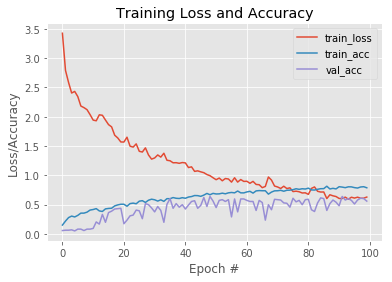

In [14]:
import pycm

# Evaluate the network
print('[INFO] evaluating network...')
predictions = model.predict(testX, batch_size=BATCH_SIZE)

cm = pycm.ConfusionMatrix(
    actual_vector=lb.inverse_transform(testY),
    predict_vector=lb.inverse_transform(predictions)
)
cm.save_html(r'output/confusion_matrix.html')

# Plot the training loss and accuracy
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N_EPOCHS), history.history['loss'], label='train_loss')
#plt.plot(np.arange(0, N_EPOCHS), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, N_EPOCHS), history.history['acc'], label='train_acc')
plt.plot(np.arange(0, N_EPOCHS), history.history['val_acc'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()